# Magnetic model validations

Test remote server-side model evaluation with the target one.

In [1]:
from viresclient._wps.time_util import parse_datetime, parse_duration
from validation import get_data, get_random_collection, get_random_time
from local_models import get_compared_model_values

COLLECTIONS = ["SW_OPER_MAGA_LR_1B", "SW_OPER_MAGB_LR_1B", "SW_OPER_MAGC_LR_1B"]

#SERVER_URL = "https://staging.viresdisc.vires.services"
SERVER_URL = "https://vires.services"

requested_models = [
    "CHAOS",
    "CHAOS-Core",
    "CHAOS-Static",
    "CHAOS-MMA",
    "CHAOS-MMA-Primary",
    "CHAOS-MMA-Secondary",
    "MIO_SHA_2C",
    "MIO_SHA_2C-Primary",
    "MIO_SHA_2C-Secondary",
]

collection = get_random_collection(COLLECTIONS)

collection_start = parse_datetime("2014-01-01")
collection_end = parse_datetime("2019-12-31")

collection = "SW_OPER_MAGB_LR_1B"
#start = get_random_time(collection_start, collection_end)
start = parse_datetime("2016-12-31T12:00")
end = start + parse_duration("P1D")

print(f"{collection} {start.isoformat()}/{end.isoformat()}")

data = get_compared_model_values(
   url=SERVER_URL,
   collection=collection,
   start_time=start,
   end_time=end,
   models=requested_models,
)

/opt/conda/lib/python3.9/site-packages/spacepy/time.py:2365: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


SW_OPER_MAGB_LR_1B 2016-12-31T12:00:00/2017-01-01T12:00:00


Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.48MB)

https://vires.services 4.55708s
Data written to ./data/data.cdf
evaluating model CHAOS ... OK  3.64246 s
evaluating model CHAOS-Core ... OK  0.106872 s
evaluating model CHAOS-Static ... OK  1.63745 s
evaluating model CHAOS-MMA ... OK  3.25021 s
evaluating model CHAOS-MMA-Primary ... OK  1.28583 s
evaluating model CHAOS-MMA-Secondary ... OK  1.25583 s
evaluating model MIO_SHA_2C ... OK  1.11247 s
evaluating model MIO_SHA_2C-Primary ... OK  0.632168 s
evaluating model MIO_SHA_2C-Secondary ... OK  0.545494 s
evaluating model CHAOS ... OK  3.51083 s
evaluating model CHAOS-Core ... OK  0.103481 s
evaluating model CHAOS-Static ... OK  0.879513 s
evaluating model CHAOS-MMA ... OK  2.59291 s
evaluating model CHAOS-MMA-Primary ... OK  1.30334 s
evaluating model CHAOS-MMA-Secondary ... OK  1.38802 s
evaluating model MIO_SHA_2C ... OK  1.11924 s
evaluating model MIO_SHA_2C-Primary ... OK  0.529368 s
evaluating model MIO_SHA_2C-Secondary ... OK  0.555668 s


## Server vs. local model evaluation

- inputs for the local are extracted from the data response (xarray)
- time conversion:
  - CDF_EPOCH is converted to Unix epoch (float secons since 1970-01-01T00:00:00)
  - Unix epoch is converted to Numpy `datetime64['ns']`
  - Numpy `datetime64['ns']` is converted to MJD2000 (integer number ns since 2000-01-01T00:00:00 times 1/86400000000000) 

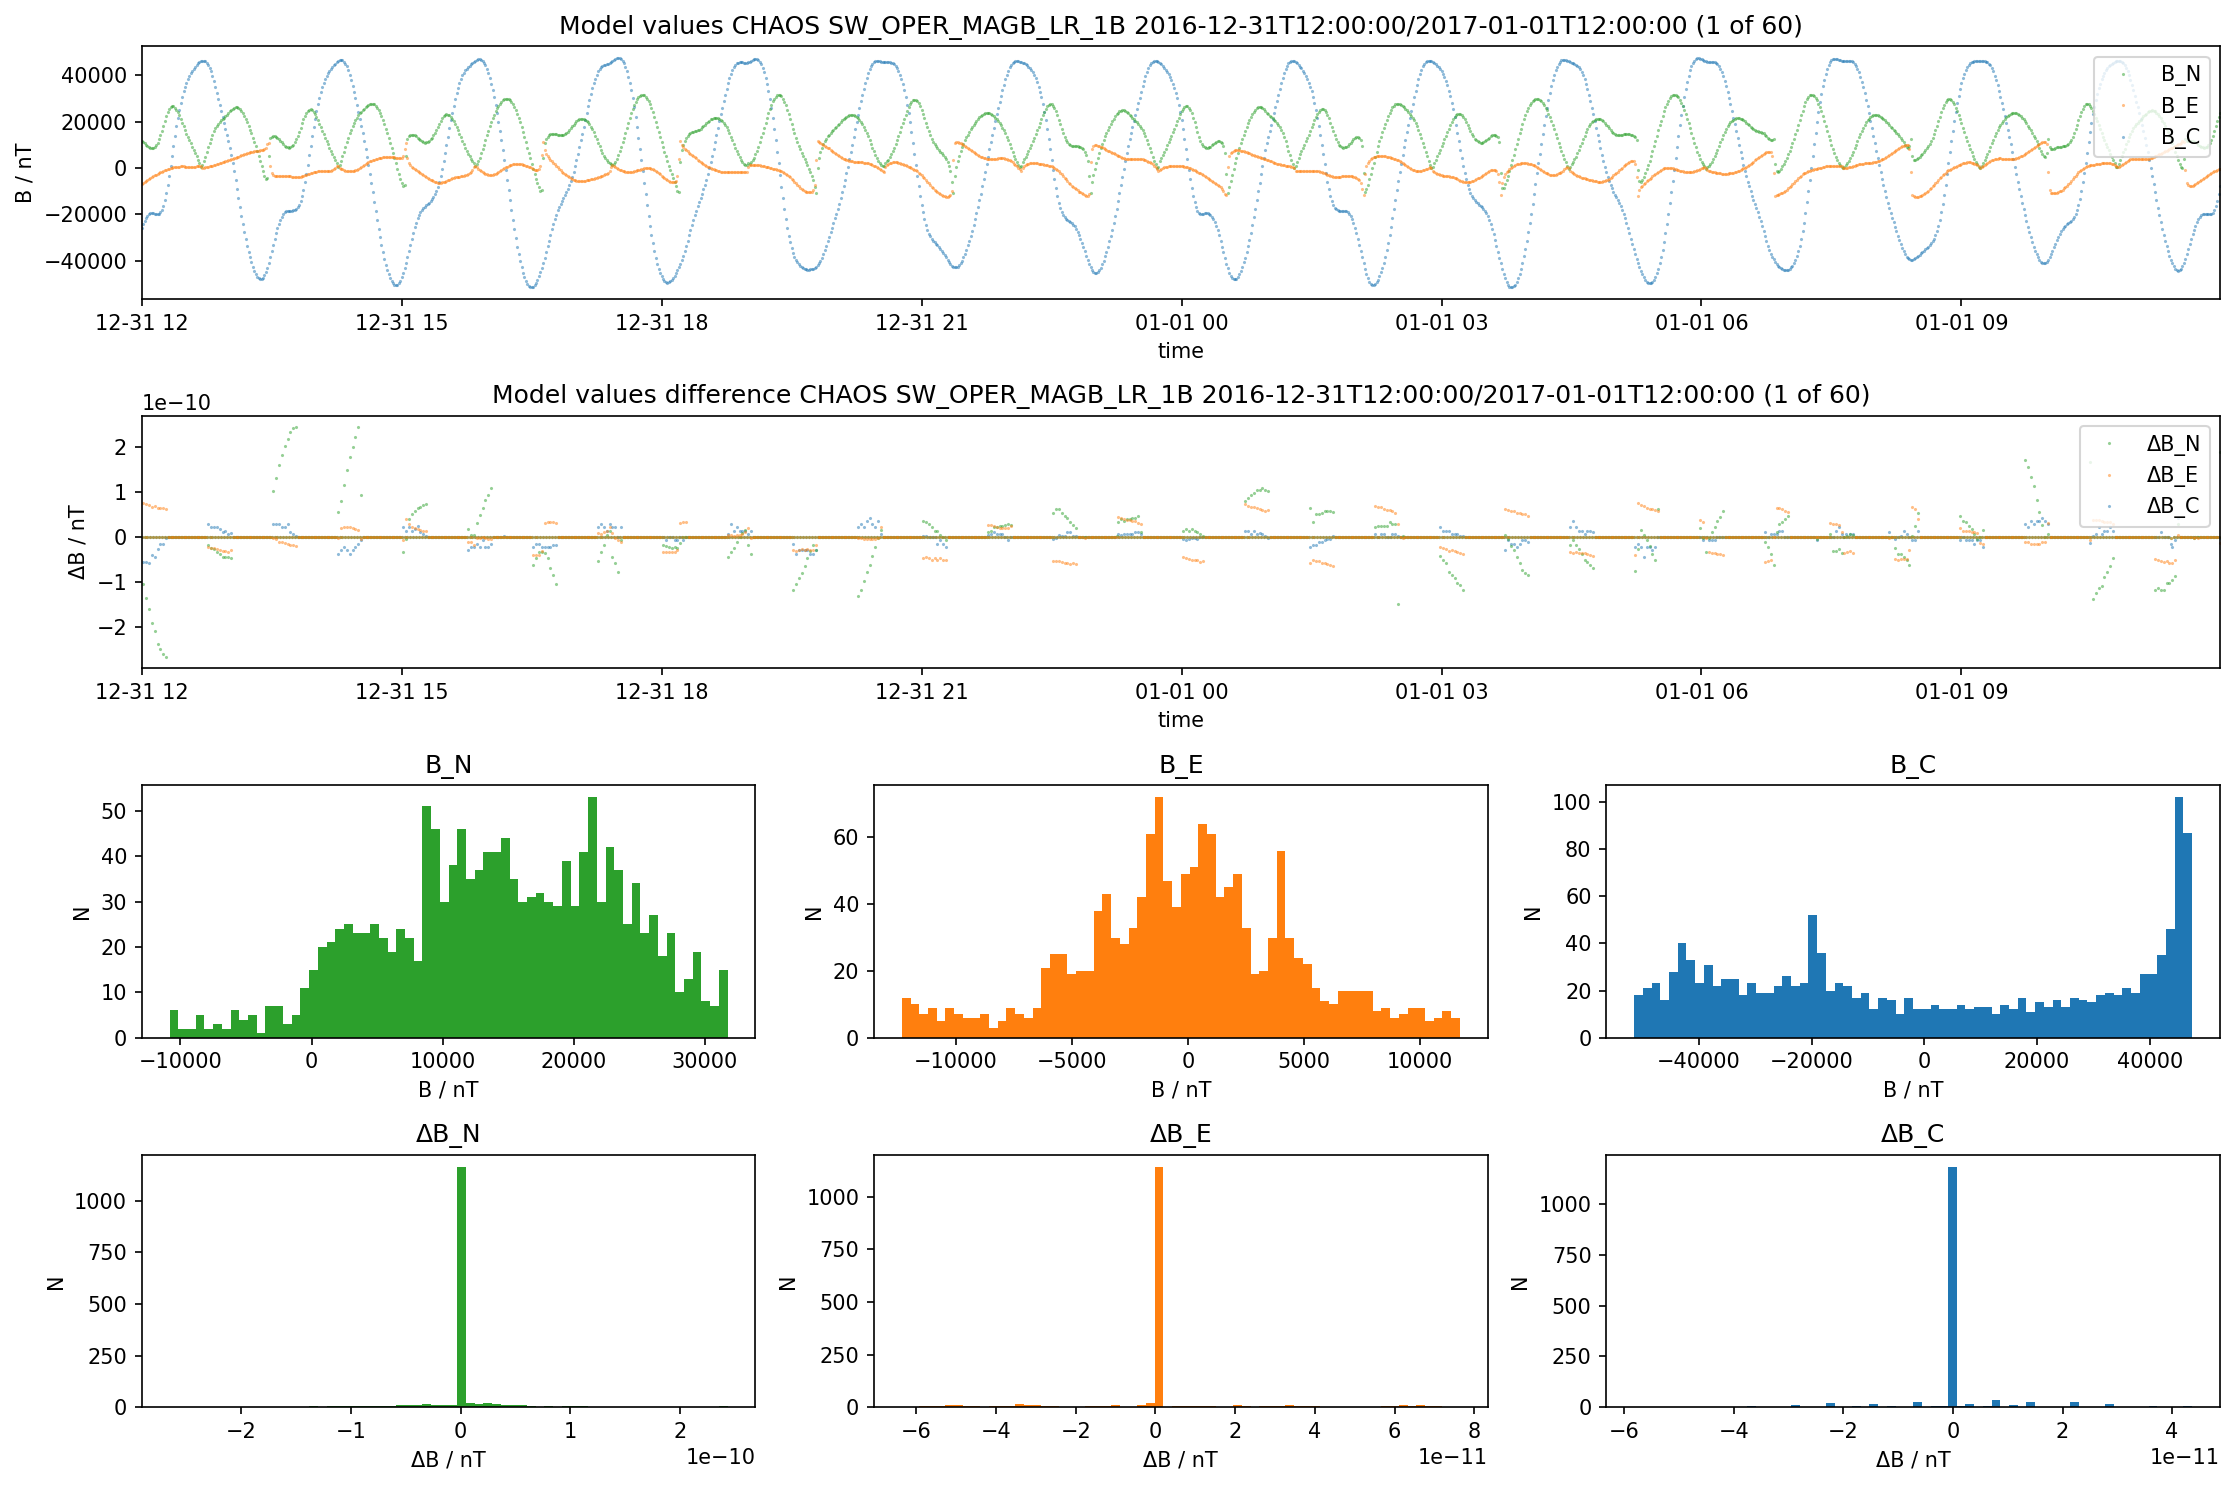

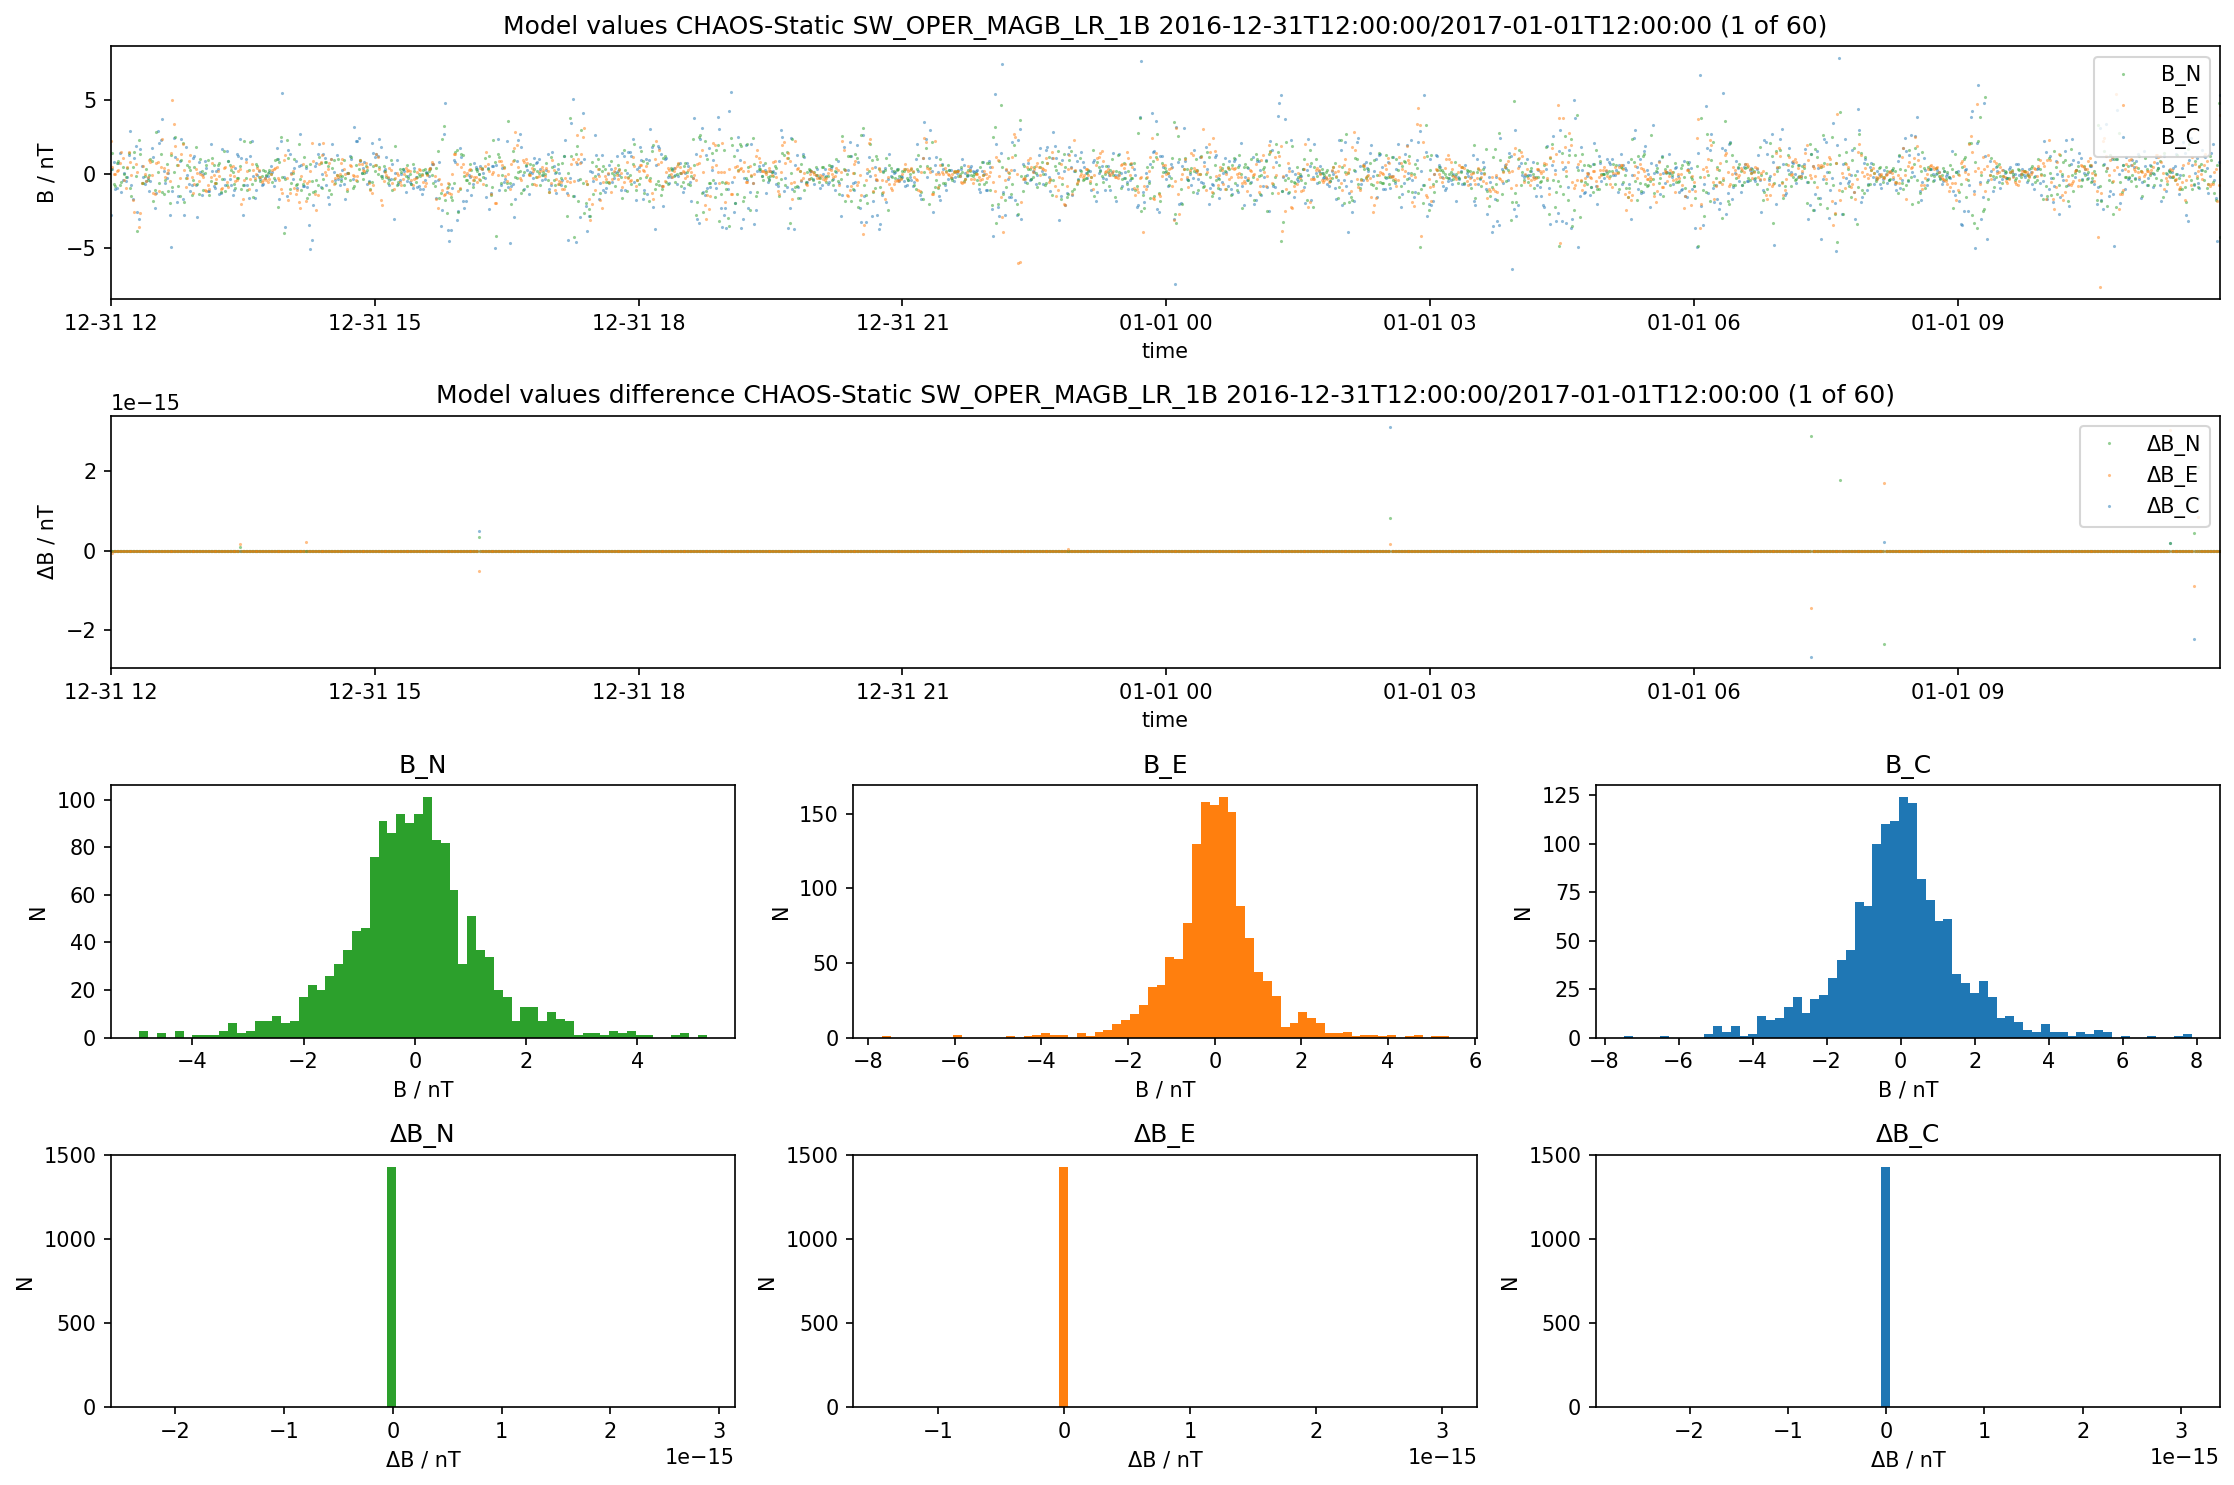

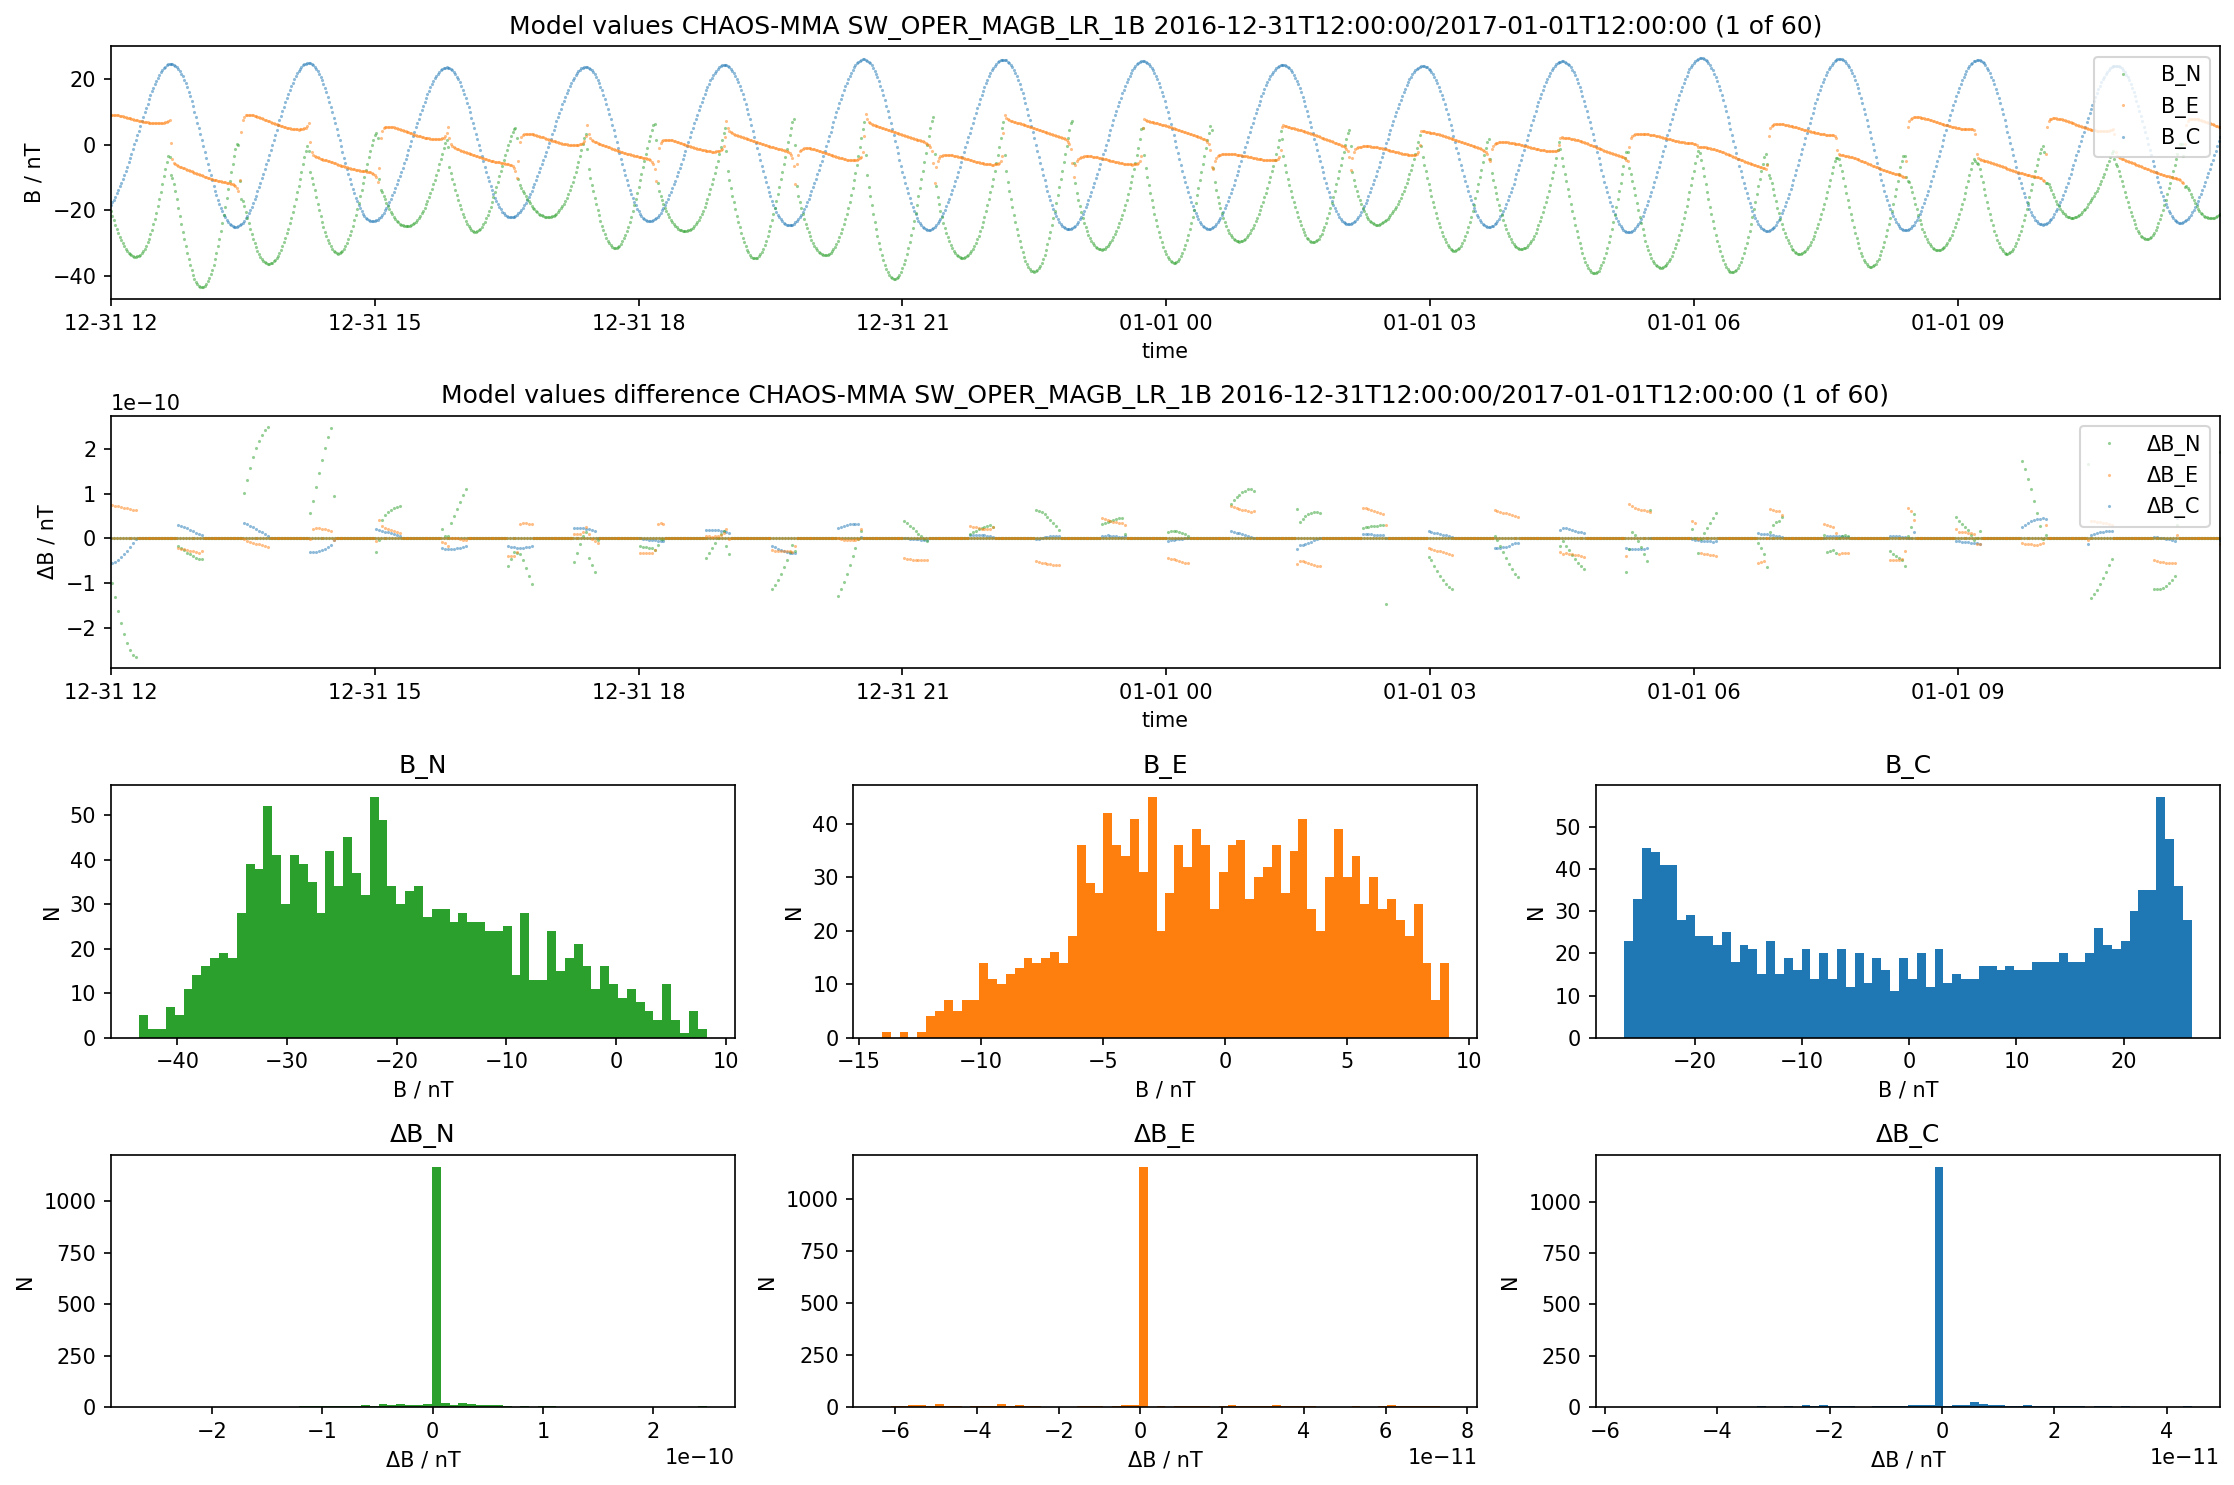

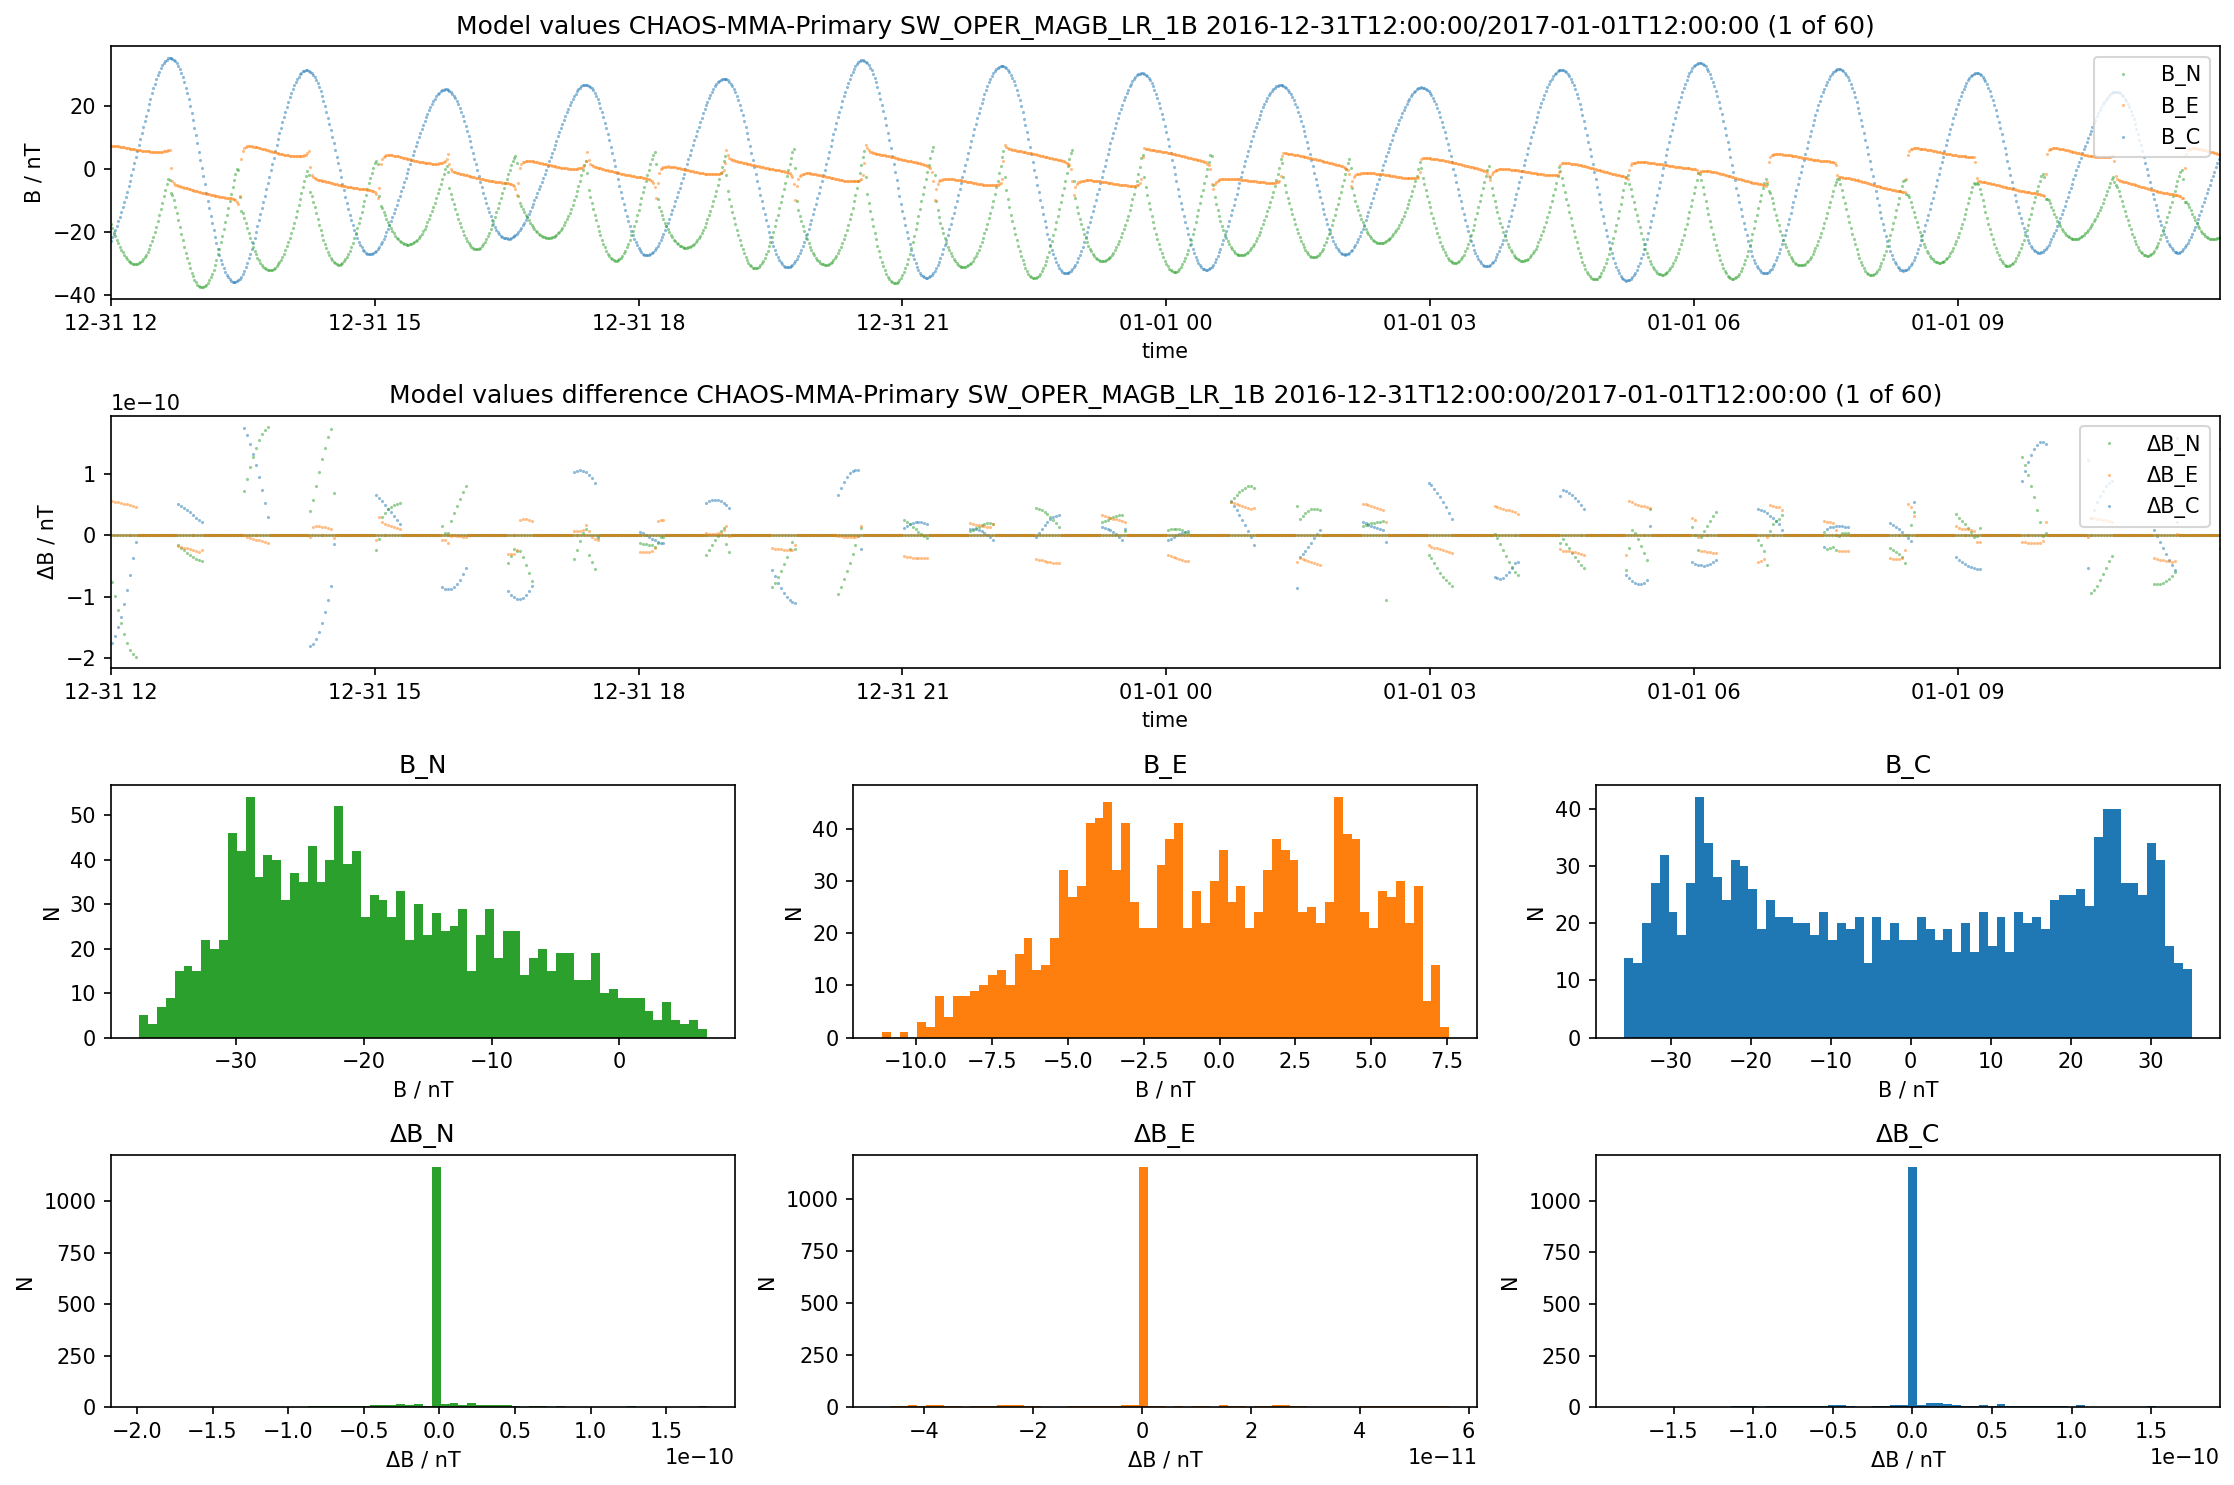

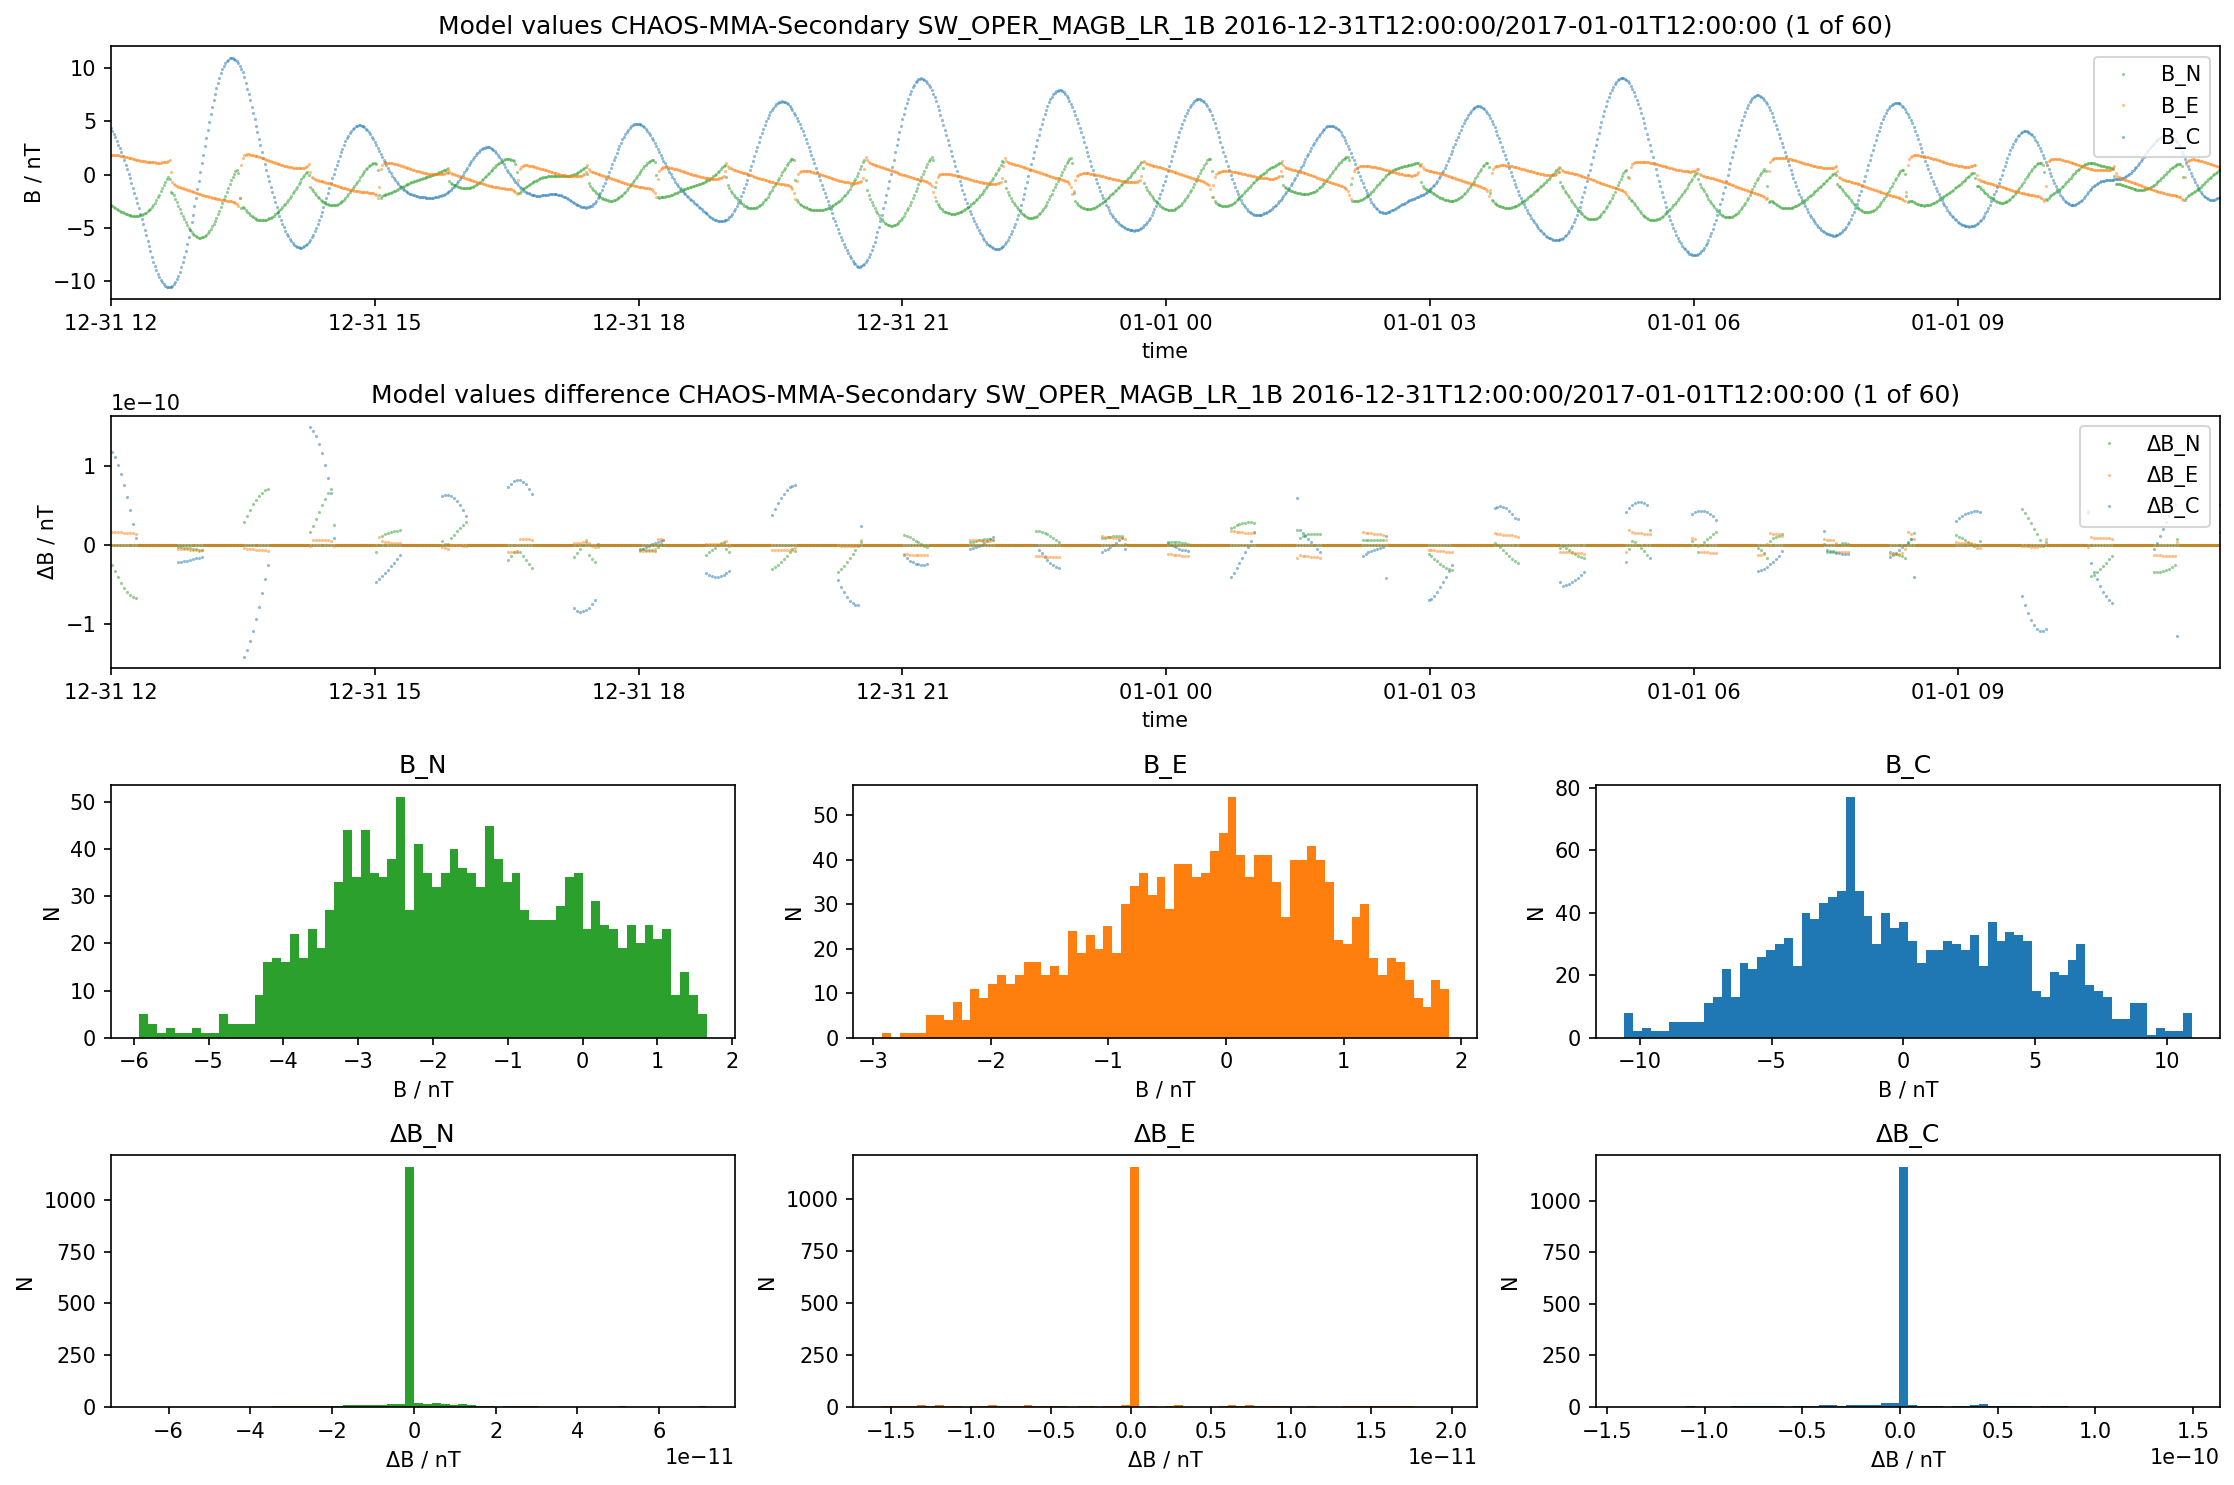

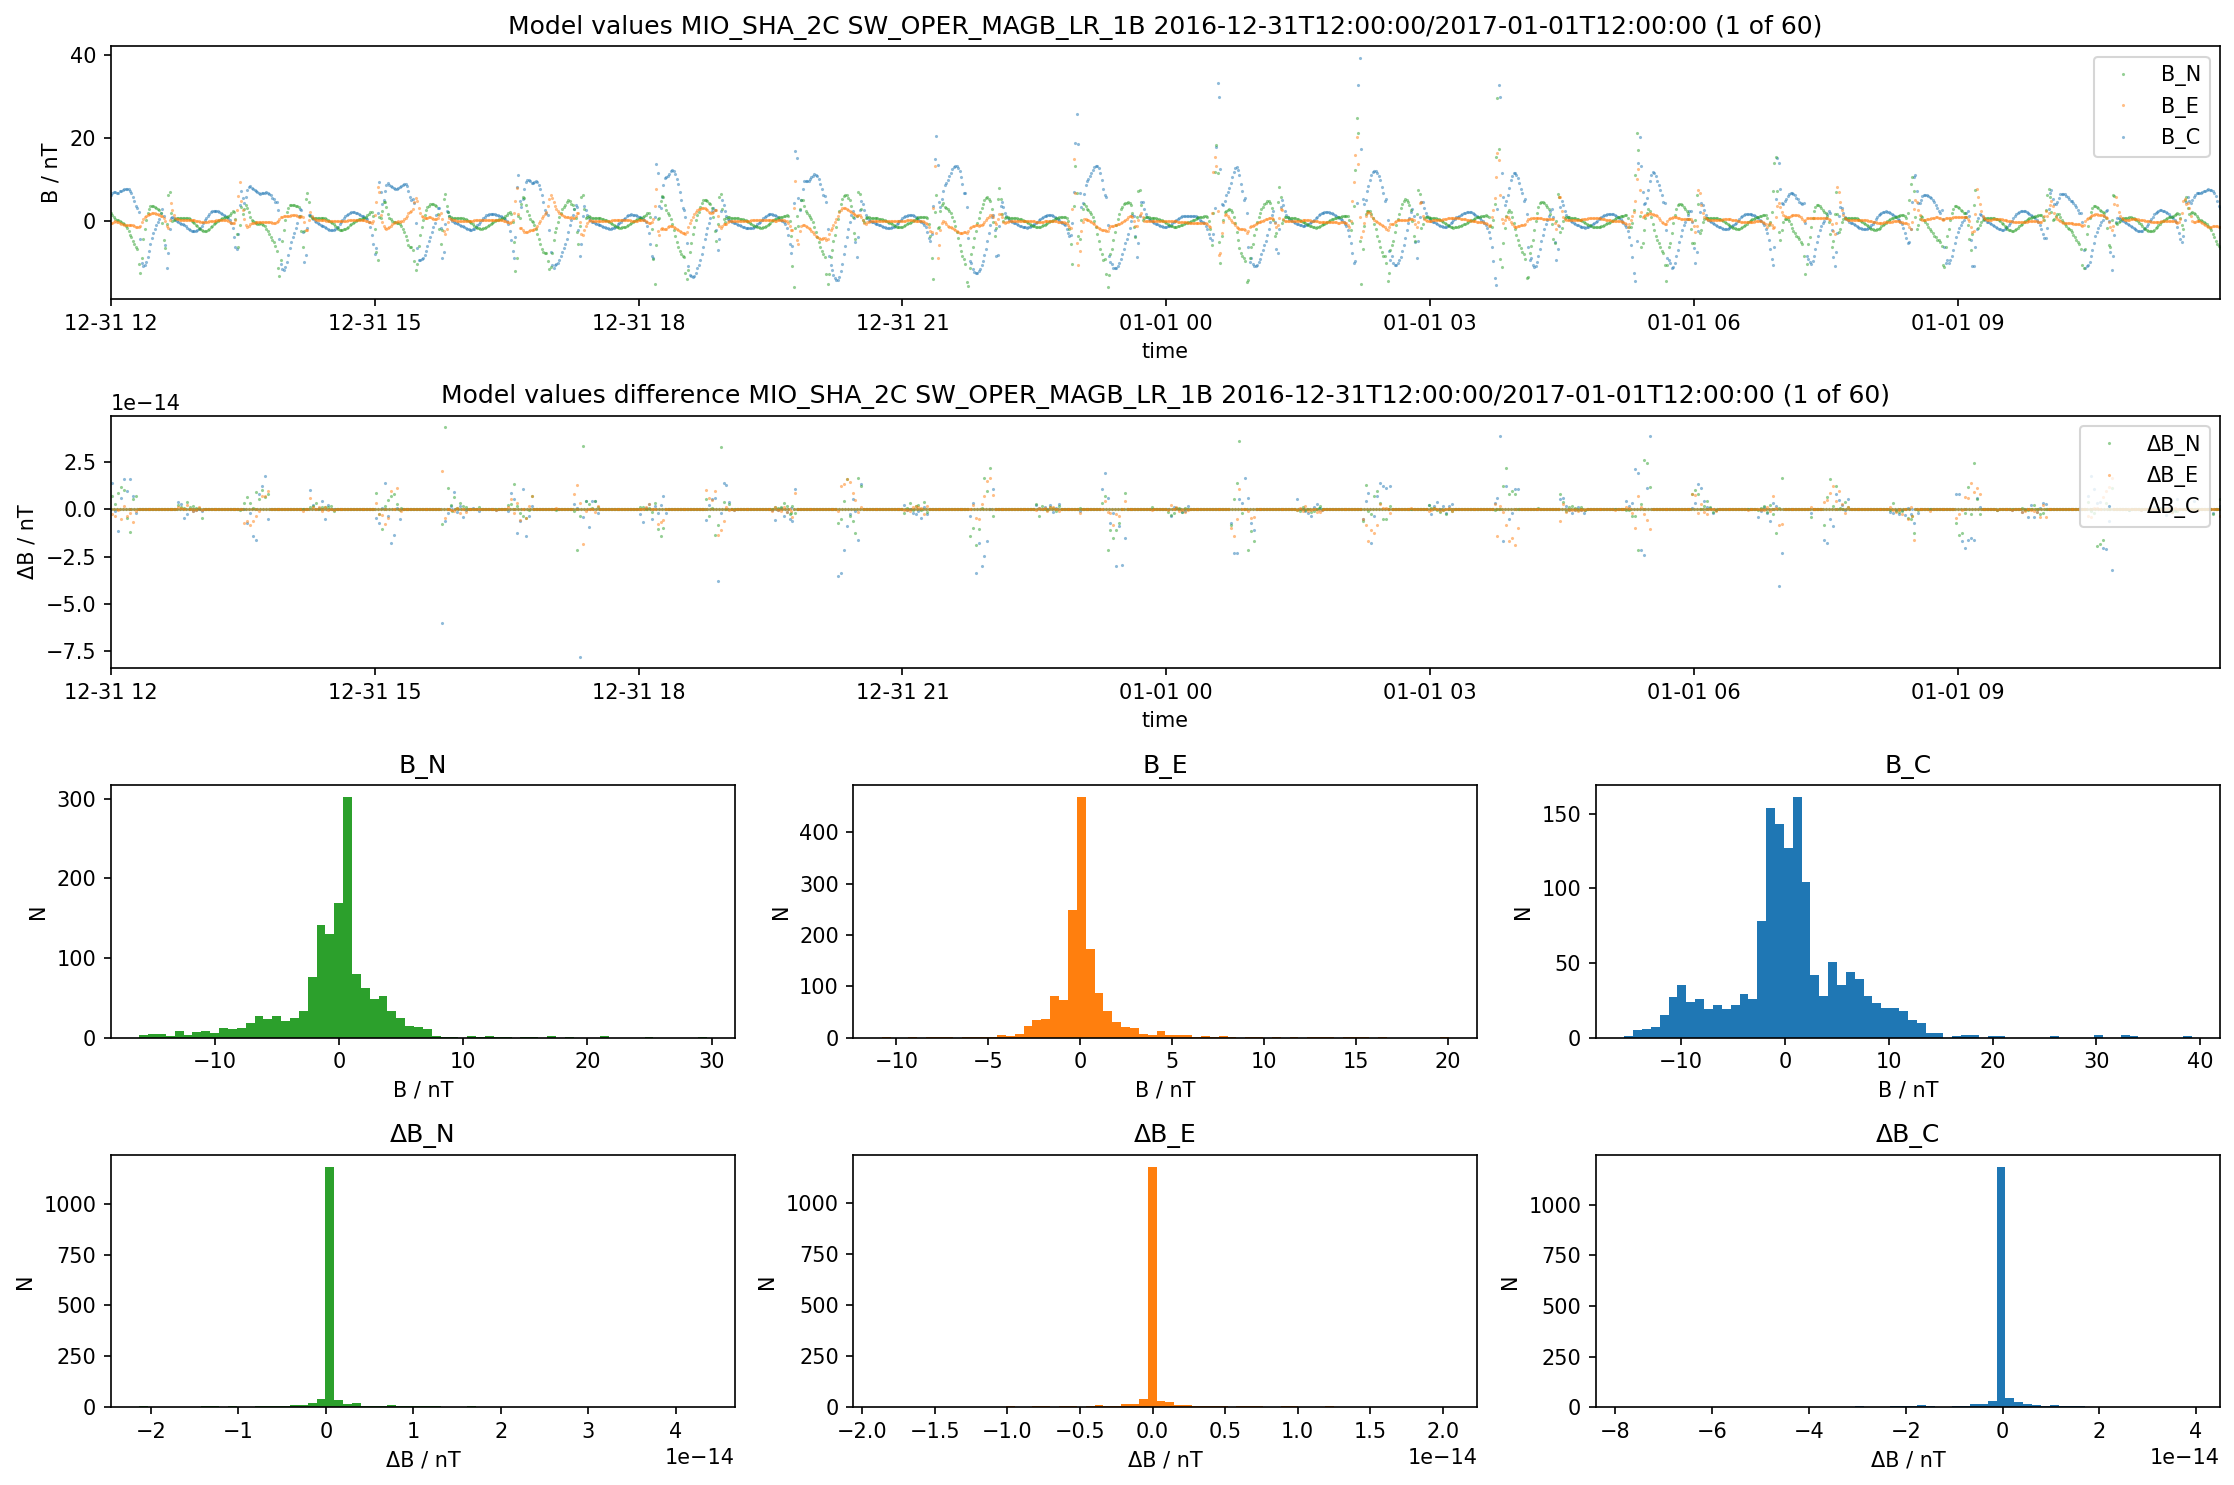

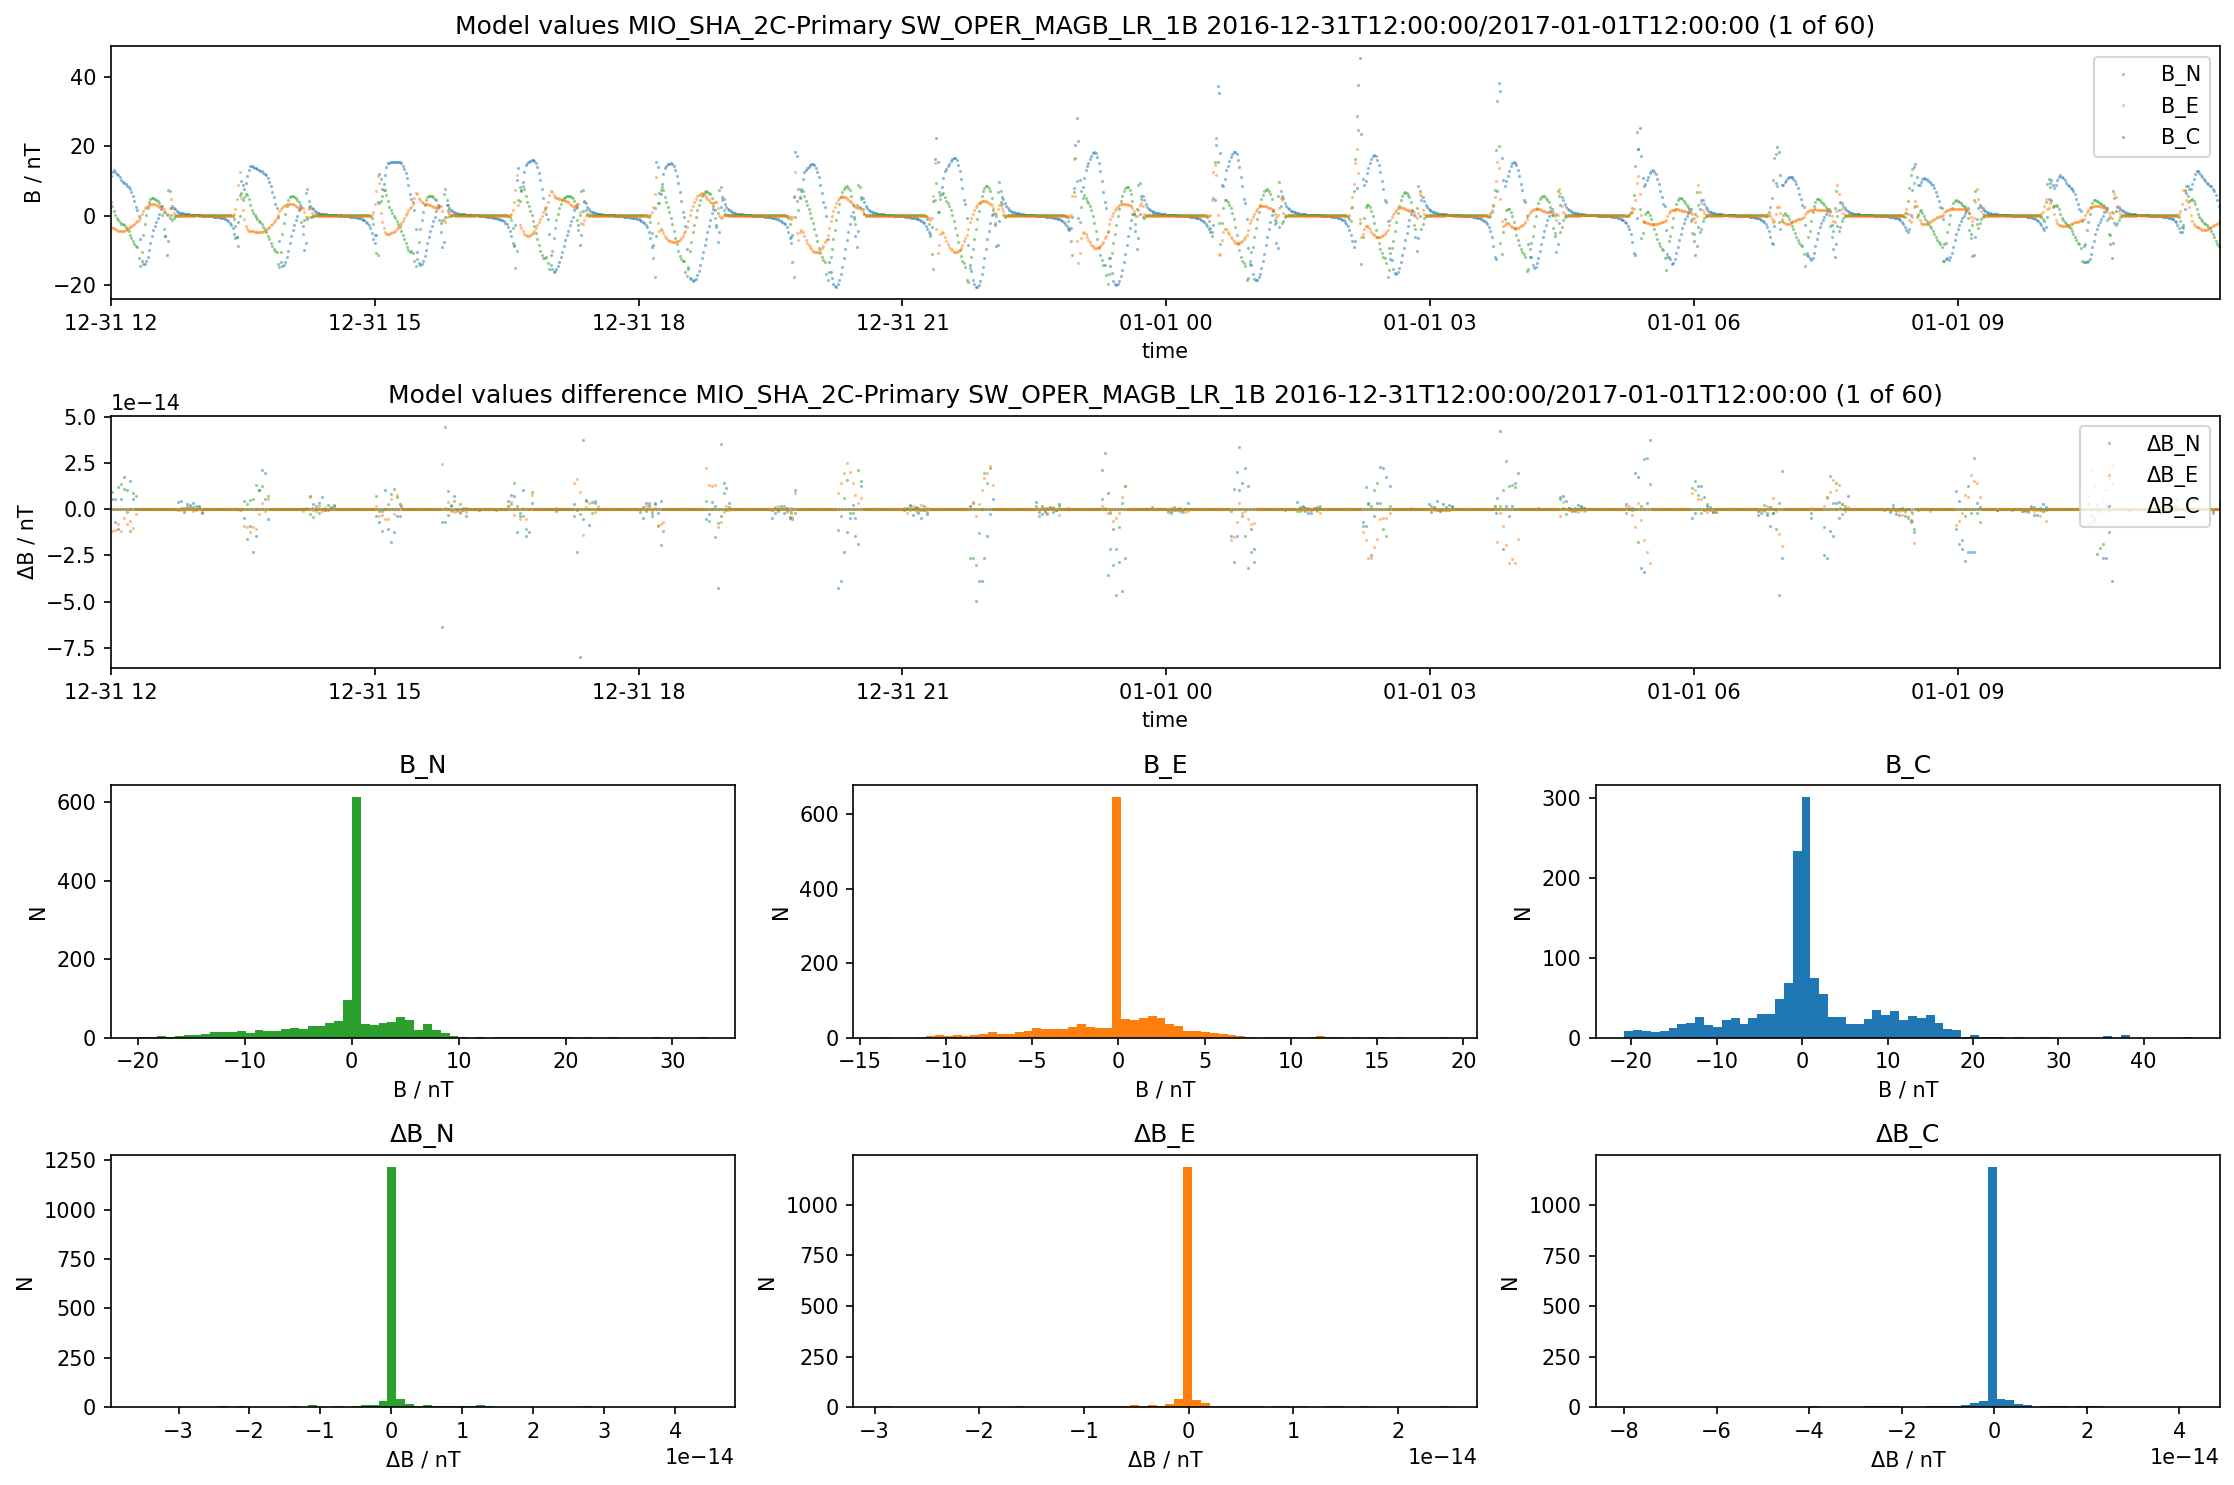

In [2]:
from matplotlib.pyplot import figure, subplot

def _plot_data(ax, x, y):
    options = {"ms": 1, "alpha": 0.5}
    h_c, = ax.plot(x, y[:,2], '.', color="tab:blue", **options)
    h_n, = ax.plot(x, y[:,0], '.', color="tab:green", **options)
    h_e, = ax.plot(x, y[:,1], '.', color="tab:orange", **options)
    return h_n, h_e, h_c


def plot_local(ax, data, name):
    handlers = _plot_data(ax, data["Timestamp"], data["local"][name])    
    ax.set_xlim([data["Timestamp"].min(), data["Timestamp"].max()])
    ax.set_xlabel("time")
    ax.set_ylabel("B / nT")
    ax.set_title(f"Model values {name} {data['info']['collection']} {data['info']['start']}/{data['info']['end']} (1 of 60)")
    ax.legend(handlers, ["B_N", "B_E", "B_C"], loc="upper right")


def plot_delta(ax, data, name):
    handlers = _plot_data(ax, data["Timestamp"], data["tested"][name] - data["local"][name])
    ax.set_xlim([data["Timestamp"].min(), data["Timestamp"].max()])
    ax.set_xlabel("time")
    ax.set_ylabel("ΔB / nT")
    ax.set_title(f"Model values difference {name} {data['info']['collection']} {data['info']['start']}/{data['info']['end']} (1 of 60)")
    ax.legend(handlers, ["ΔB_N", "ΔB_E", "ΔB_C"], loc="upper right")

    
def plot_local_histogram(ax, data, name, idx, label, **options):
    ax.hist(data["local"][name][:,idx], bins=64, **options)
    ax.set_title(label)
    ax.set_xlabel("B / nT")
    ax.set_ylabel("N")

    
def plot_delta_histogram(ax, data, name, idx, label, **options):
    ax.hist(data["tested"][name][:,idx] - data["local"][name][:,idx], bins=64, **options)
    ax.set_title(label)
    ax.set_xlabel("ΔB / nT")
    ax.set_ylabel("N")

    
model_names = data["info"]["model_names"]

for model_name in model_names:
    fig = figure(figsize=(15, 10), dpi=150)
    ax = subplot(4, 1, 1)
    plot_local(ax, data, model_name)
    ax = subplot(4, 1, 2)
    plot_delta(ax, data, model_name)
    ax = subplot(4, 3, 7)
    plot_local_histogram(ax, data, model_name, 0, "B_N", color="tab:green")
    ax = subplot(4, 3, 8)
    plot_local_histogram(ax, data, model_name, 1, "B_E", color="tab:orange")
    ax = subplot(4, 3, 9)
    plot_local_histogram(ax, data, model_name, 2, "B_C", color="tab:blue")
    ax = subplot(4, 3, 10)
    plot_delta_histogram(ax, data, model_name, 0, "ΔB_N", color="tab:green")
    ax = subplot(4, 3, 11)
    plot_delta_histogram(ax, data, model_name, 1, "ΔB_E", color="tab:orange")
    ax = subplot(4, 3, 12)
    plot_delta_histogram(ax, data, model_name, 2, "ΔB_C", color="tab:blue")
    fig.tight_layout()

## Server vs. local model evaluation

- inputs for the local are extracted directly from the response CDF file
- time conversion: (identical to VirES server)
  - CDF_EPOCH is converted to MJD200 (float ms since 2000-01-01T00:00:00 divided by 86400000.0)

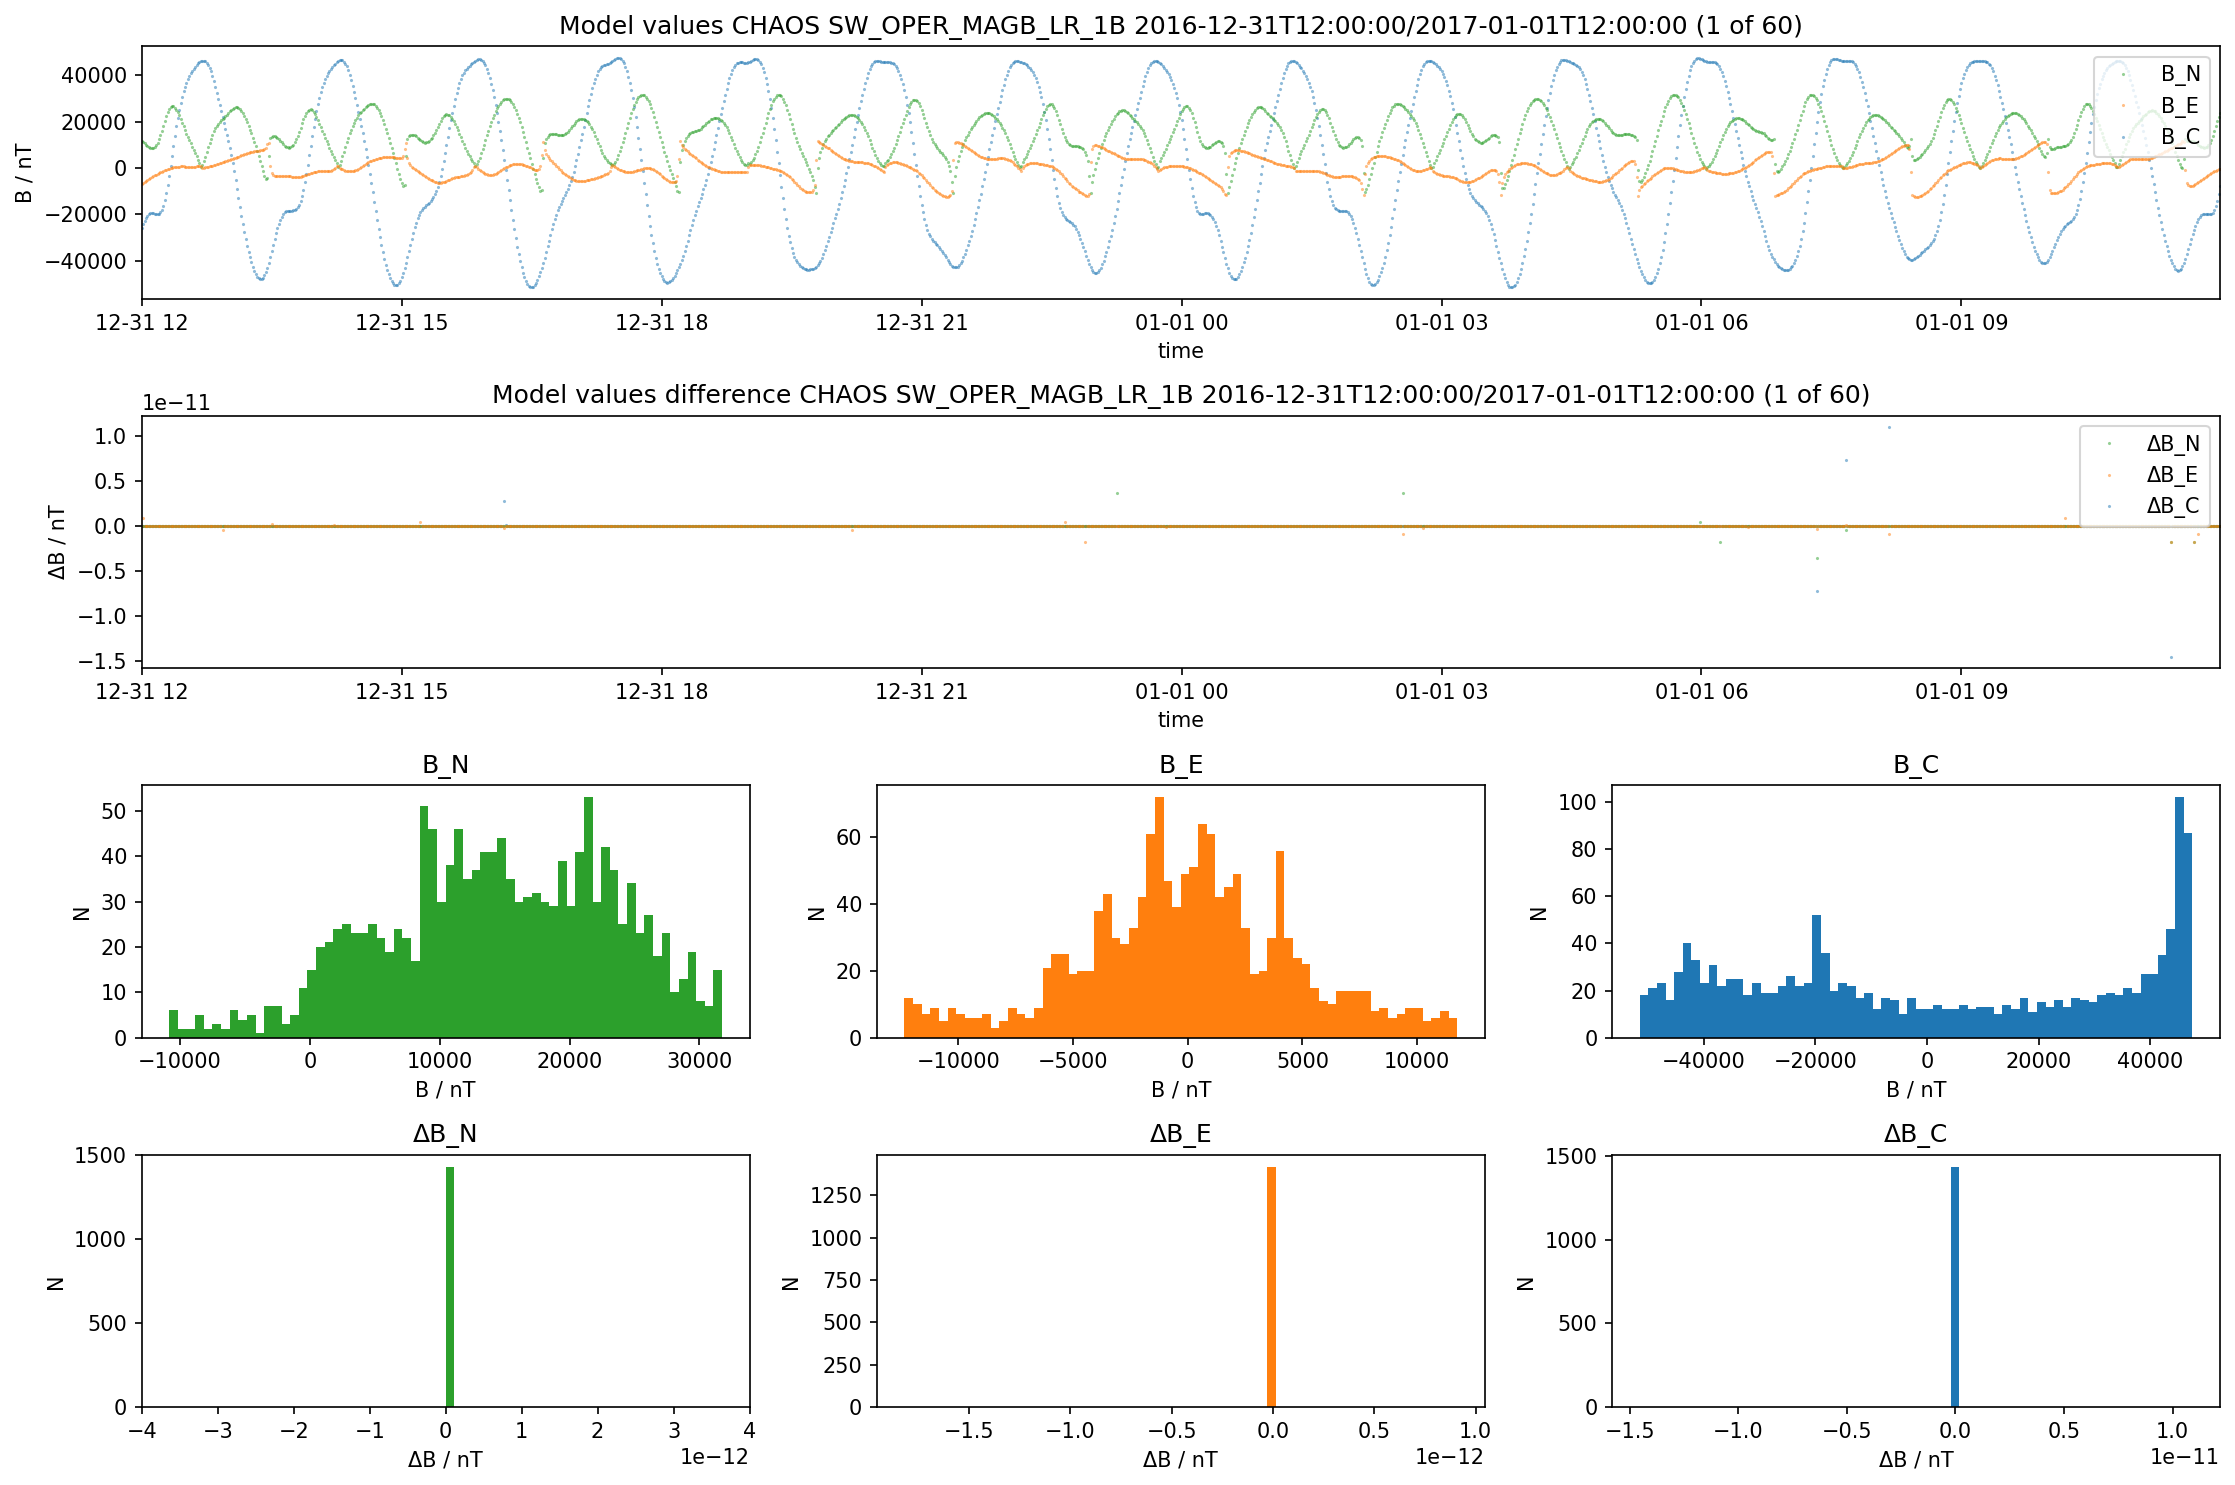

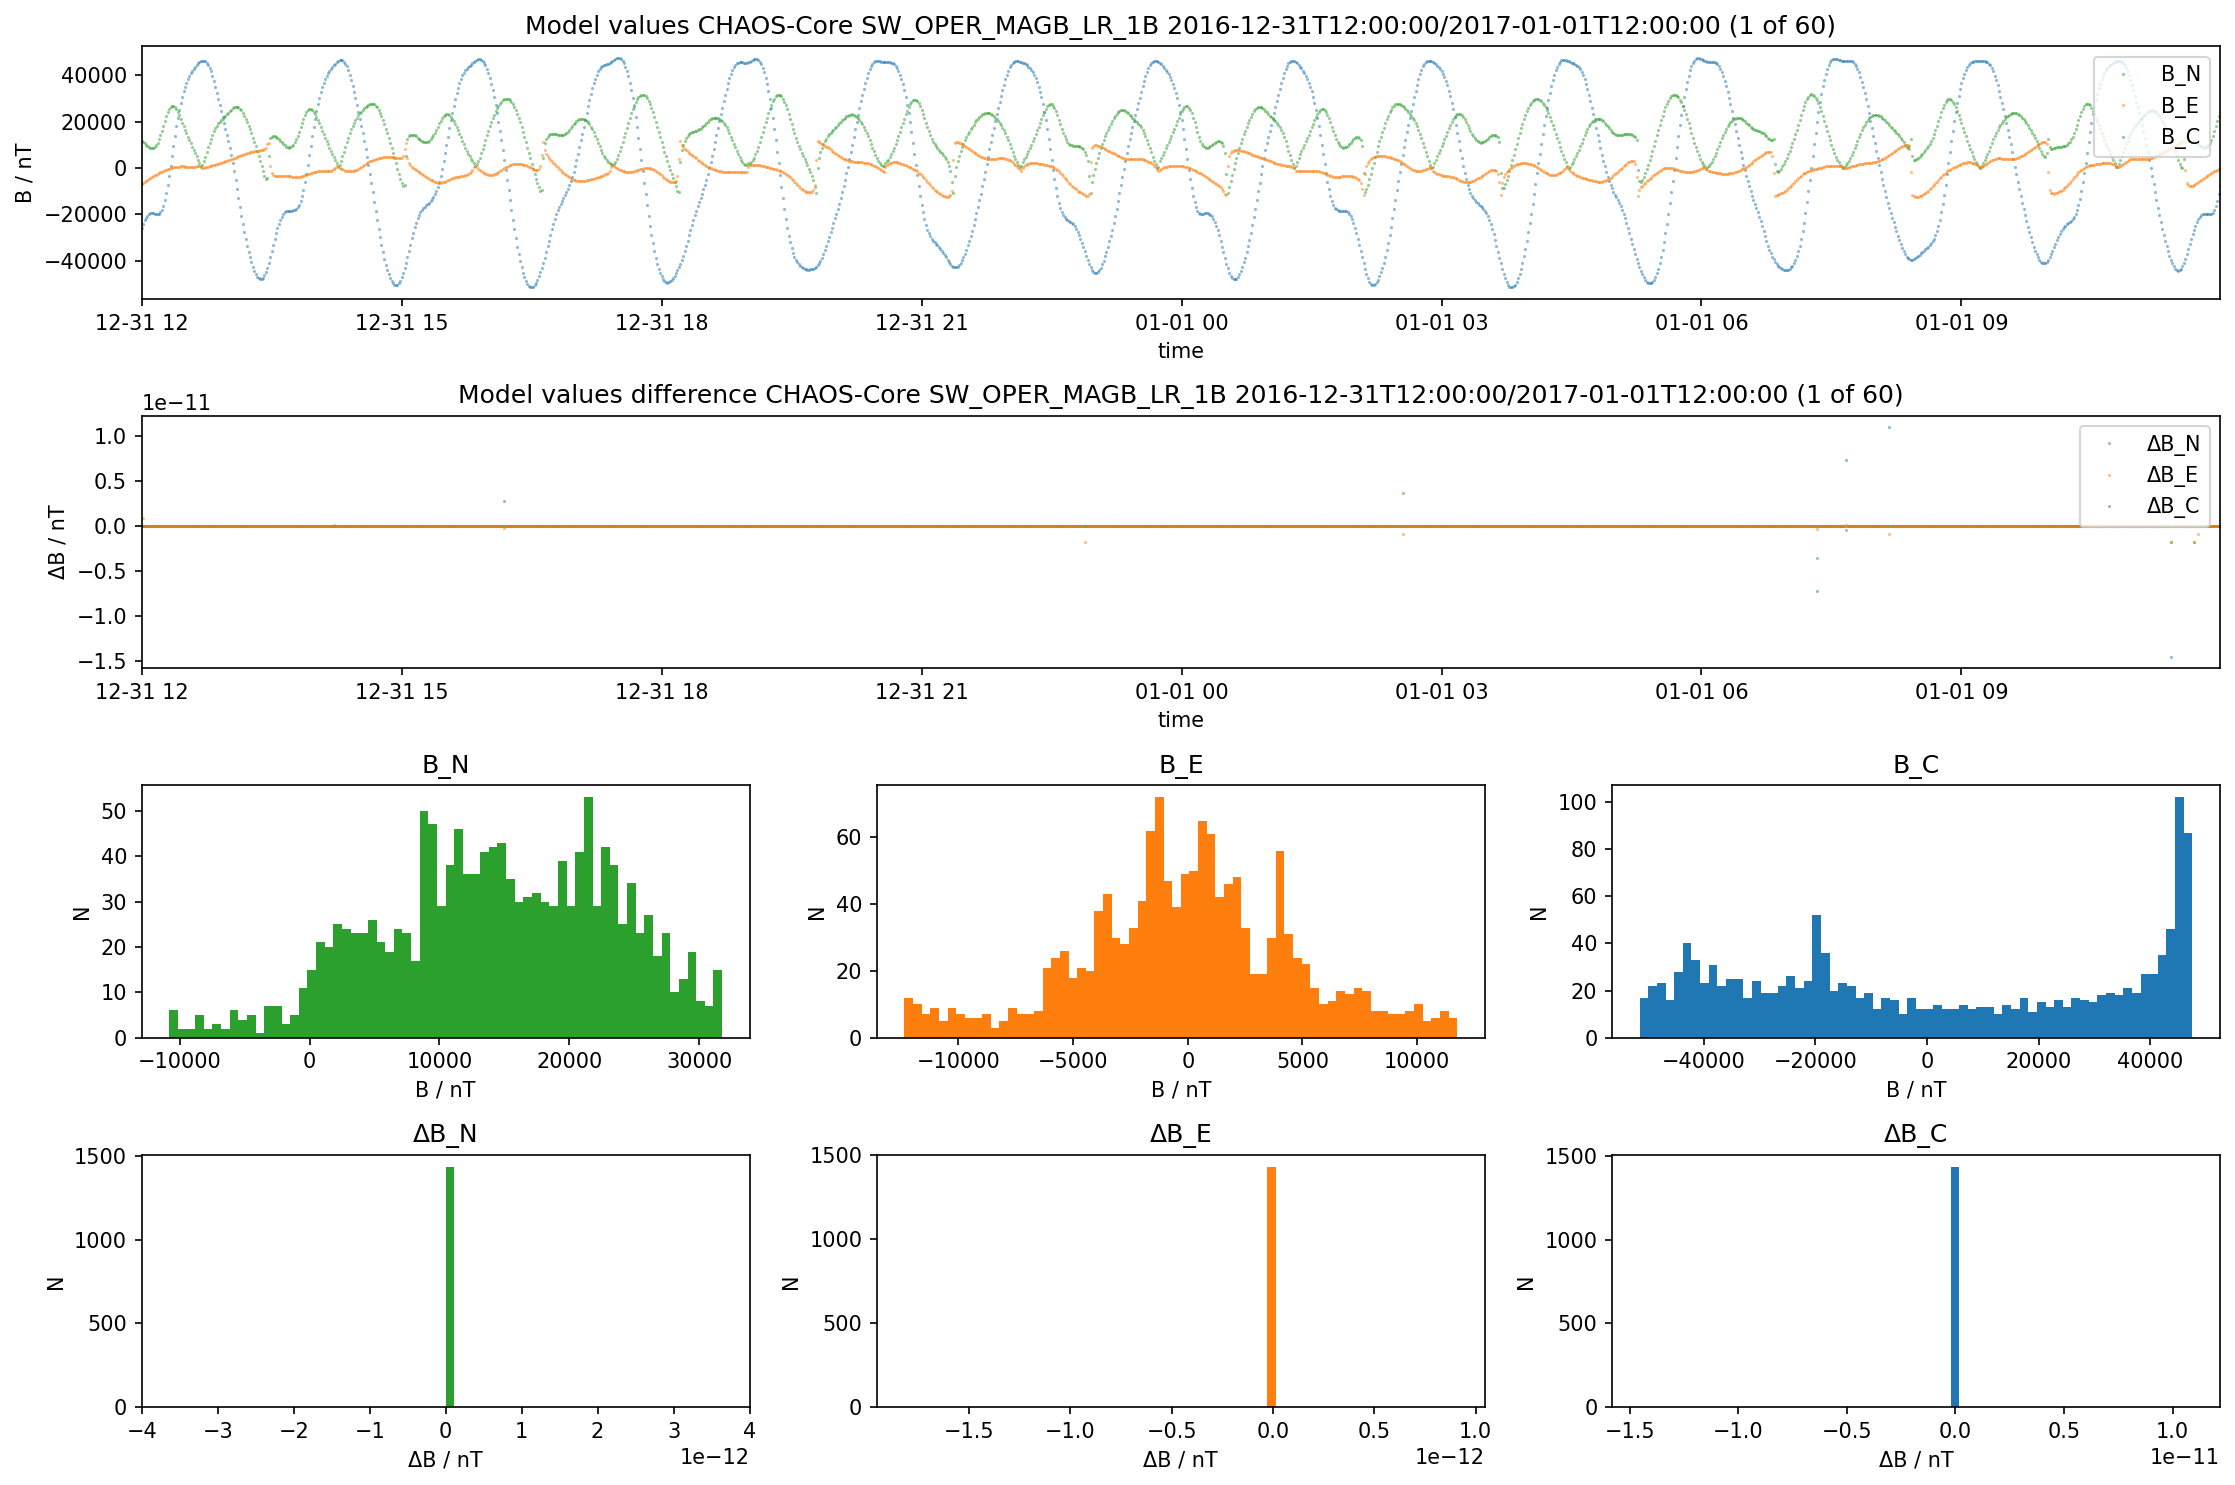

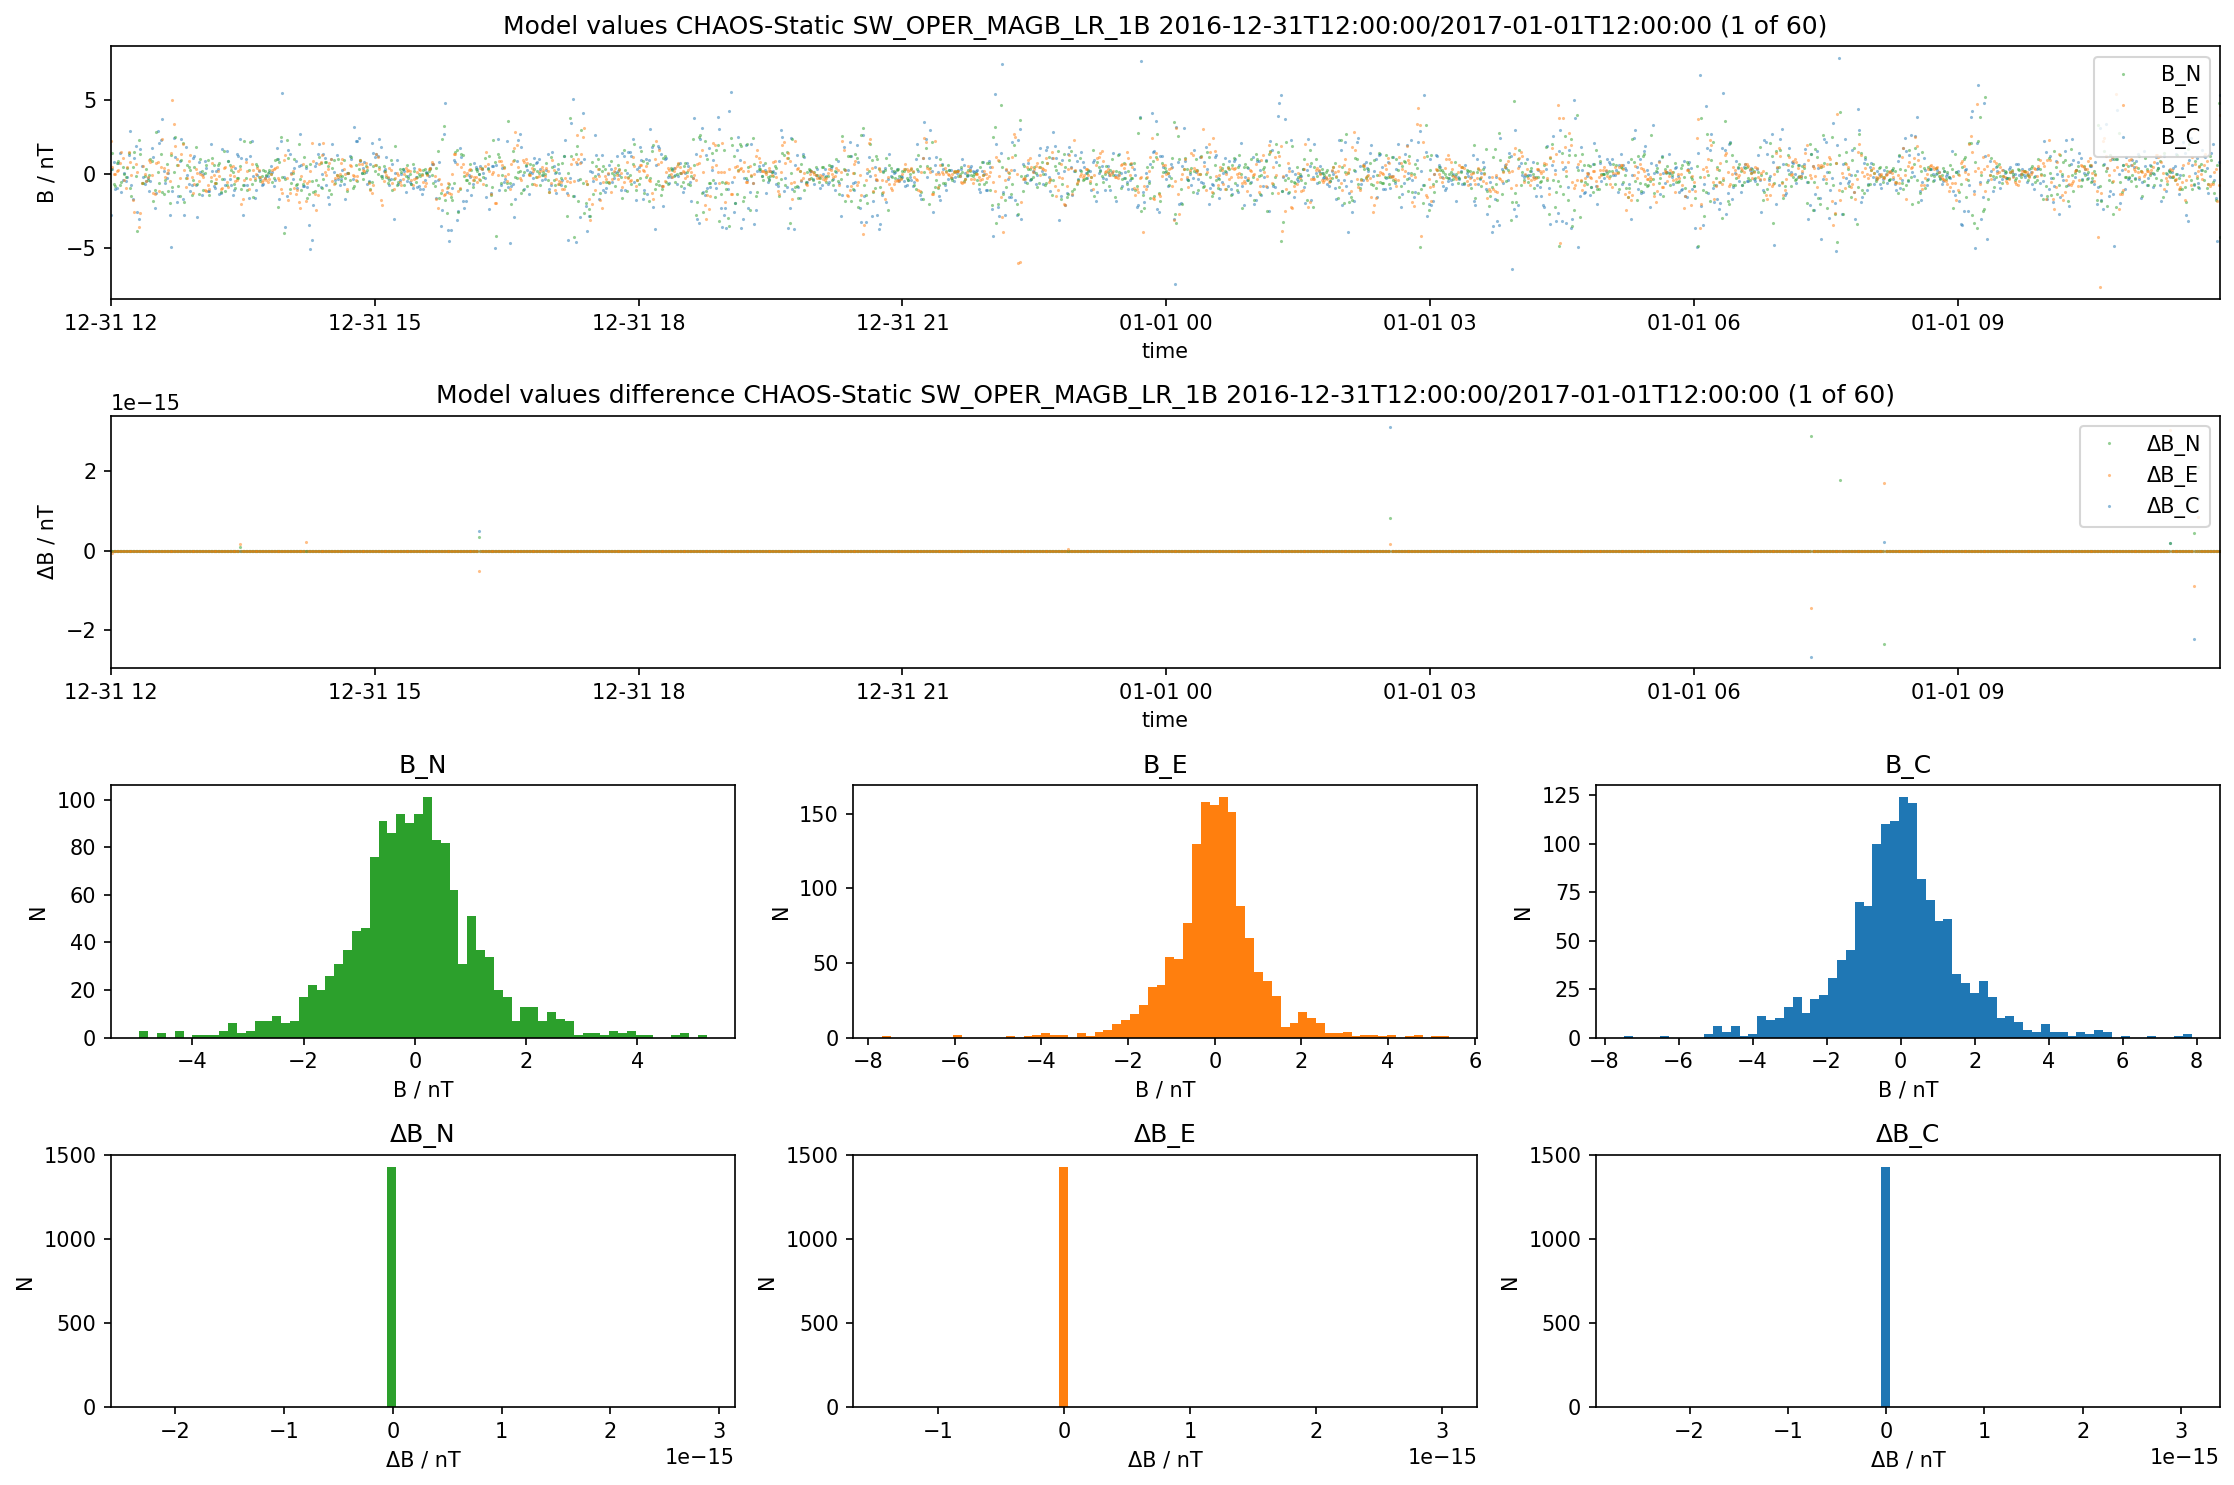

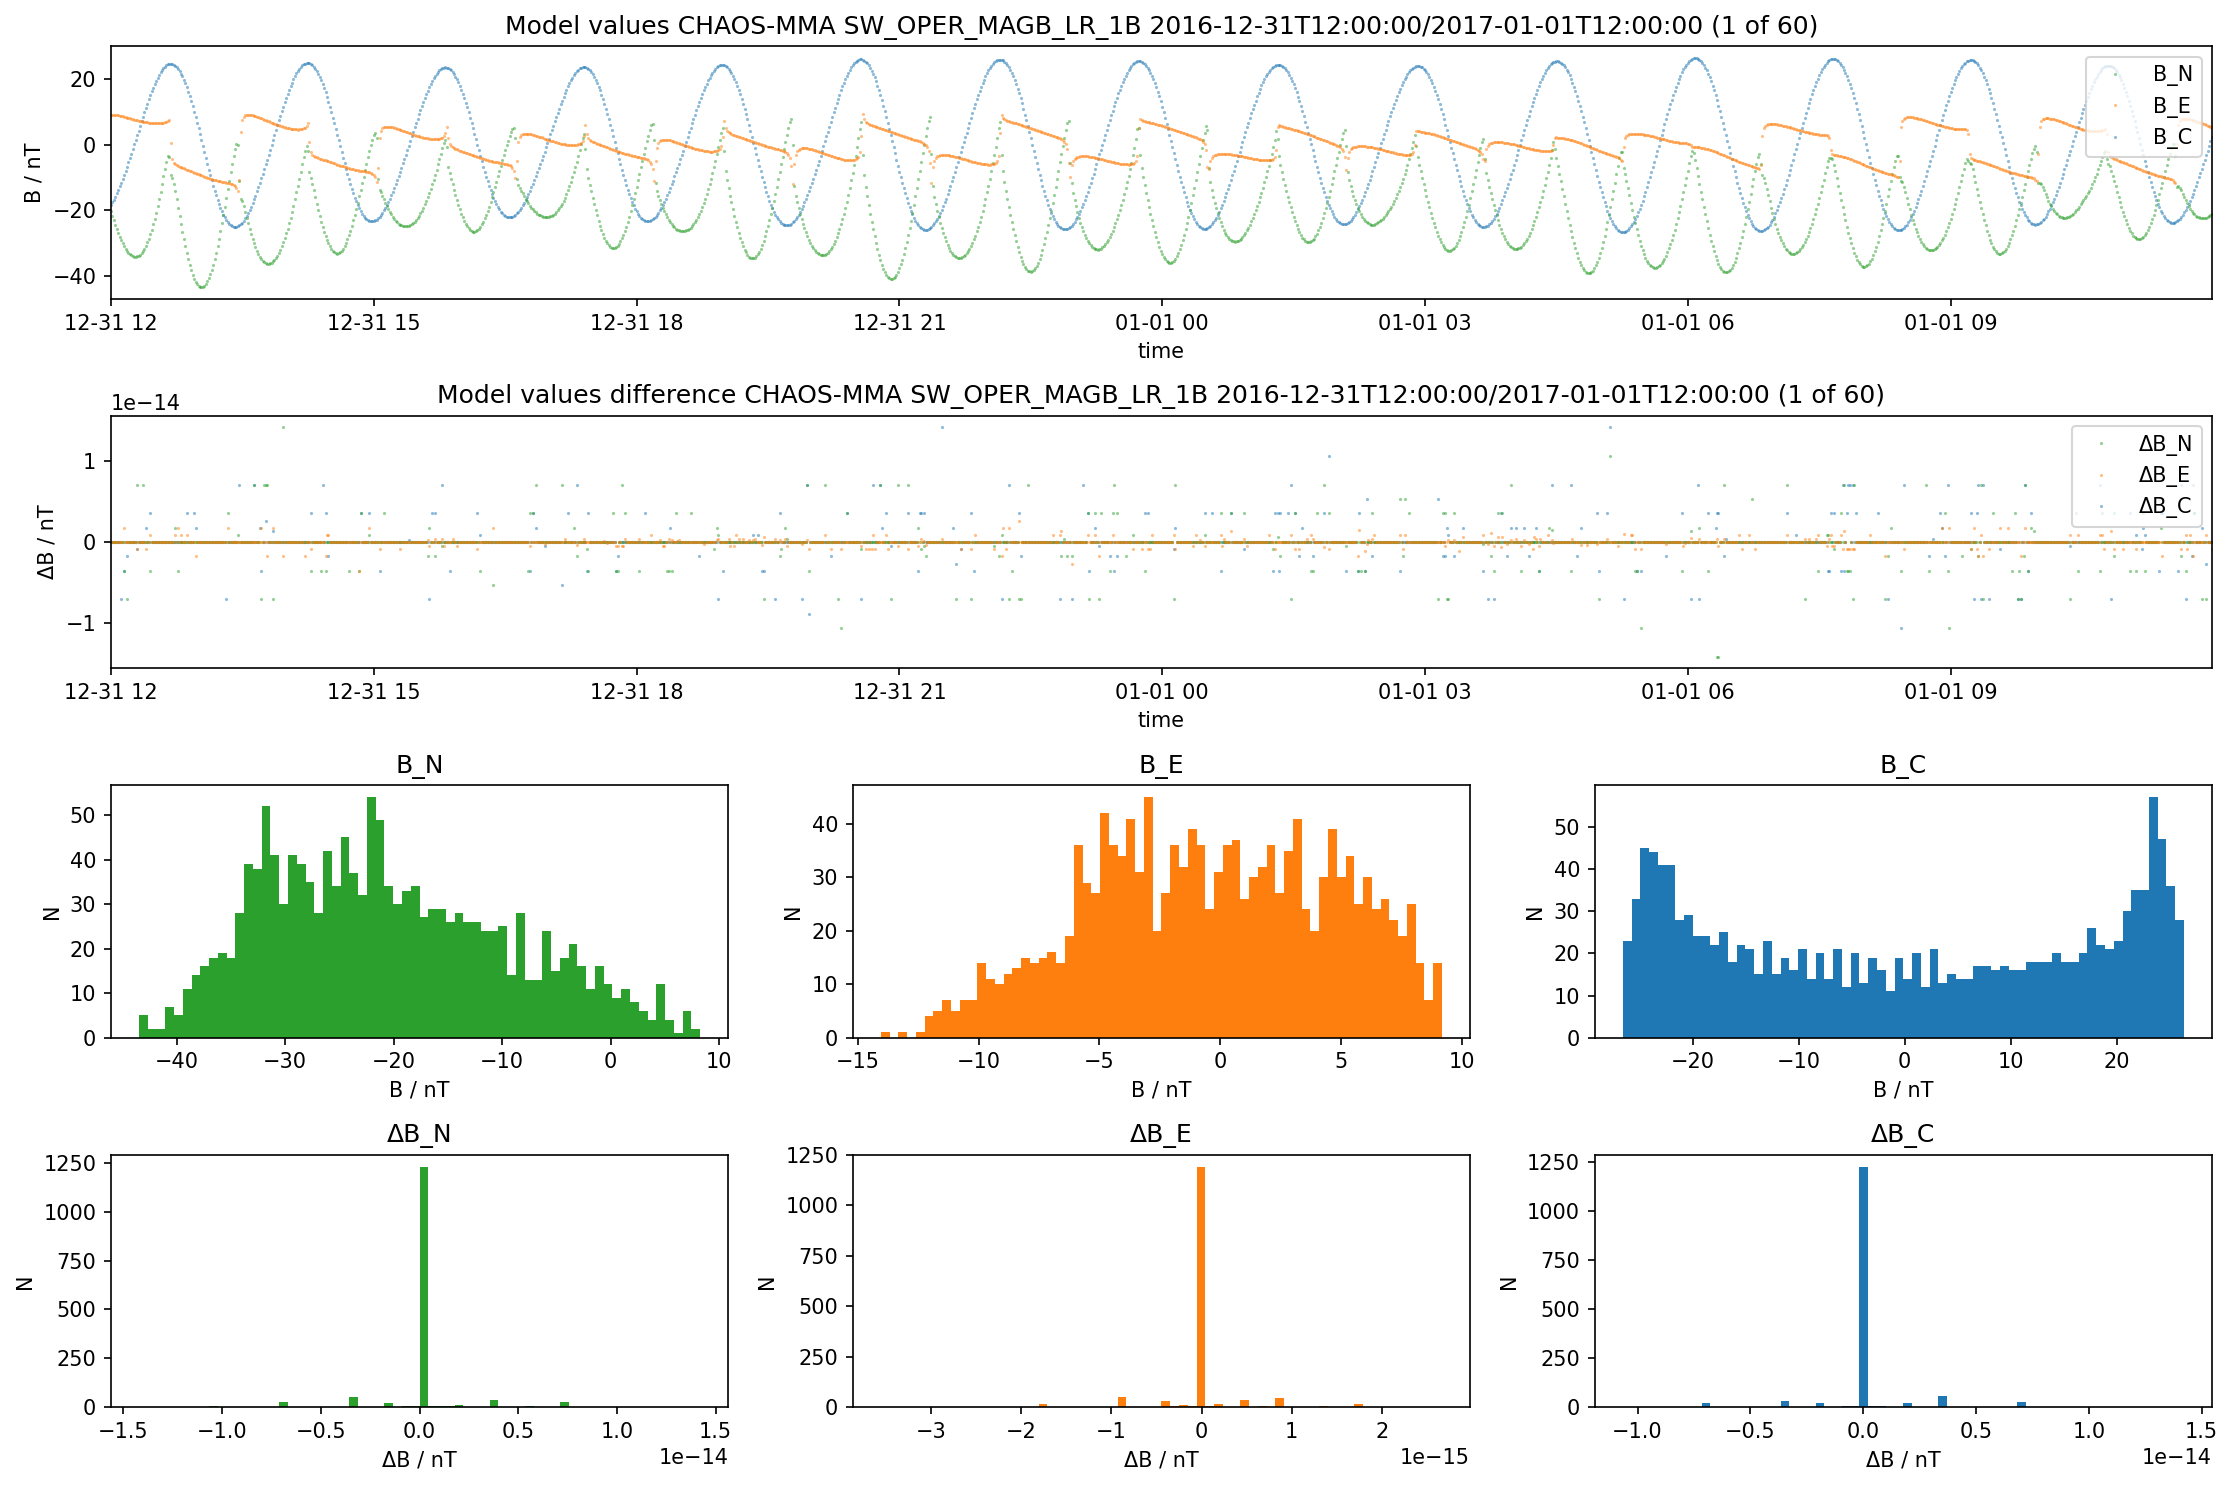

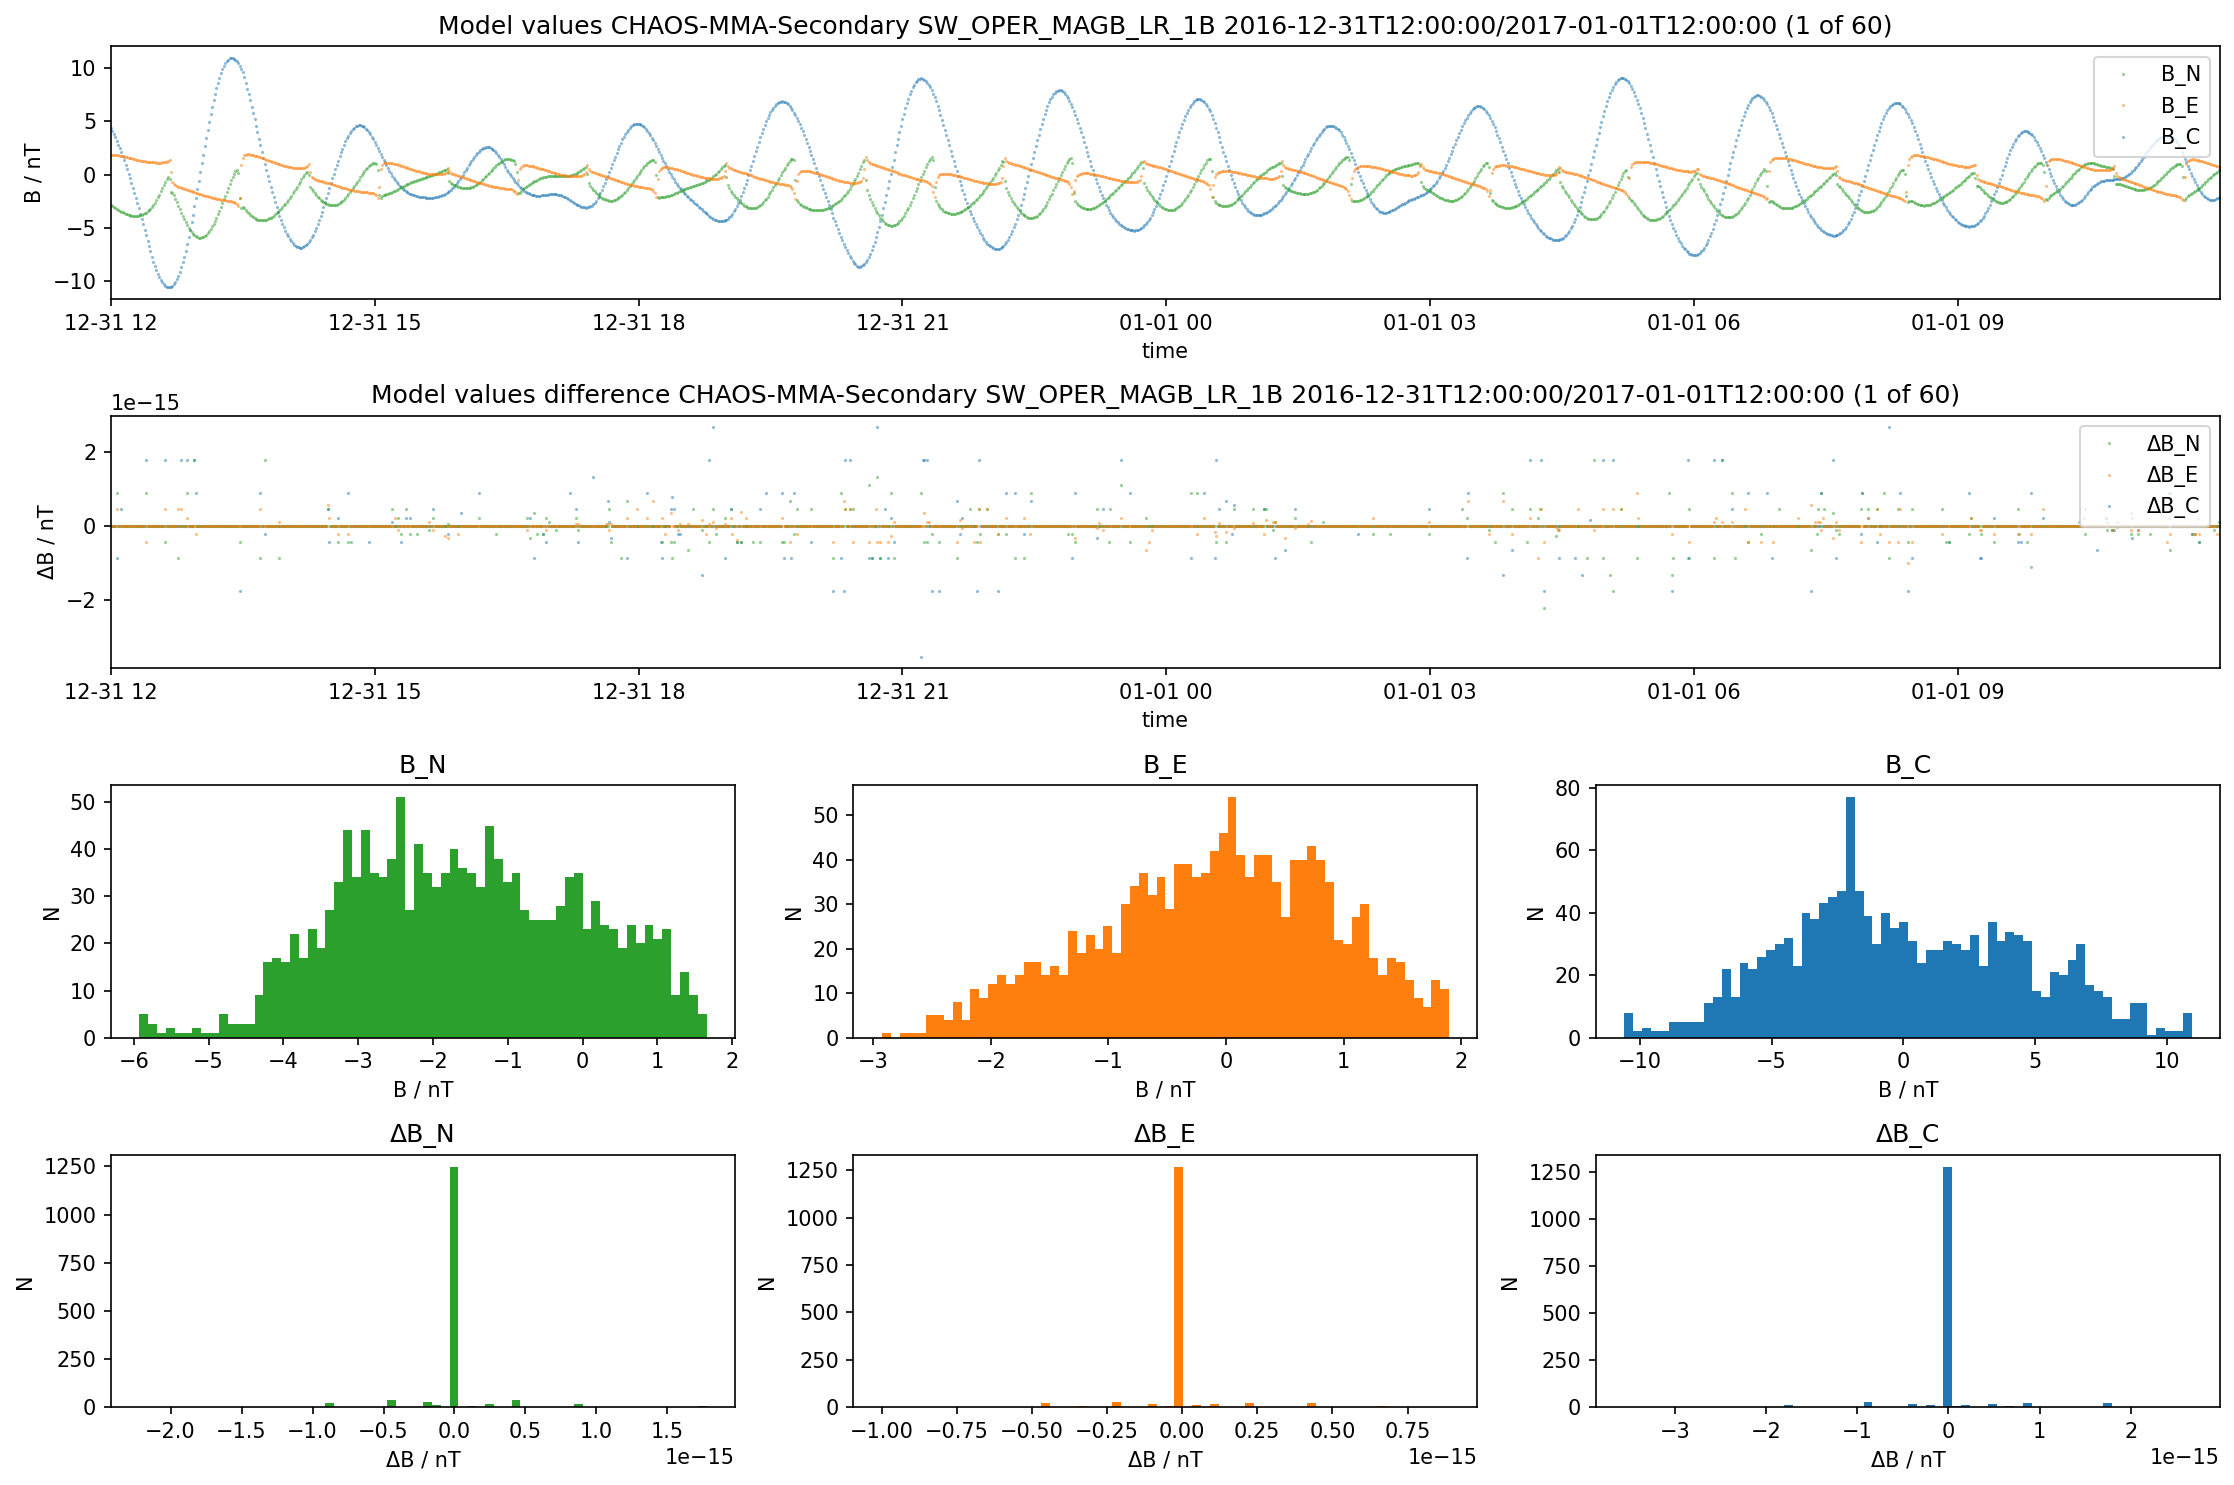

In [3]:
from matplotlib.pyplot import figure, subplot

def _plot_data(ax, x, y):
    options = {"ms": 1, "alpha": 0.5}
    h_c, = ax.plot(x, y[:,2], '.', color="tab:blue", **options)
    h_n, = ax.plot(x, y[:,0], '.', color="tab:green", **options)
    h_e, = ax.plot(x, y[:,1], '.', color="tab:orange", **options)
    return h_n, h_e, h_c


def plot_cdf(ax, data, name):
    handlers = _plot_data(ax, data["Timestamp"], data["cdf"][name])    
    ax.set_xlim([data["Timestamp"].min(), data["Timestamp"].max()])
    ax.set_xlabel("time")
    ax.set_ylabel("B / nT")
    ax.set_title(f"Model values {name} {data['info']['collection']} {data['info']['start']}/{data['info']['end']} (1 of 60)")
    ax.legend(handlers, ["B_N", "B_E", "B_C"], loc="upper right")


def plot_delta(ax, data, name):
    handlers = _plot_data(ax, data["Timestamp"], data["tested"][name] - data["cdf"][name])
    ax.set_xlim([data["Timestamp"].min(), data["Timestamp"].max()])
    ax.set_xlabel("time")
    ax.set_ylabel("ΔB / nT")
    ax.set_title(f"Model values difference {name} {data['info']['collection']} {data['info']['start']}/{data['info']['end']} (1 of 60)")
    ax.legend(handlers, ["ΔB_N", "ΔB_E", "ΔB_C"], loc="upper right")

    
def plot_cdf_histogram(ax, data, name, idx, label, **options):
    ax.hist(data["cdf"][name][:,idx], bins=64, **options)
    ax.set_title(label)
    ax.set_xlabel("B / nT")
    ax.set_ylabel("N")

    
def plot_delta_histogram(ax, data, name, idx, label, **options):
    ax.hist(data["tested"][name][:,idx] - data["cdf"][name][:,idx], bins=64, **options)
    ax.set_title(label)
    ax.set_xlabel("ΔB / nT")
    ax.set_ylabel("N")

    
model_names = data["info"]["model_names"]

for model_name in model_names:
    fig = figure(figsize=(15, 10), dpi=150)
    ax = subplot(4, 1, 1)
    plot_cdf(ax, data, model_name)
    ax = subplot(4, 1, 2)
    plot_delta(ax, data, model_name)
    ax = subplot(4, 3, 7)
    plot_cdf_histogram(ax, data, model_name, 0, "B_N", color="tab:green")
    ax = subplot(4, 3, 8)
    plot_cdf_histogram(ax, data, model_name, 1, "B_E", color="tab:orange")
    ax = subplot(4, 3, 9)
    plot_cdf_histogram(ax, data, model_name, 2, "B_C", color="tab:blue")
    ax = subplot(4, 3, 10)
    plot_delta_histogram(ax, data, model_name, 0, "ΔB_N", color="tab:green")
    ax = subplot(4, 3, 11)
    plot_delta_histogram(ax, data, model_name, 1, "ΔB_E", color="tab:orange")
    ax = subplot(4, 3, 12)
    plot_delta_histogram(ax, data, model_name, 2, "ΔB_C", color="tab:blue")
    fig.tight_layout()

## Difference between MJD2000 values

Comparison of the input MJD2000 time calculated from the xarray `datetime64[ns]` values and from the CDF_EPOCH values.

0.0


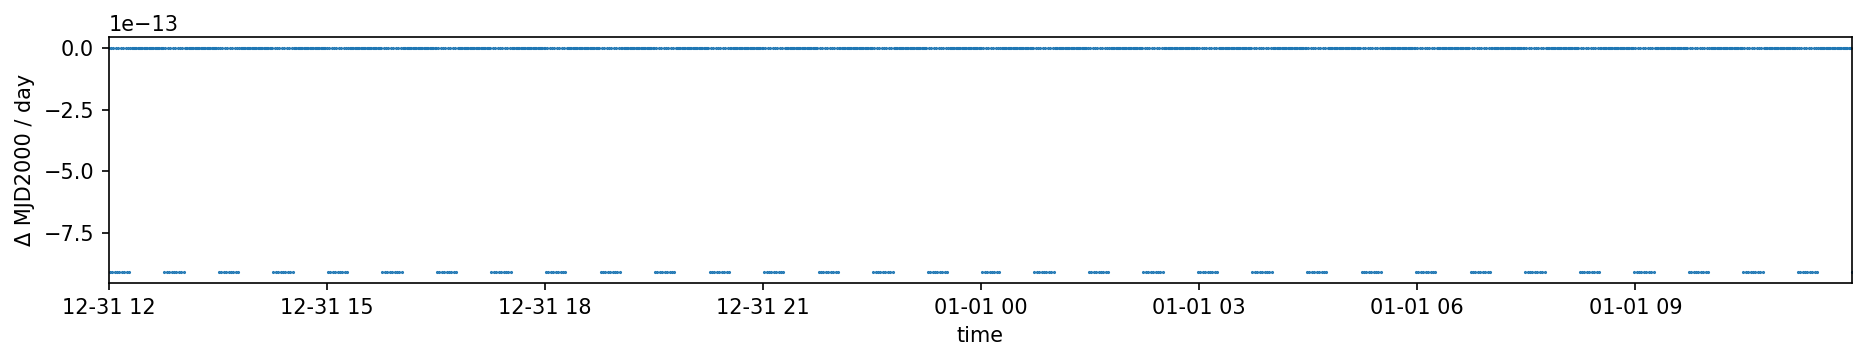

In [4]:
from matplotlib.pyplot import figure, subplot

fig = figure(figsize=(15, 10), dpi=150)

ax = subplot(4, 1, 1)
ax.plot(data['Timestamp'], data["local"]["inputs"]["times"] - data["cdf"]["inputs"]["times"], '.', ms=1)
ax.set_xlabel("time")
ax.set_ylabel("Δ MJD2000 / day")
ax.set_xlim([data["Timestamp"].min(), data["Timestamp"].max()])


print((data["local"]["inputs"]["times"] - data["cdf"]["inputs"]["times"]).max())

## Comparison of models calculated locally with different time conversion methods

Comparison of the models calculated for input MJD2000 time calculated from the xarray `datetime64[ns]` values and from the CDF_EPOCH values.

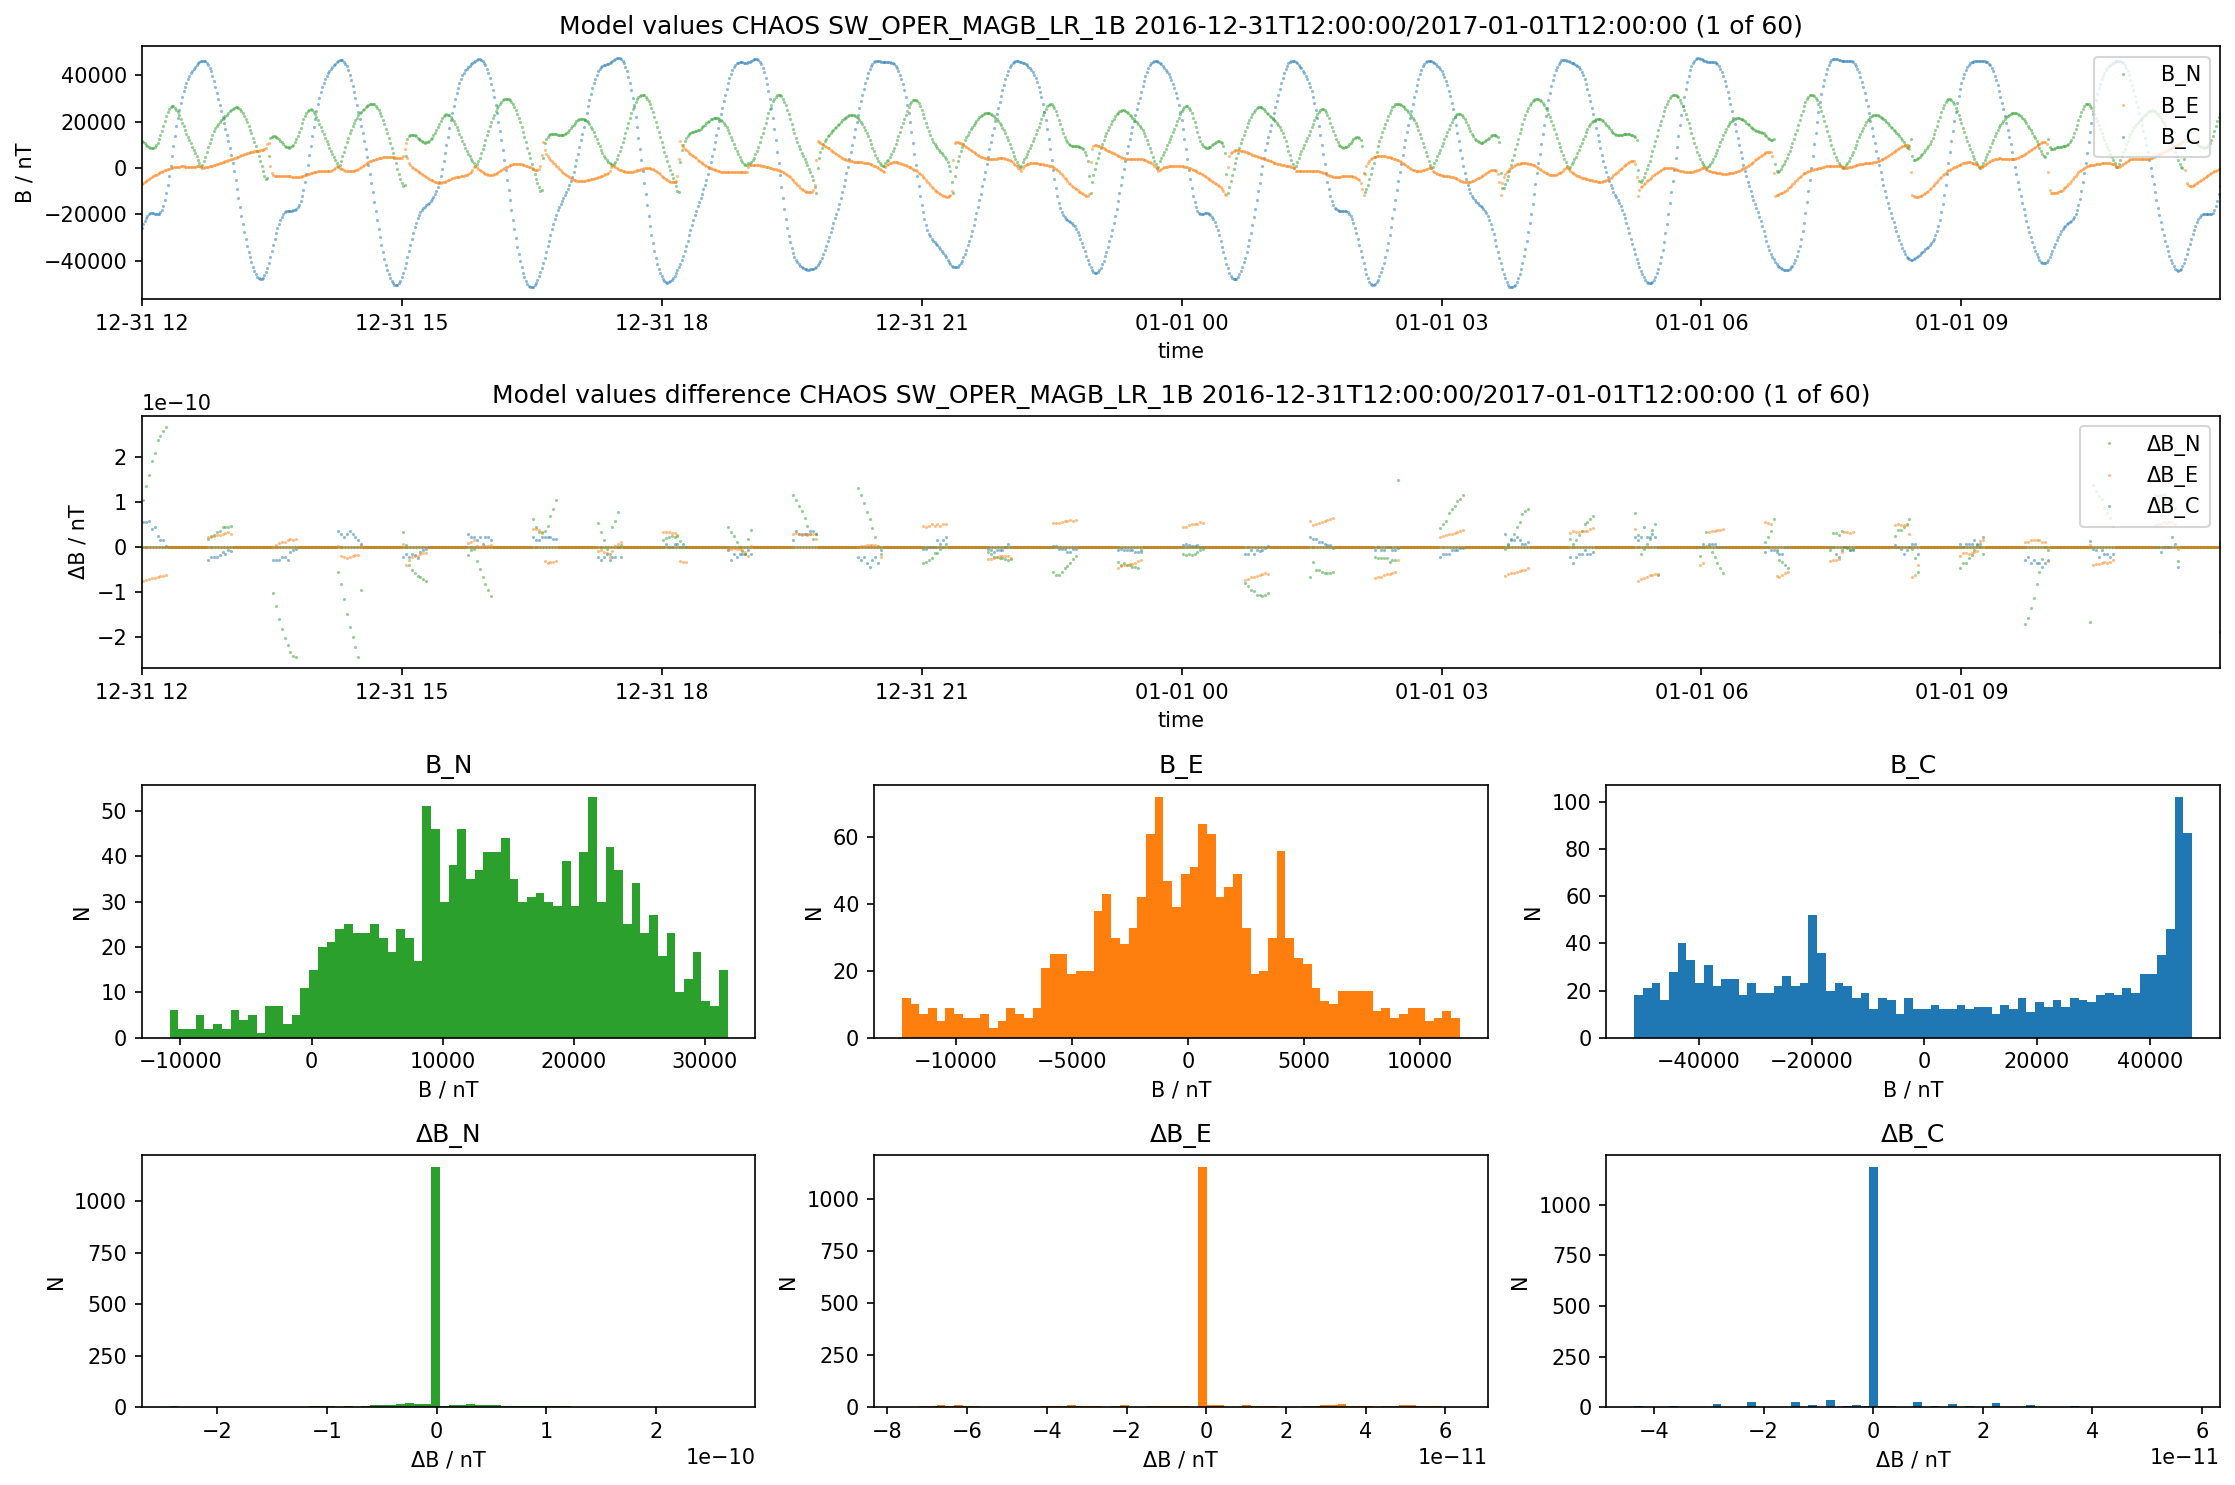

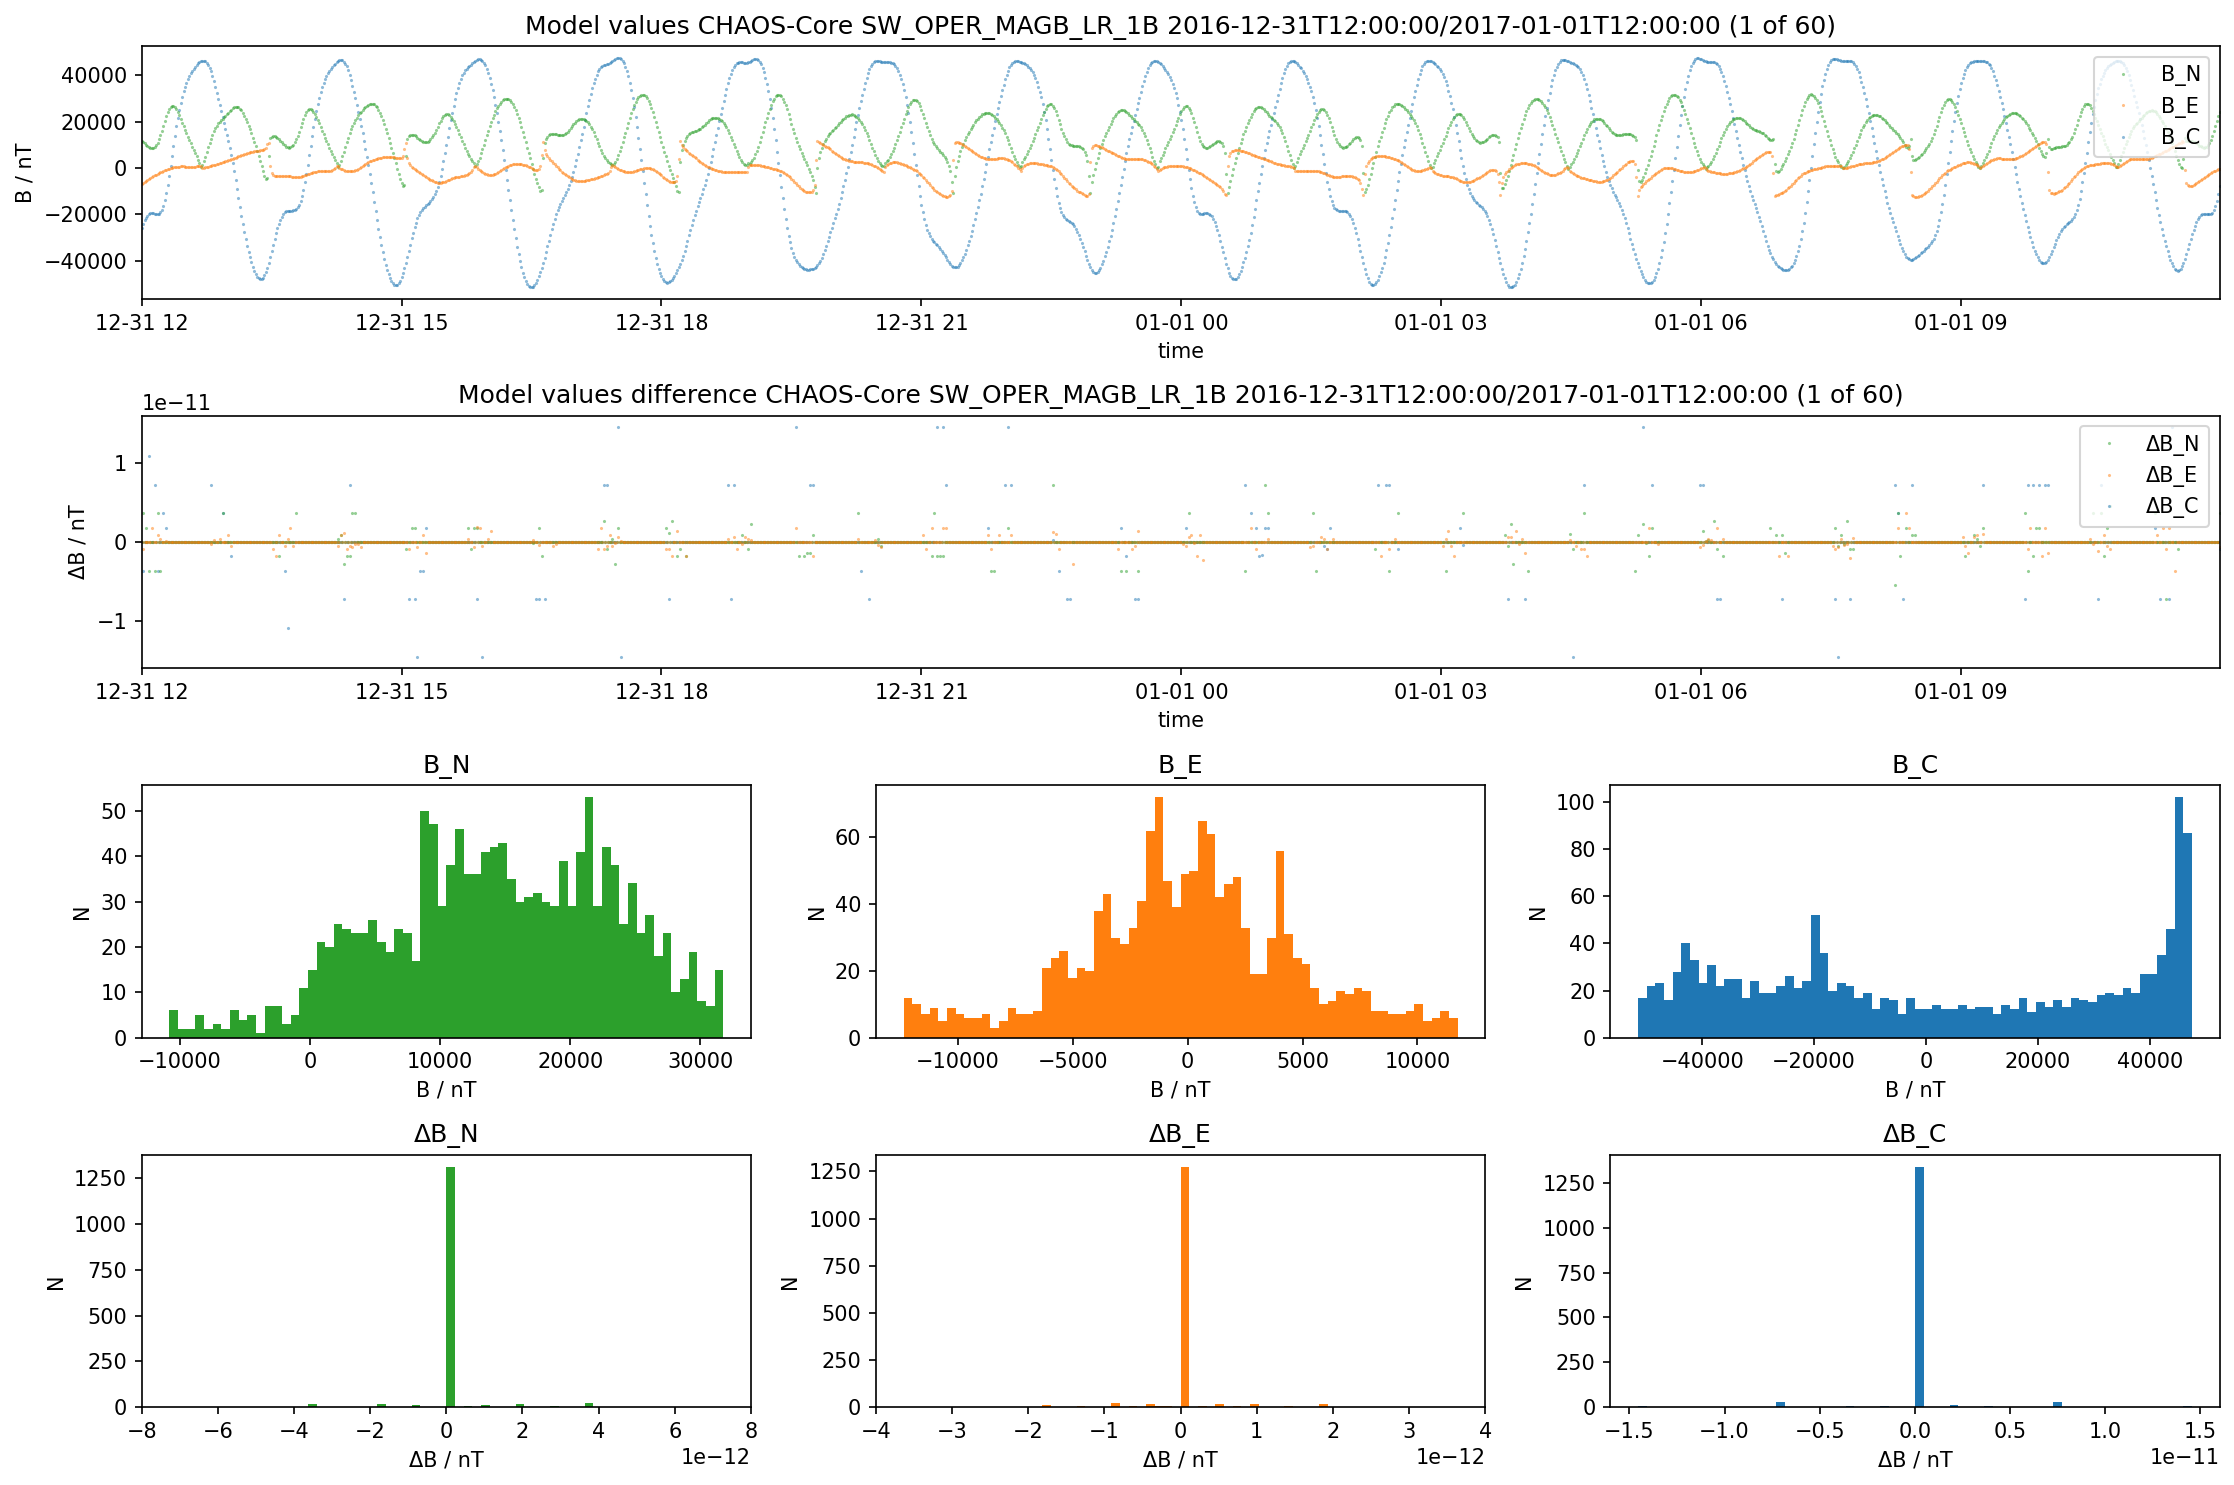

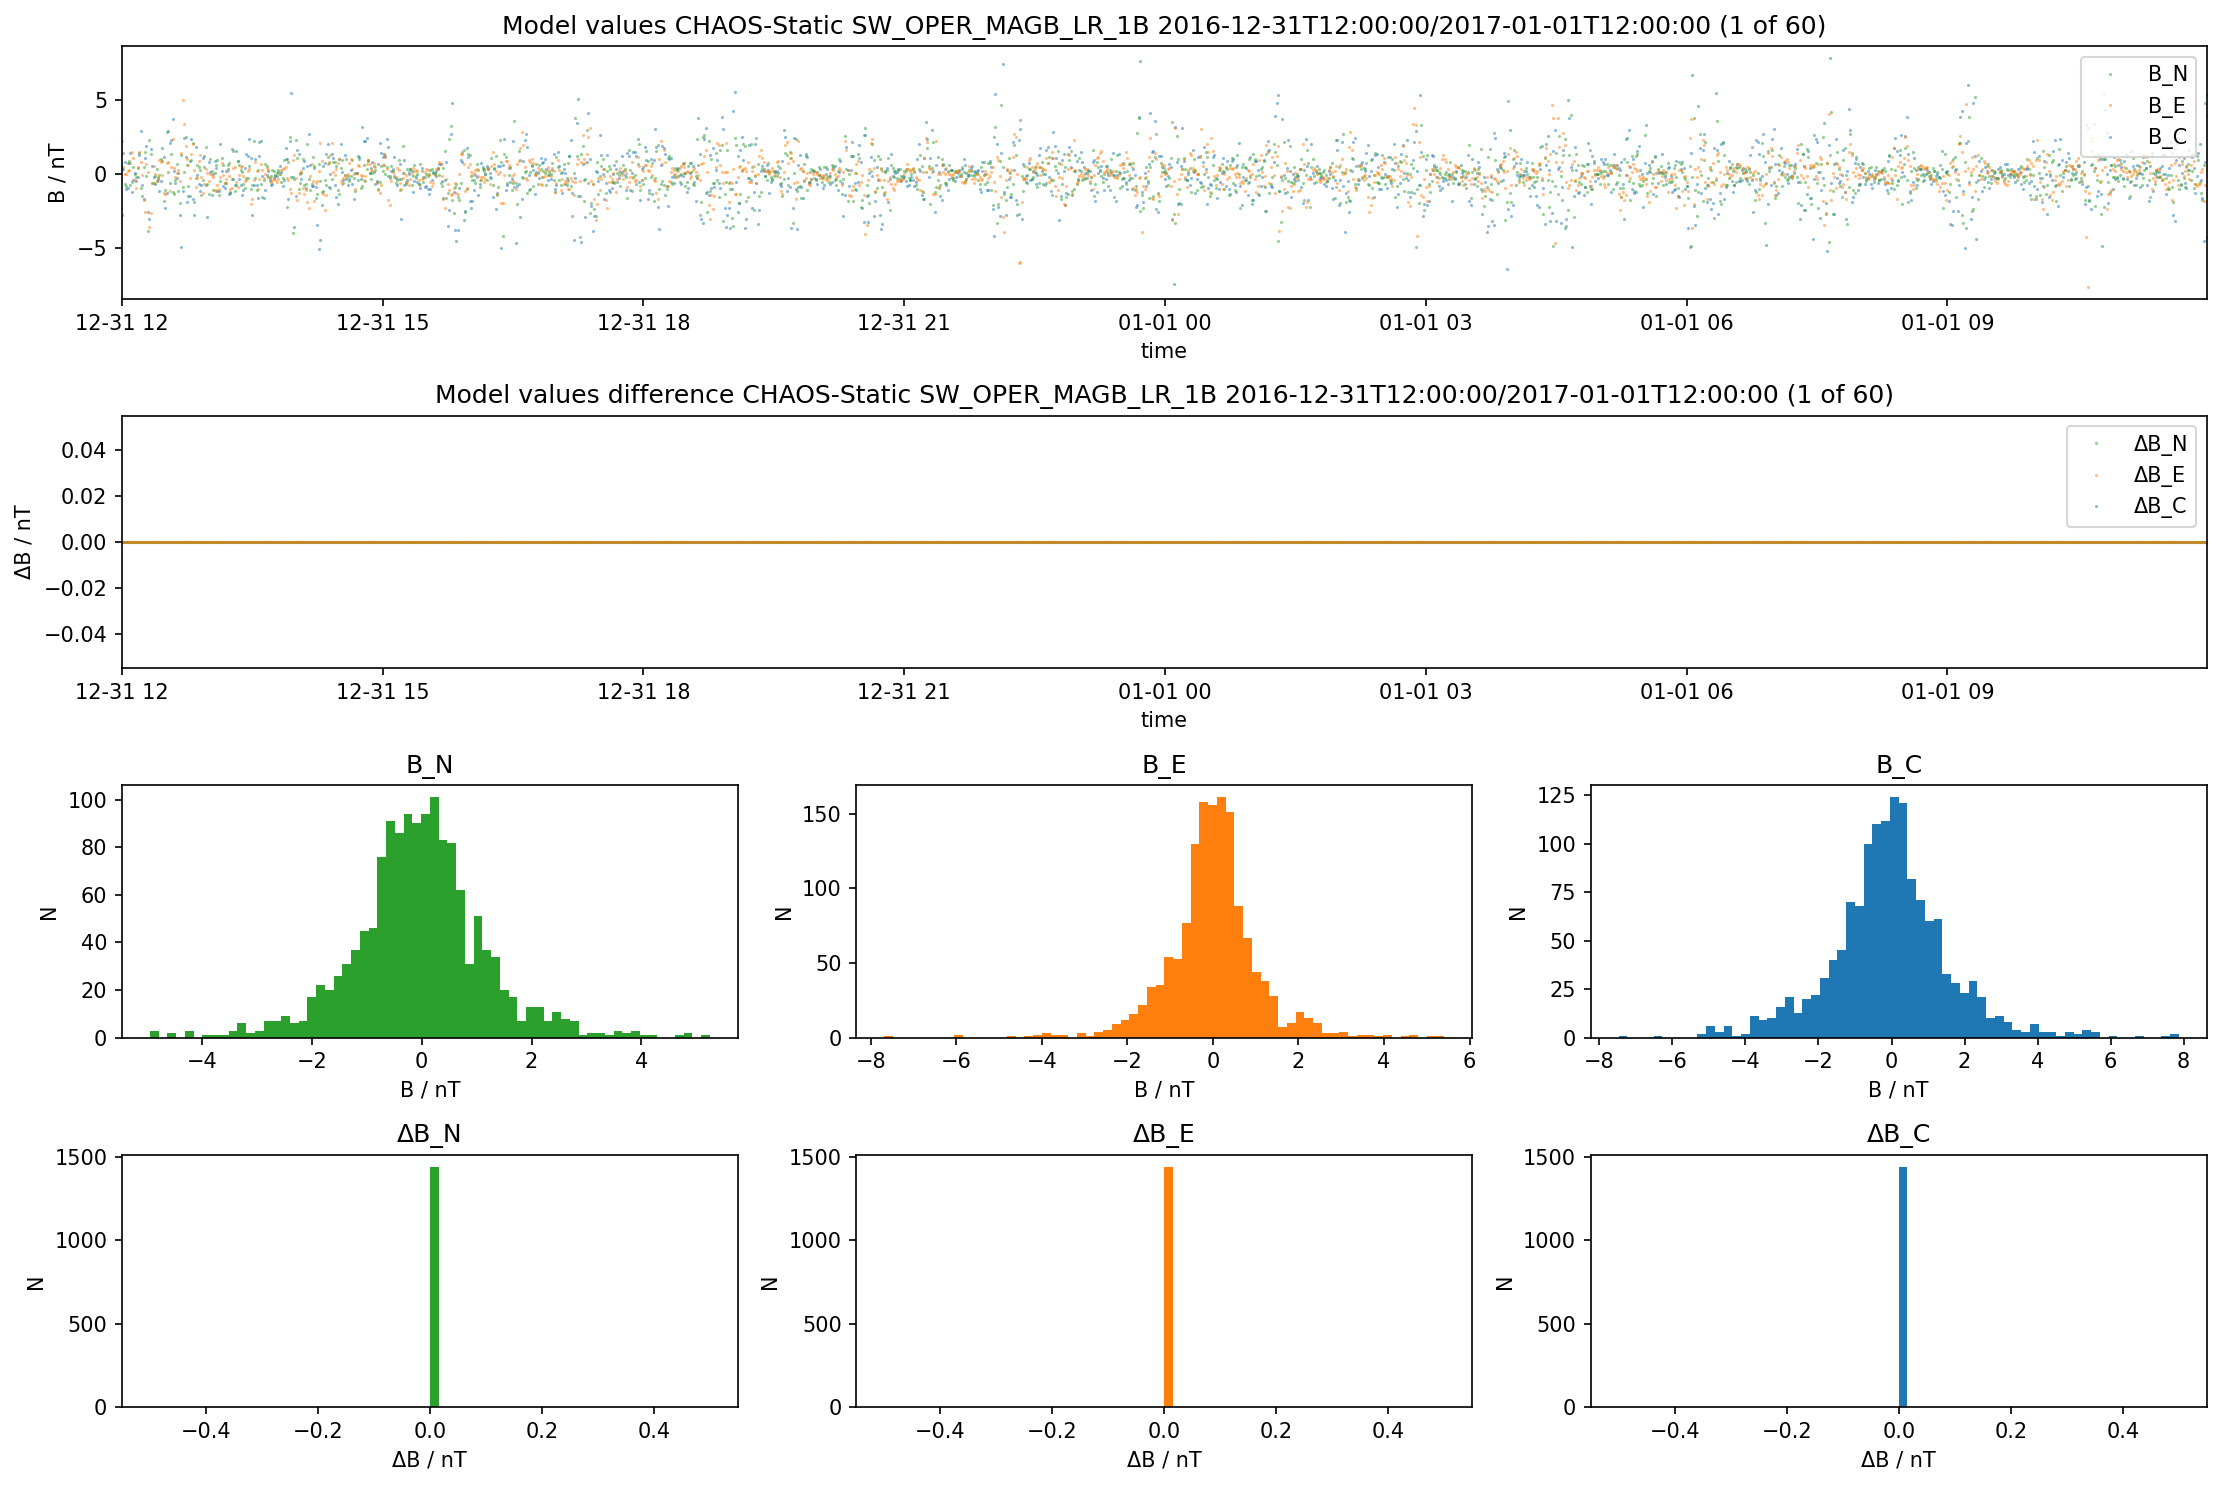

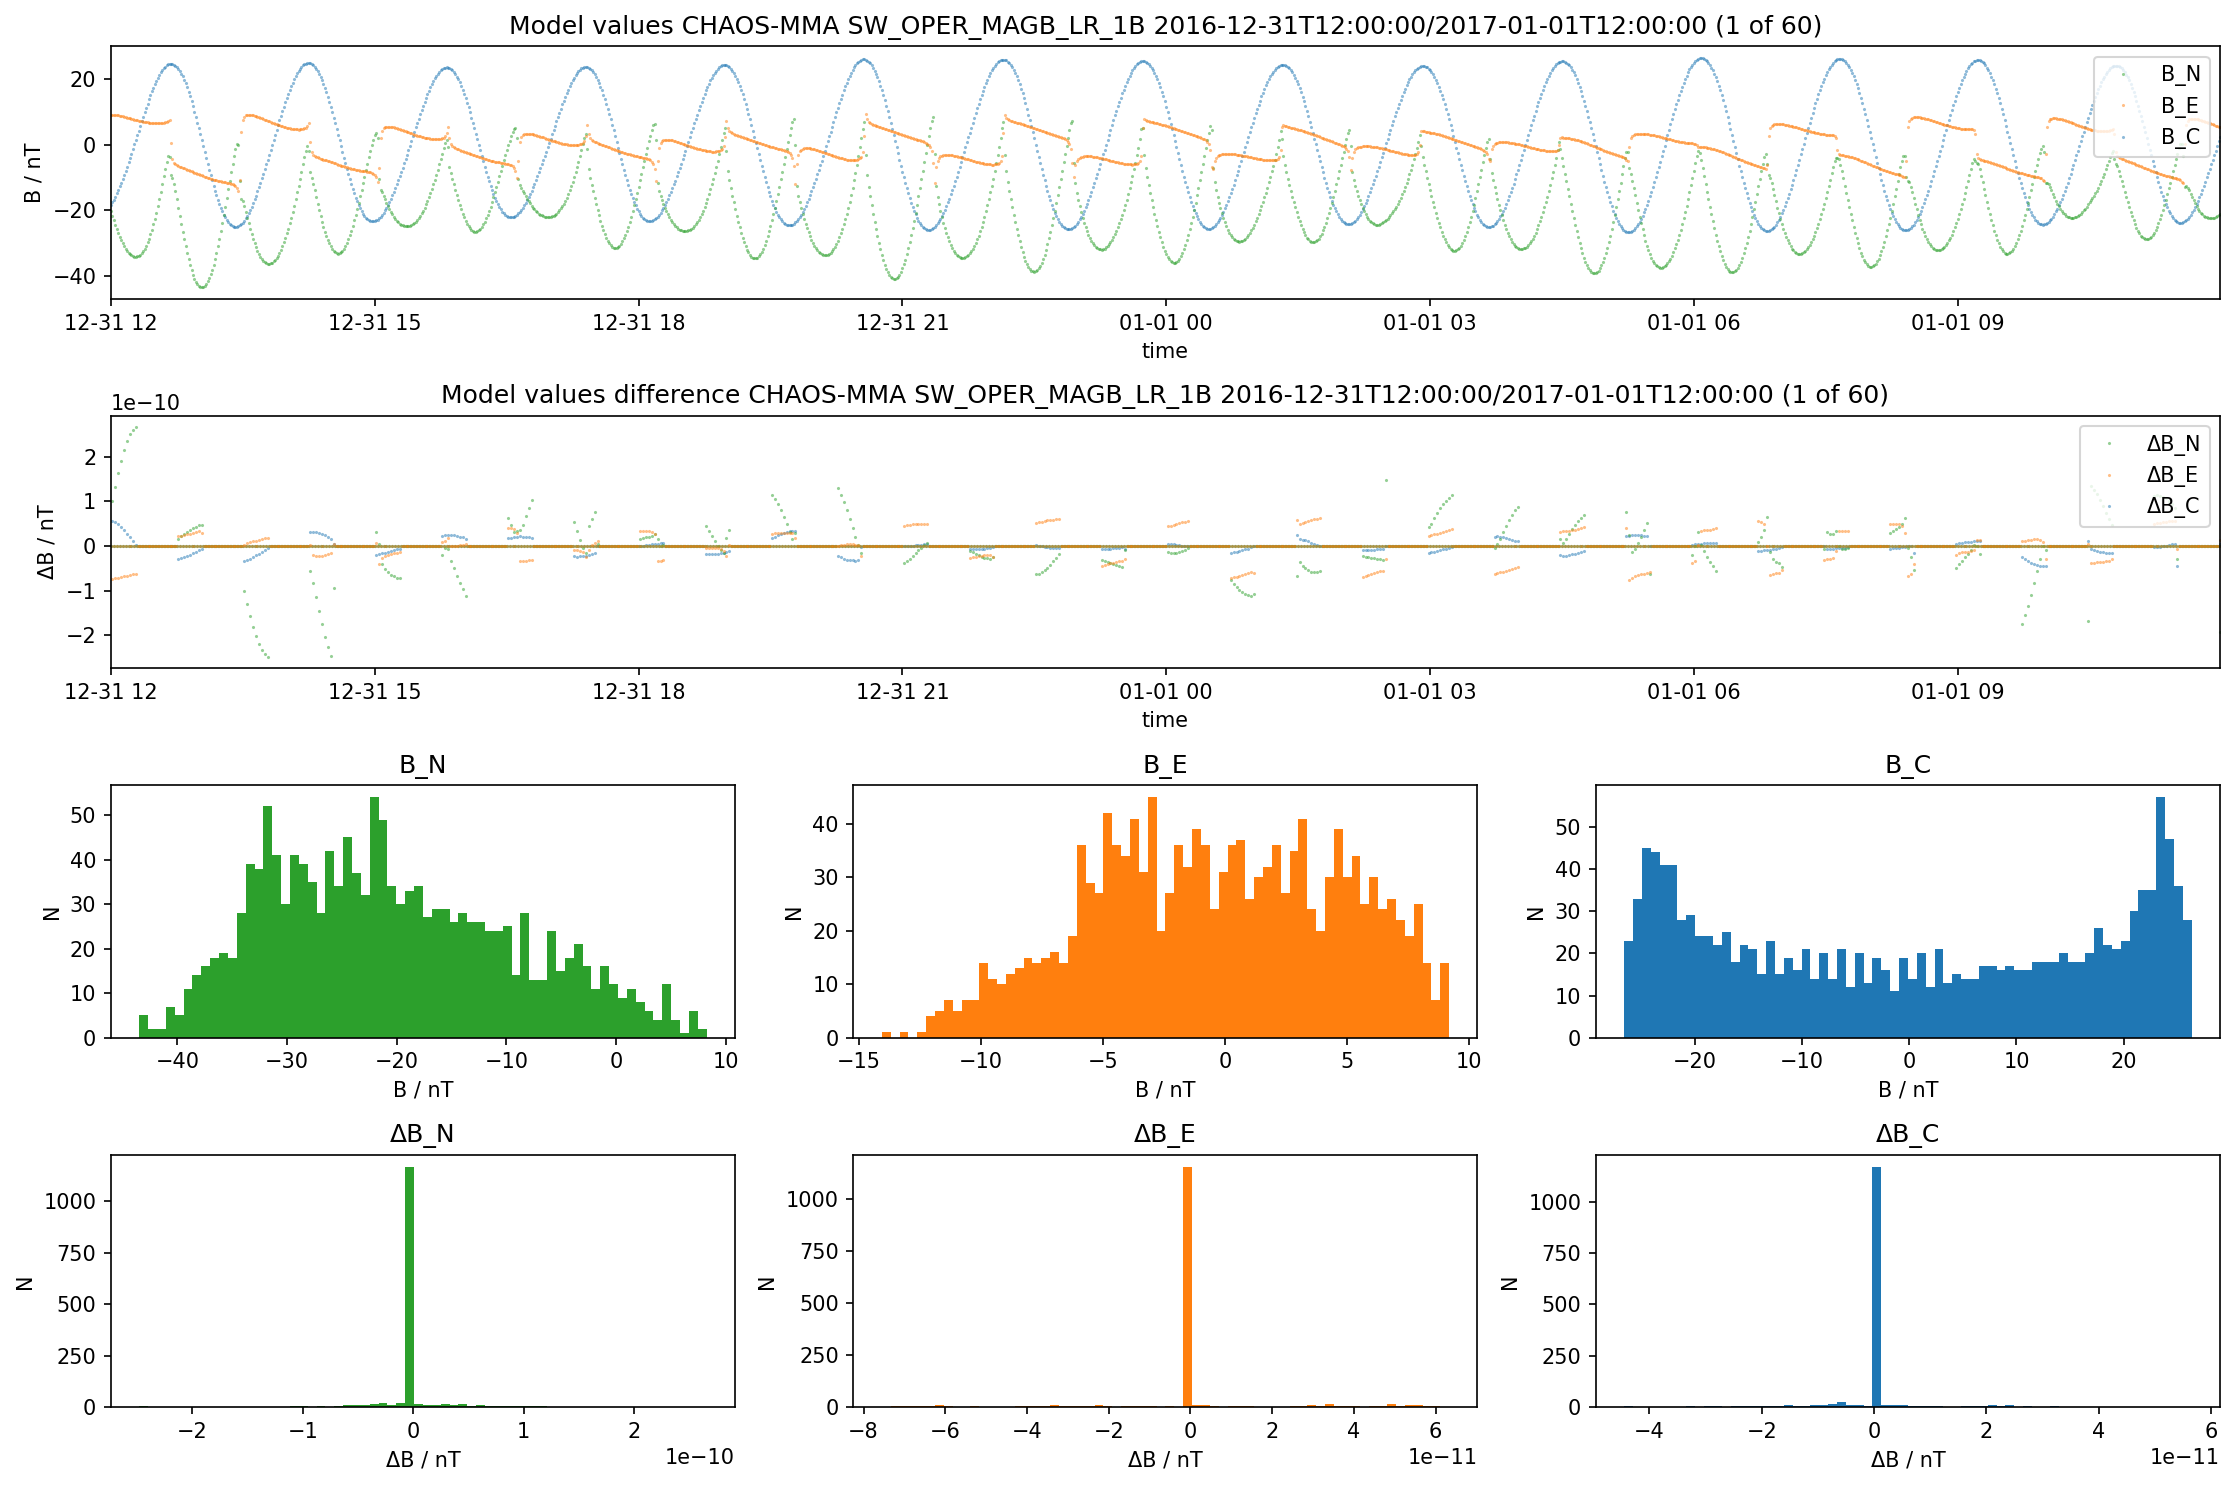

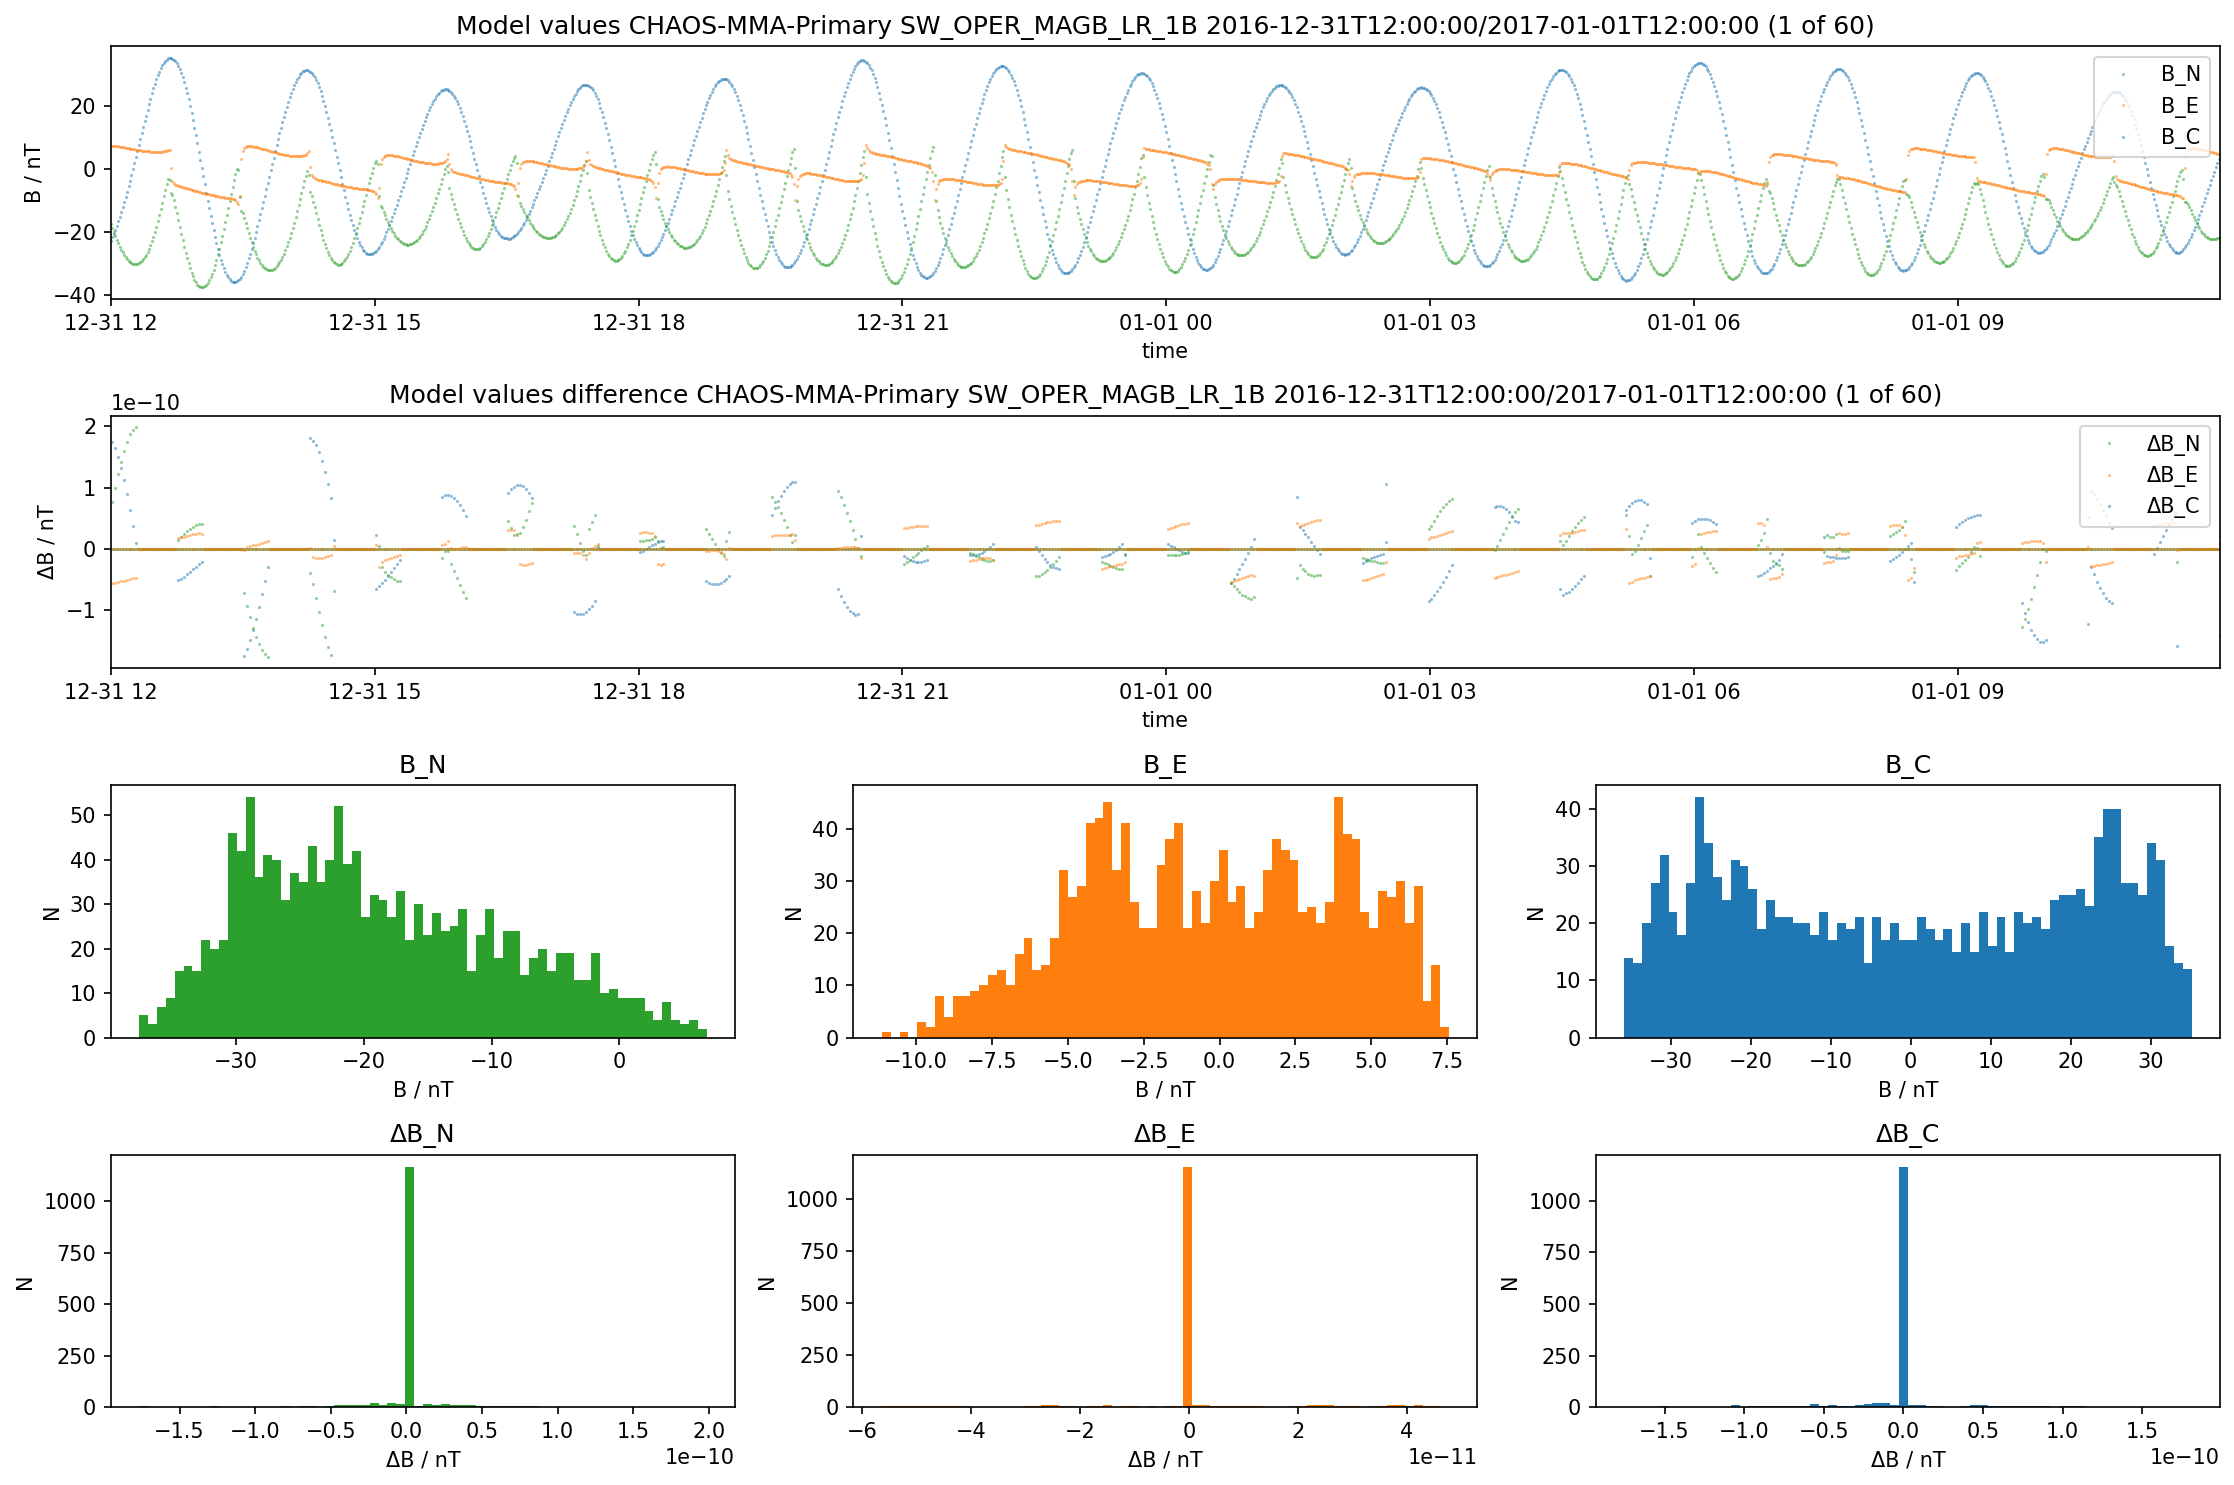

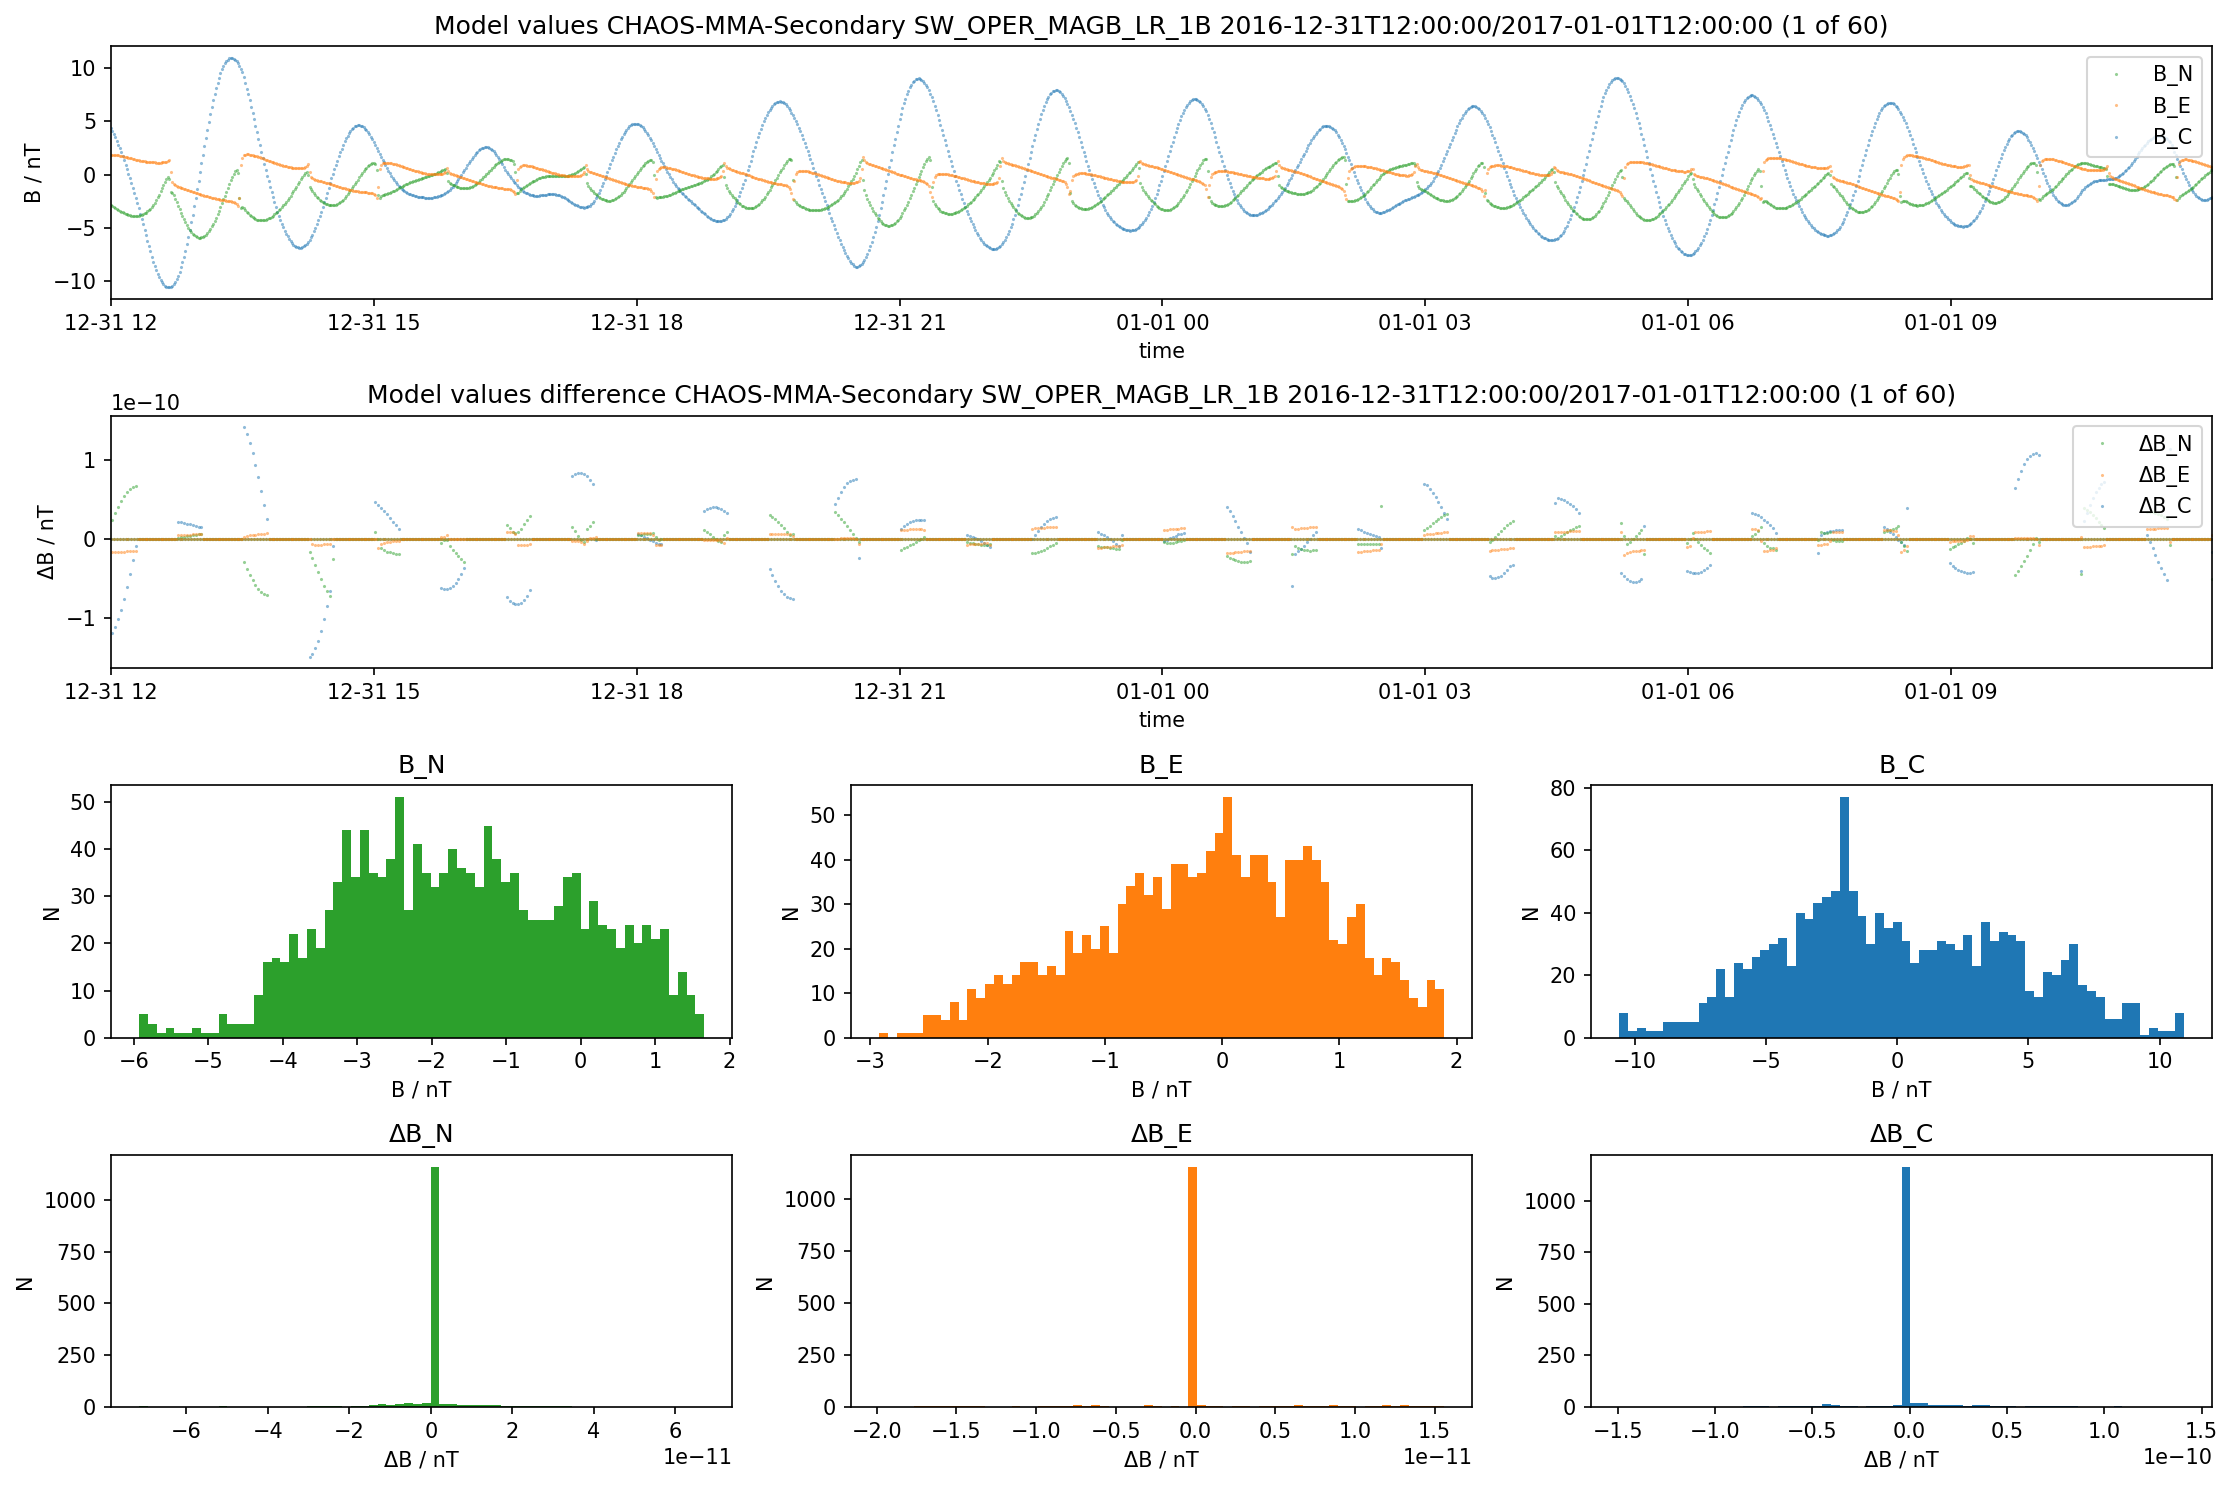

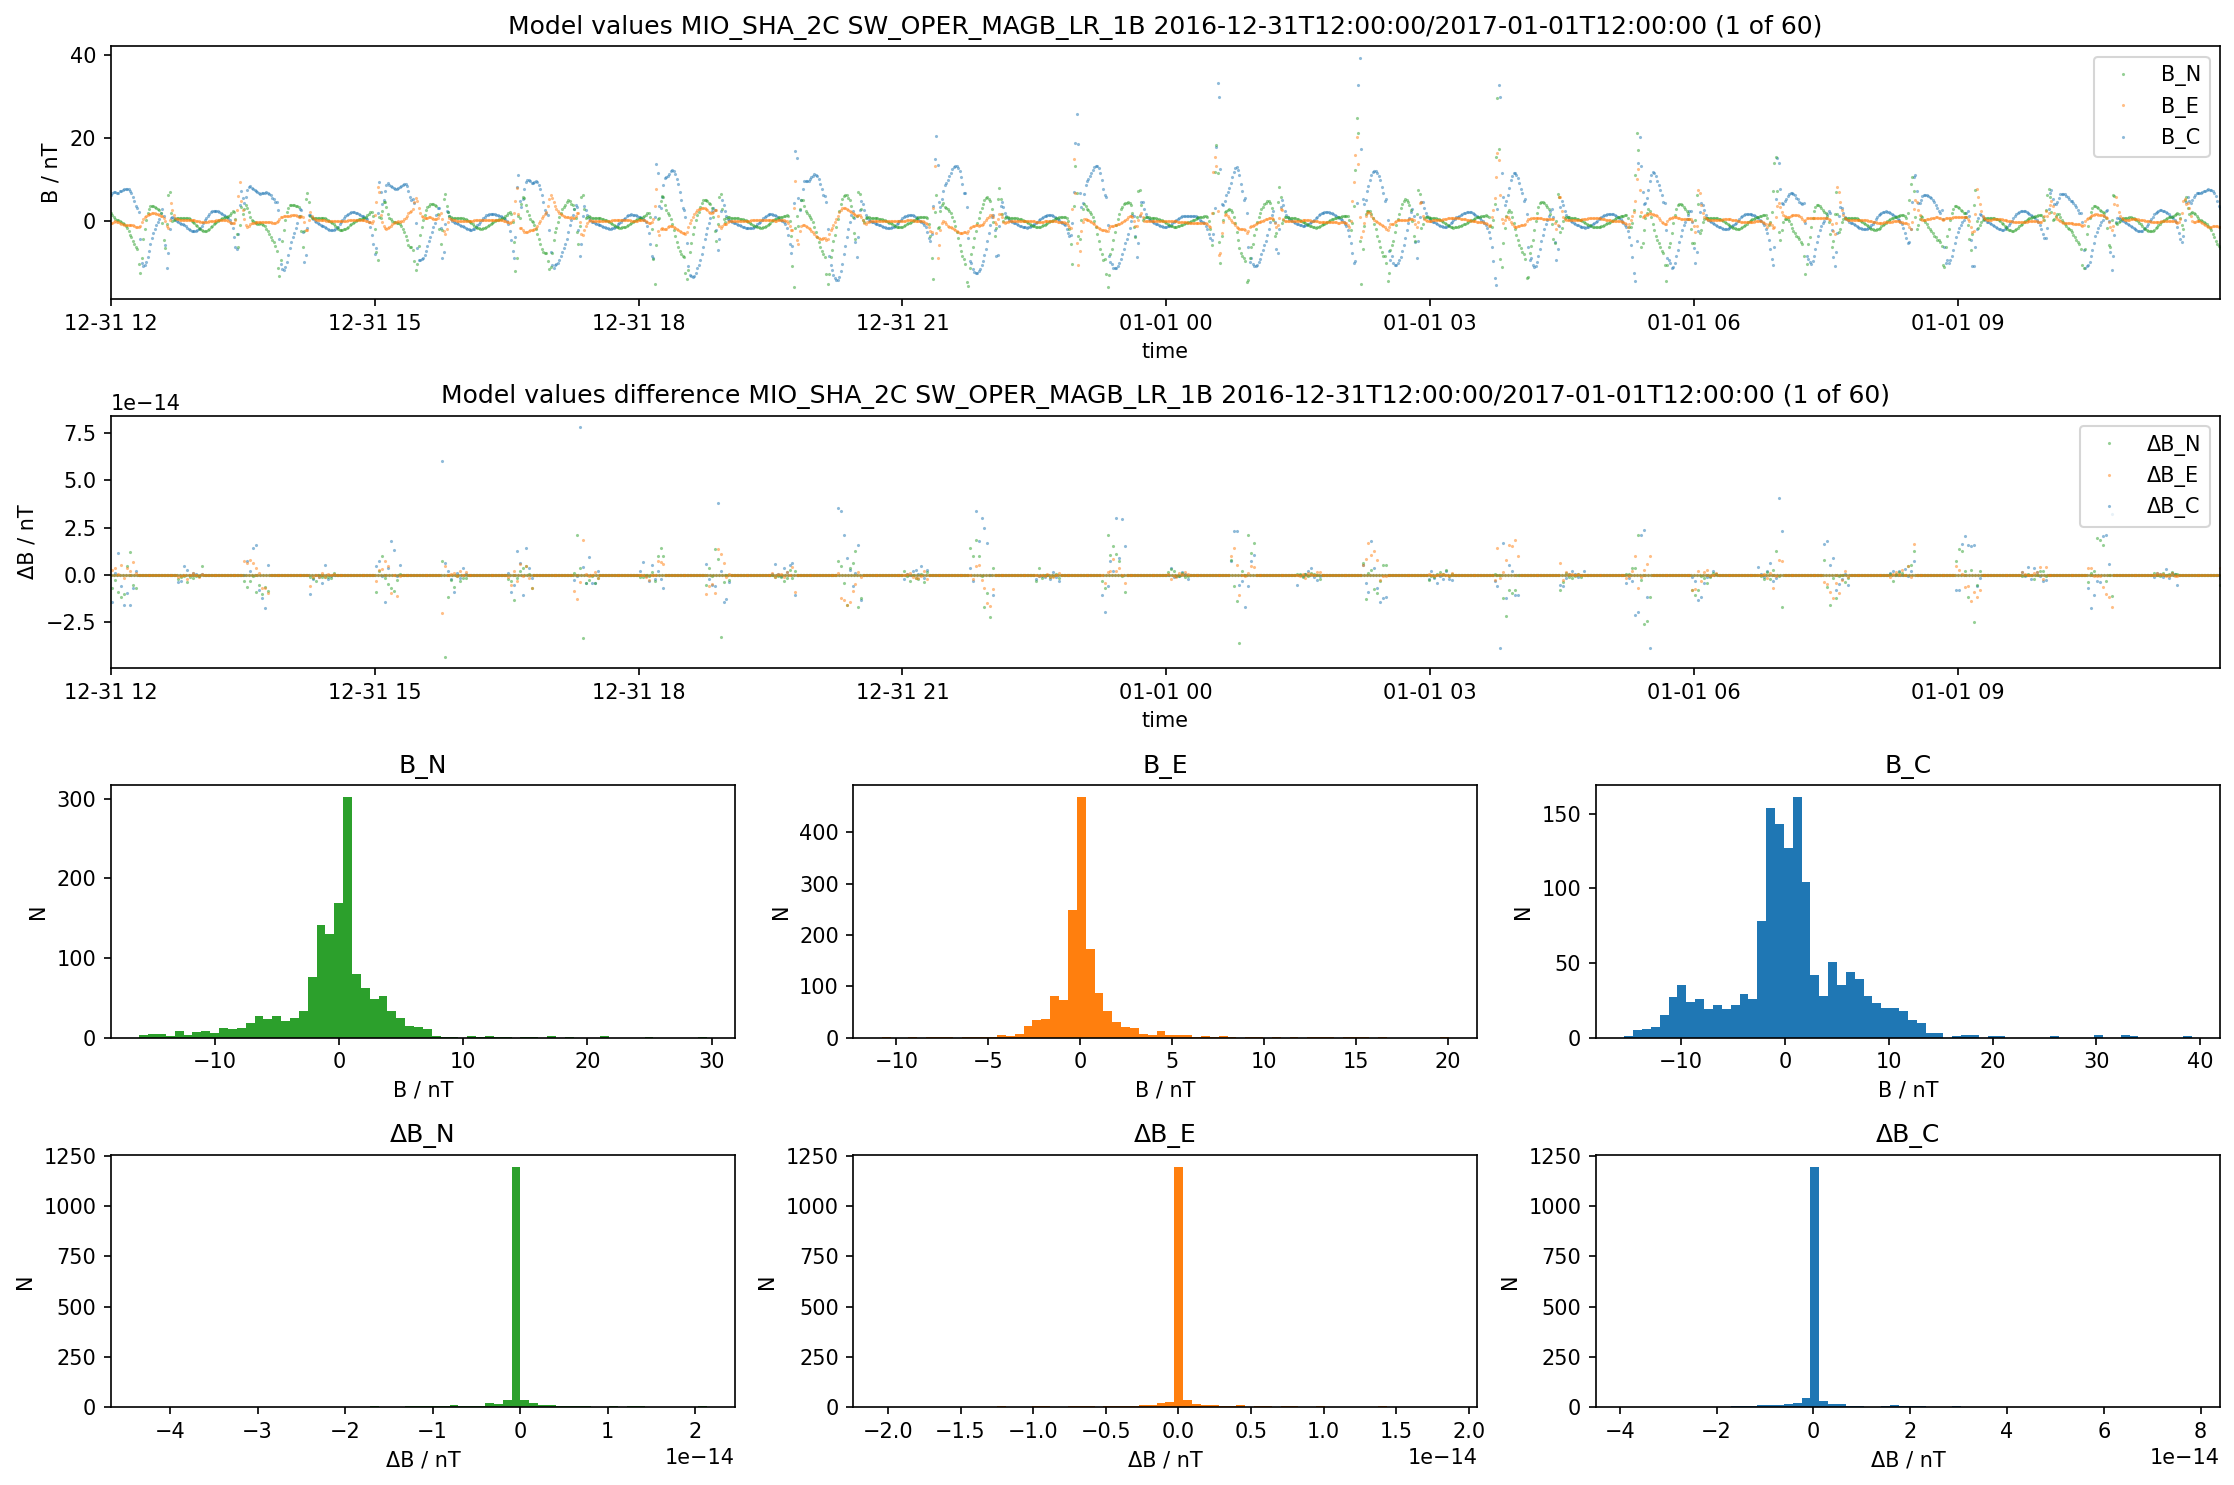

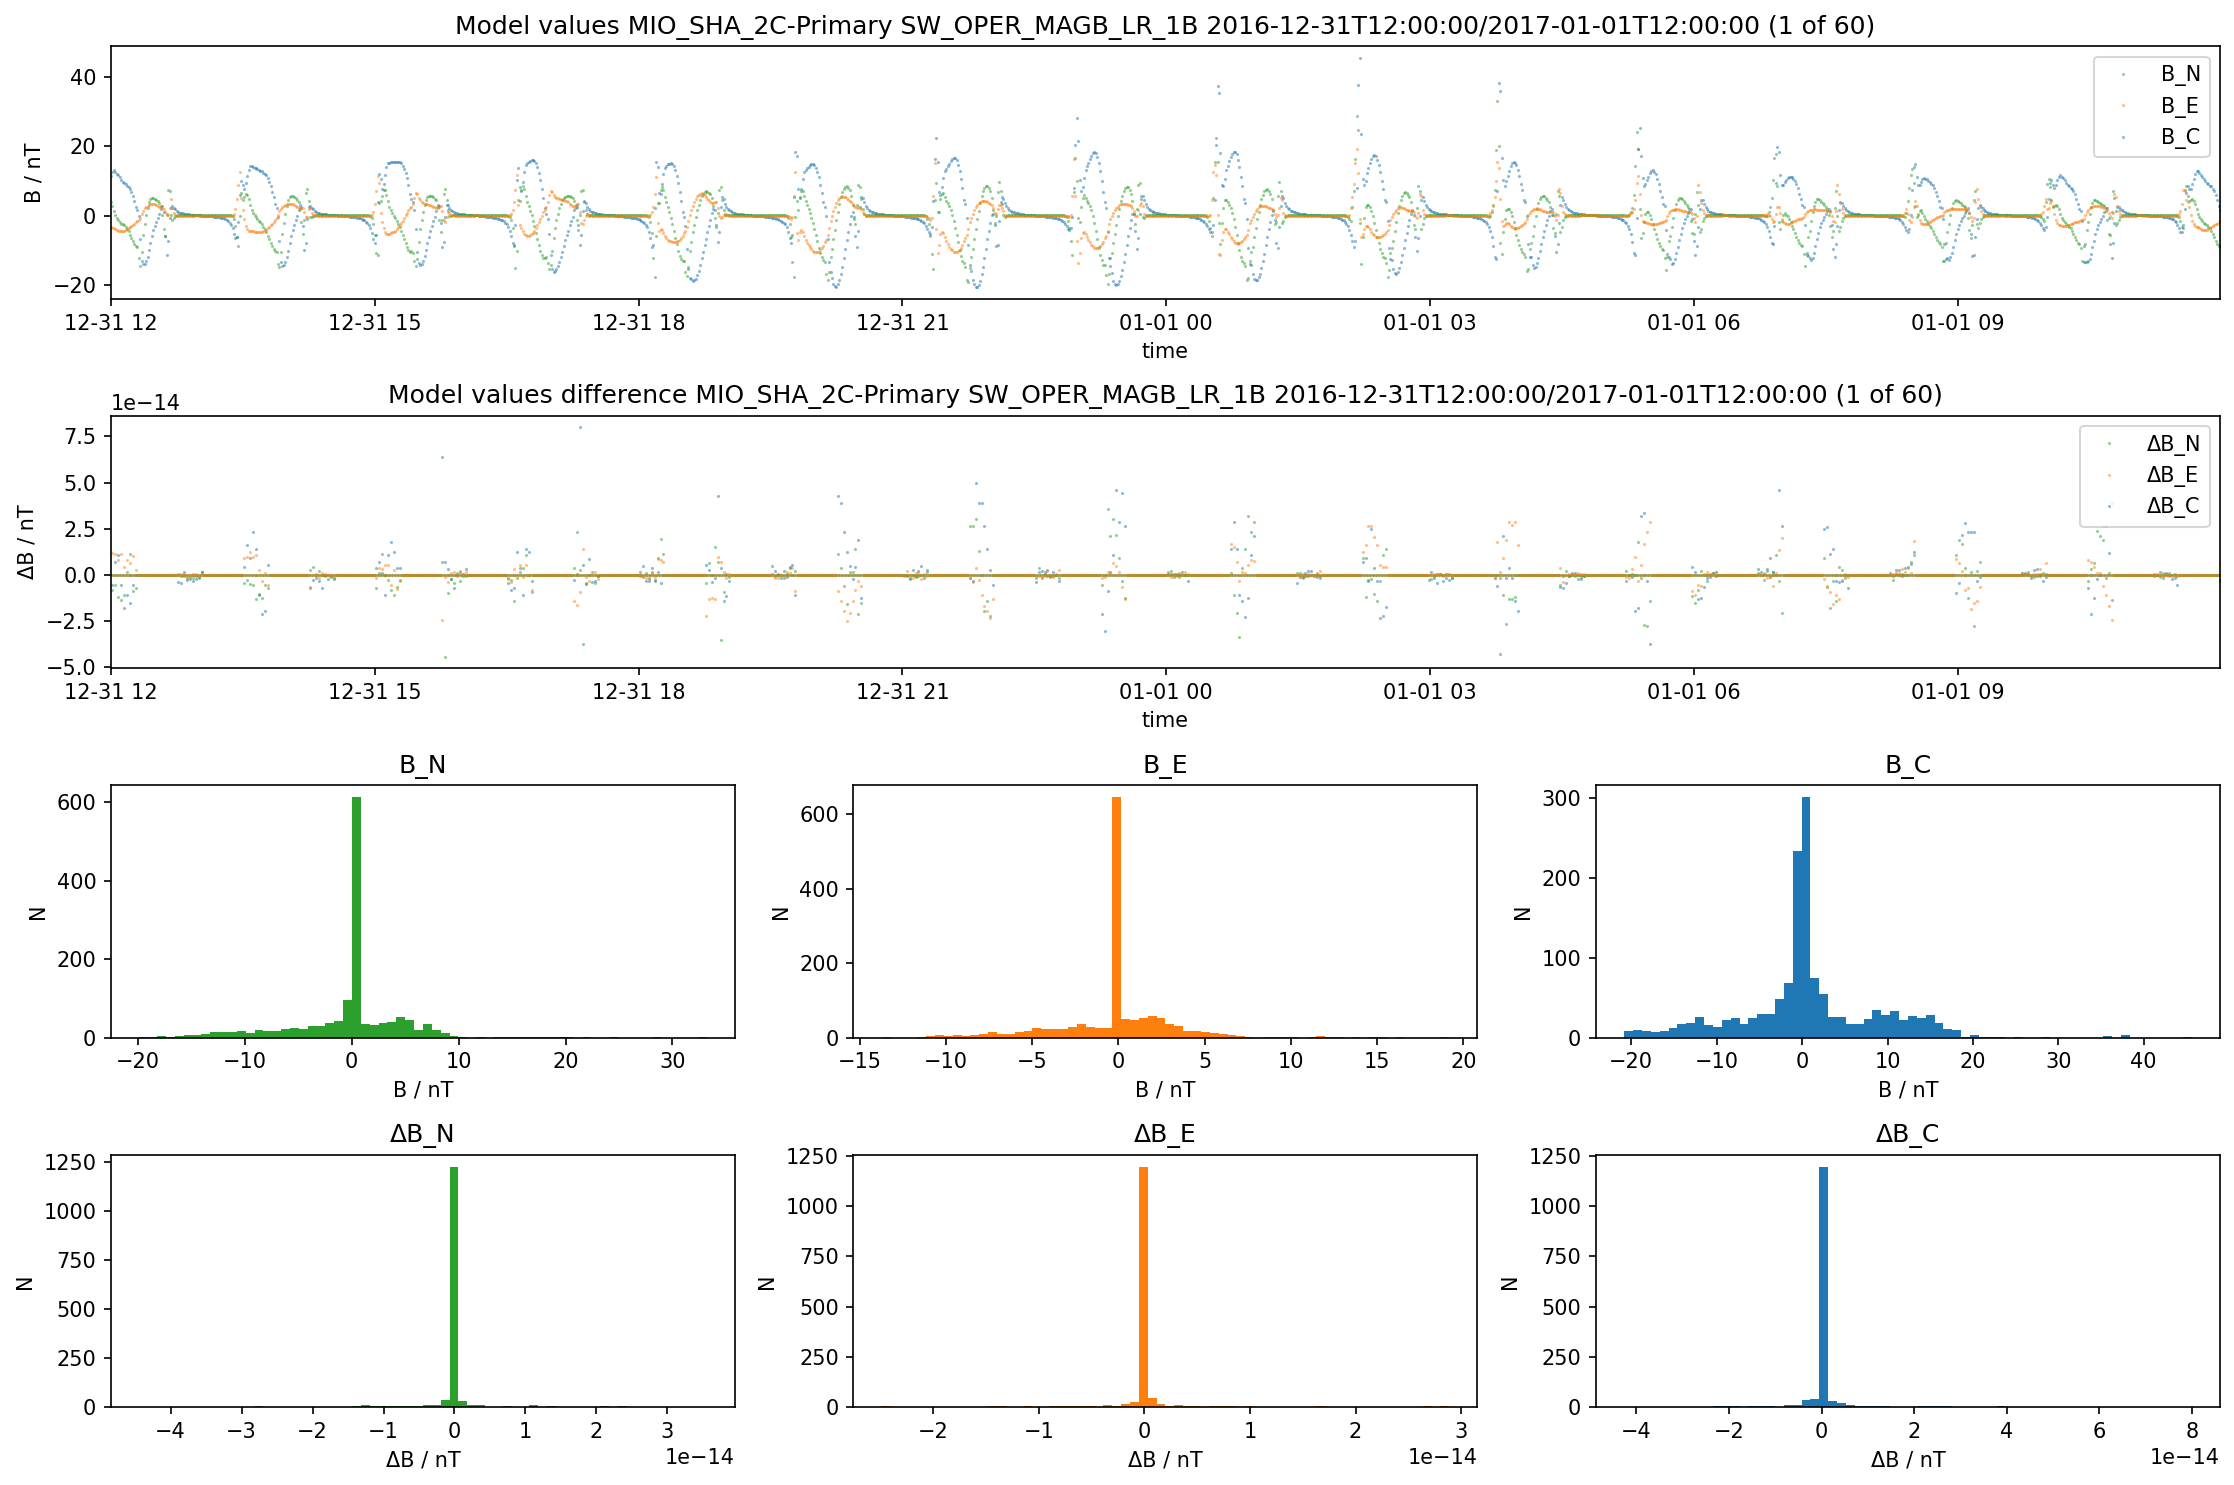

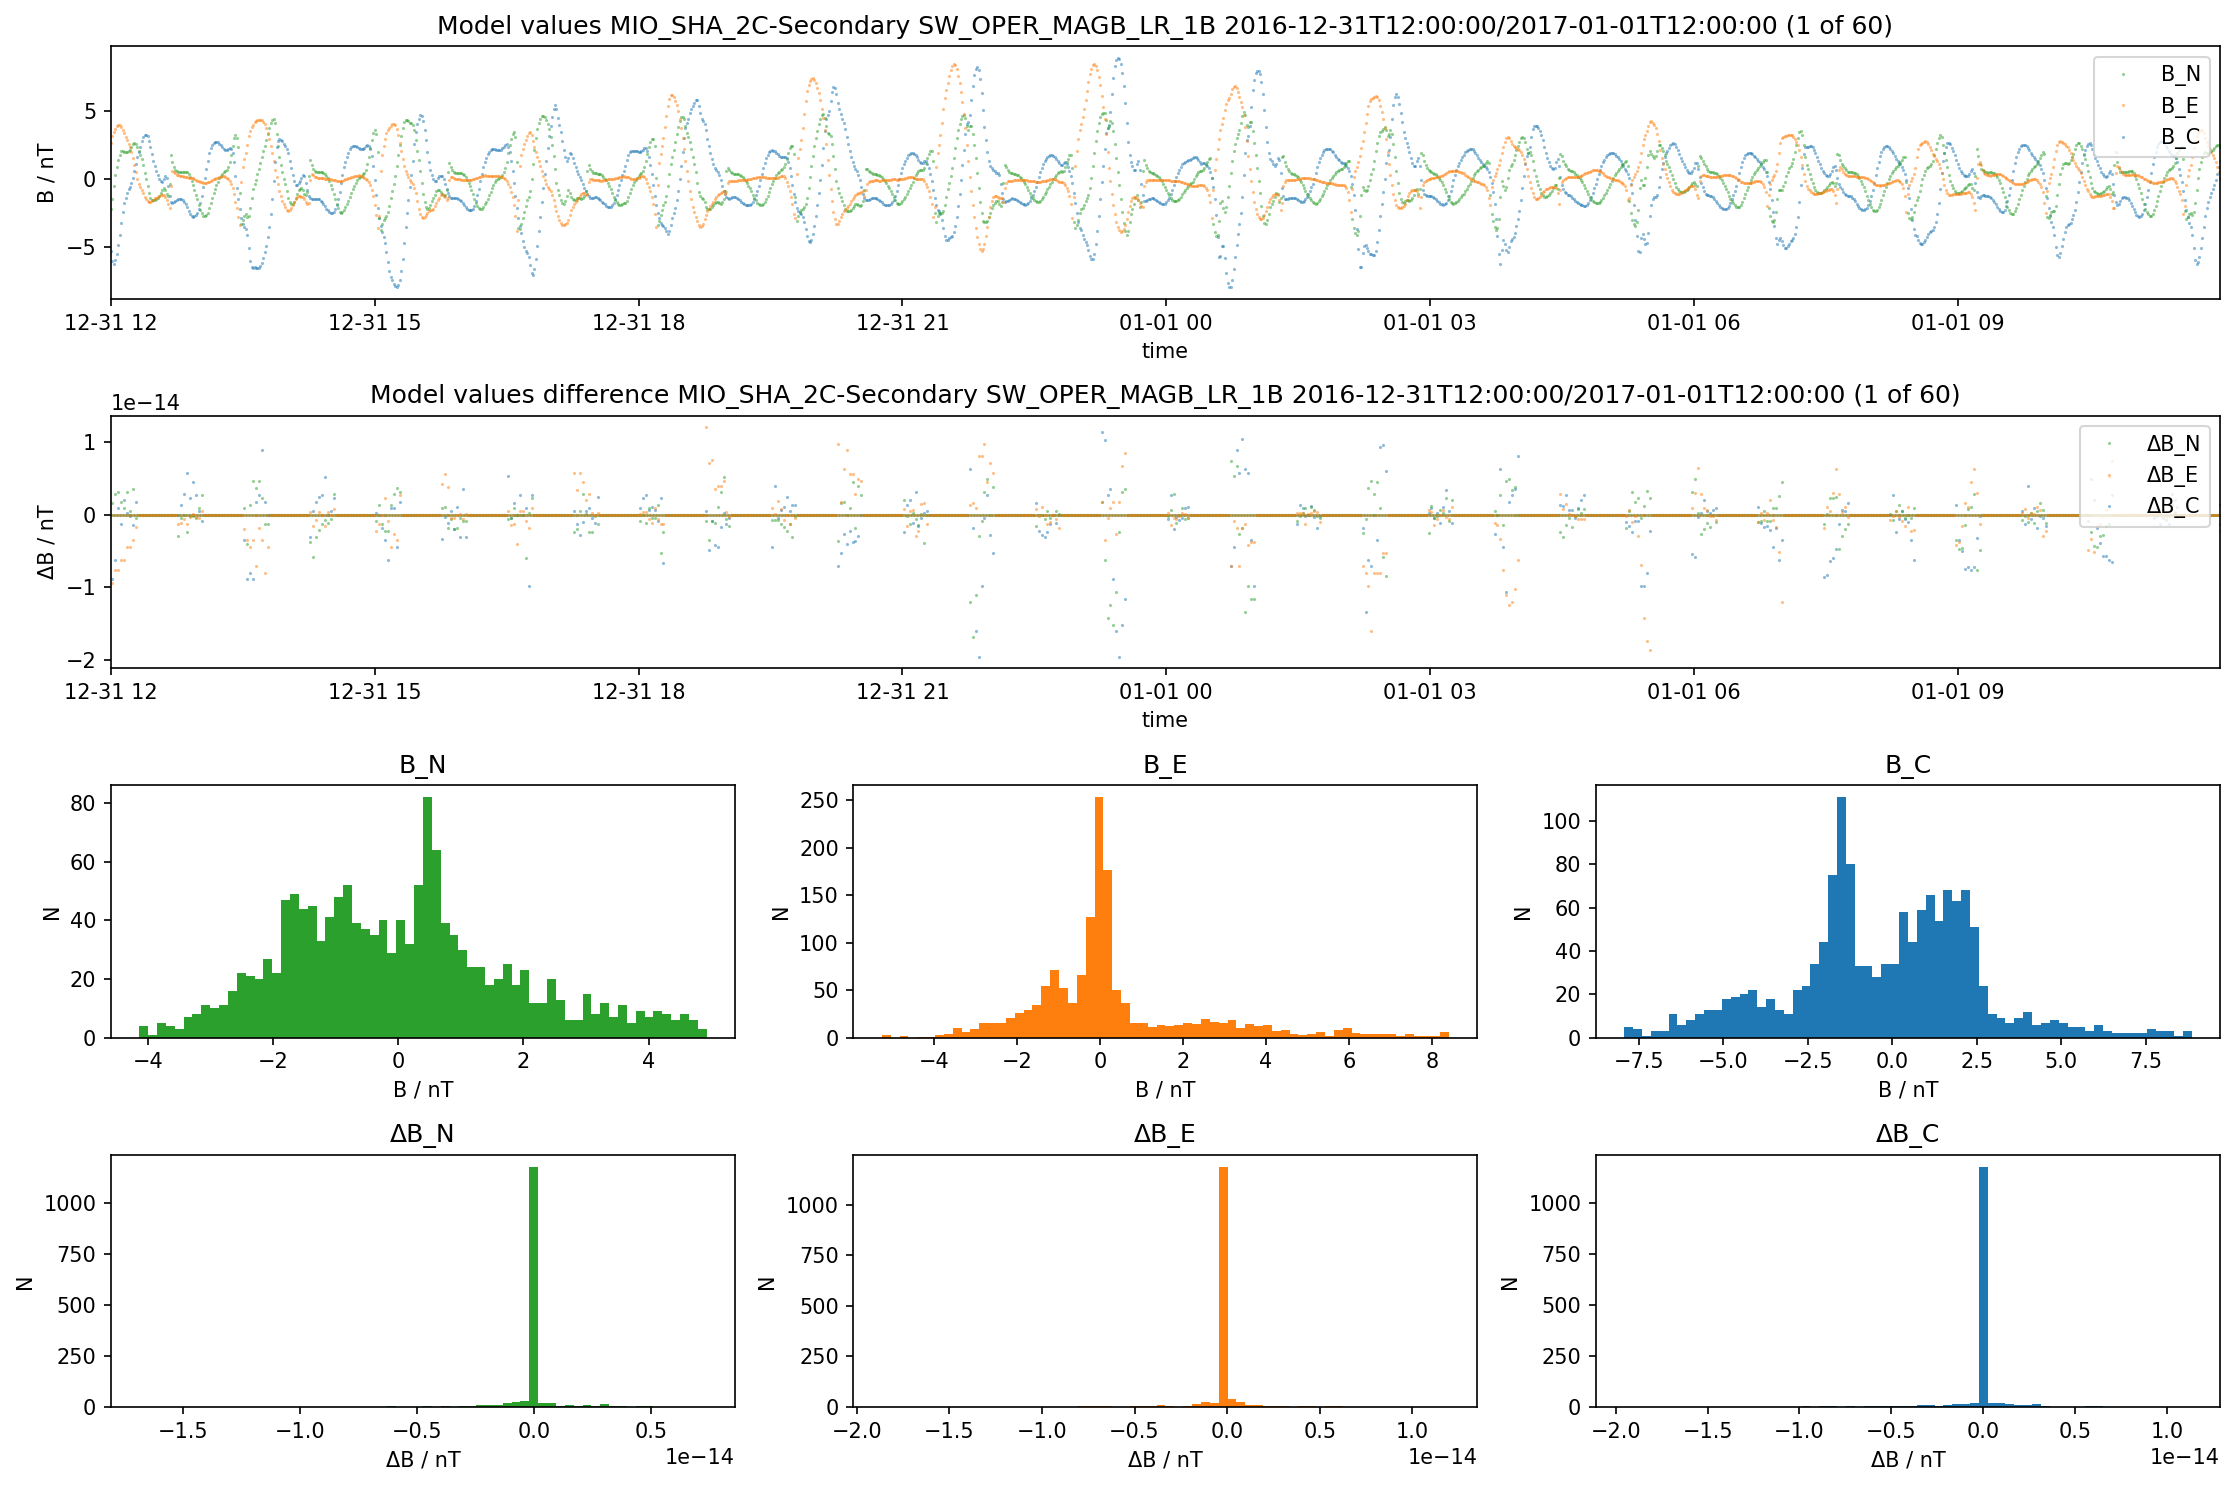

In [5]:
from matplotlib.pyplot import figure, subplot

def _plot_data(ax, x, y):
    options = {"ms": 1, "alpha": 0.5}
    h_c, = ax.plot(x, y[:,2], '.', color="tab:blue", **options)
    h_n, = ax.plot(x, y[:,0], '.', color="tab:green", **options)
    h_e, = ax.plot(x, y[:,1], '.', color="tab:orange", **options)
    return h_n, h_e, h_c


def plot_cdf(ax, data, name):
    handlers = _plot_data(ax, data["Timestamp"], data["cdf"][name])    
    ax.set_xlim([data["Timestamp"].min(), data["Timestamp"].max()])
    ax.set_xlabel("time")
    ax.set_ylabel("B / nT")
    ax.set_title(f"Model values {name} {data['info']['collection']} {data['info']['start']}/{data['info']['end']} (1 of 60)")
    ax.legend(handlers, ["B_N", "B_E", "B_C"], loc="upper right")


def plot_delta(ax, data, name):
    handlers = _plot_data(ax, data["Timestamp"], data["local"][name] - data["cdf"][name])
    ax.set_xlim([data["Timestamp"].min(), data["Timestamp"].max()])
    ax.set_xlabel("time")
    ax.set_ylabel("ΔB / nT")
    ax.set_title(f"Model values difference {name} {data['info']['collection']} {data['info']['start']}/{data['info']['end']} (1 of 60)")
    ax.legend(handlers, ["ΔB_N", "ΔB_E", "ΔB_C"], loc="upper right")

    
def plot_cdf_histogram(ax, data, name, idx, label, **options):
    ax.hist(data["cdf"][name][:,idx], bins=64, **options)
    ax.set_title(label)
    ax.set_xlabel("B / nT")
    ax.set_ylabel("N")

    
def plot_delta_histogram(ax, data, name, idx, label, **options):
    ax.hist(data["local"][name][:,idx] - data["cdf"][name][:,idx], bins=64, **options)
    ax.set_title(label)
    ax.set_xlabel("ΔB / nT")
    ax.set_ylabel("N")

    
model_names = data["info"]["model_names"]

for model_name in model_names:
    fig = figure(figsize=(15, 10), dpi=150)
    ax = subplot(4, 1, 1)
    plot_cdf(ax, data, model_name)
    ax = subplot(4, 1, 2)
    plot_delta(ax, data, model_name)
    ax = subplot(4, 3, 7)
    plot_cdf_histogram(ax, data, model_name, 0, "B_N", color="tab:green")
    ax = subplot(4, 3, 8)
    plot_cdf_histogram(ax, data, model_name, 1, "B_E", color="tab:orange")
    ax = subplot(4, 3, 9)
    plot_cdf_histogram(ax, data, model_name, 2, "B_C", color="tab:blue")
    ax = subplot(4, 3, 10)
    plot_delta_histogram(ax, data, model_name, 0, "ΔB_N", color="tab:green")
    ax = subplot(4, 3, 11)
    plot_delta_histogram(ax, data, model_name, 1, "ΔB_E", color="tab:orange")
    ax = subplot(4, 3, 12)
    plot_delta_histogram(ax, data, model_name, 2, "ΔB_C", color="tab:blue")
    fig.tight_layout()